## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


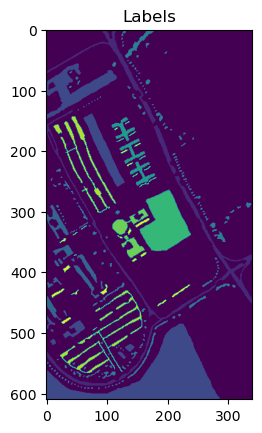

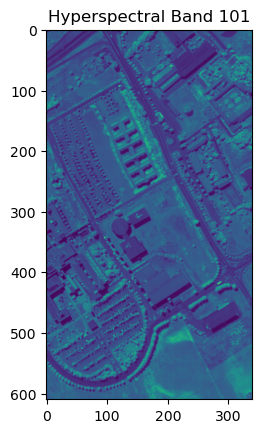

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 40 train


All datasets saved to the 'indices' folder.
(360, 5, 5, 103)
(45, 5, 5, 103)
(42371, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1193, PSNR: 7.4874


	 Training Batch [200/535], Loss: 0.0676, PSNR: 9.6959


	 Training Batch [400/535], Loss: 0.0329, PSNR: 13.0779


Epoch [1/50] Training Loss: 0.0584, PSNR: 10.9724
	[Val]   Batch [1/134] Loss: 0.0188, PSNR: 15.4438
	[Val]   Batch [10/134] Loss: 0.0164, PSNR: 17.8495
	[Val]   Batch [20/134] Loss: 0.0176, PSNR: 15.6499
	[Val]   Batch [30/134] Loss: 0.0192, PSNR: 15.0925
	[Val]   Batch [40/134] Loss: 0.0174, PSNR: 14.1480
	[Val]   Batch [50/134] Loss: 0.0186, PSNR: 15.2862


	[Val]   Batch [60/134] Loss: 0.0166, PSNR: 15.9926
	[Val]   Batch [70/134] Loss: 0.0158, PSNR: 16.1869
	[Val]   Batch [80/134] Loss: 0.0154, PSNR: 16.1811
	[Val]   Batch [90/134] Loss: 0.0163, PSNR: 16.1478
	[Val]   Batch [100/134] Loss: 0.0185, PSNR: 15.5382
	[Val]   Batch [110/134] Loss: 0.0187, PSNR: 14.0776
	[Val]   Batch [120/134] Loss: 0.0152, PSNR: 15.2679
	[Val]   Batch [130/134] Loss: 0.0170, PSNR: 13.2421


Epoch [1/50] Validation Loss: 0.0177, PSNR: 15.5001

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0197, PSNR: 15.0808


	 Training Batch [200/535], Loss: 0.0126, PSNR: 17.2026


	 Training Batch [400/535], Loss: 0.0102, PSNR: 18.3225


Epoch [2/50] Training Loss: 0.0113, PSNR: 17.5493
	[Val]   Batch [1/134] Loss: 0.0086, PSNR: 18.8754
	[Val]   Batch [10/134] Loss: 0.0067, PSNR: 21.7083
	[Val]   Batch [20/134] Loss: 0.0073, PSNR: 19.4934
	[Val]   Batch [30/134] Loss: 0.0084, PSNR: 18.7098
	[Val]   Batch [40/134] Loss: 0.0074, PSNR: 17.8222
	[Val]   Batch [50/134] Loss: 0.0078, PSNR: 19.0756


	[Val]   Batch [60/134] Loss: 0.0067, PSNR: 19.9383
	[Val]   Batch [70/134] Loss: 0.0066, PSNR: 20.0045
	[Val]   Batch [80/134] Loss: 0.0063, PSNR: 20.1013
	[Val]   Batch [90/134] Loss: 0.0067, PSNR: 20.0117
	[Val]   Batch [100/134] Loss: 0.0080, PSNR: 19.1788
	[Val]   Batch [110/134] Loss: 0.0075, PSNR: 18.0453
	[Val]   Batch [120/134] Loss: 0.0055, PSNR: 19.6850


	[Val]   Batch [130/134] Loss: 0.0068, PSNR: 17.2447
Epoch [2/50] Validation Loss: 0.0076, PSNR: 19.1897

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0066, PSNR: 19.8750


	 Training Batch [200/535], Loss: 0.0078, PSNR: 19.2866


	 Training Batch [400/535], Loss: 0.0046, PSNR: 19.3904


Epoch [3/50] Training Loss: 0.0067, PSNR: 19.7697
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2785
	[Val]   Batch [10/134] Loss: 0.0048, PSNR: 23.2062
	[Val]   Batch [20/134] Loss: 0.0051, PSNR: 21.0441
	[Val]   Batch [30/134] Loss: 0.0059, PSNR: 20.2356
	[Val]   Batch [40/134] Loss: 0.0053, PSNR: 19.3003
	[Val]   Batch [50/134] Loss: 0.0054, PSNR: 20.6619
	[Val]   Batch [60/134] Loss: 0.0047, PSNR: 21.5095


	[Val]   Batch [70/134] Loss: 0.0047, PSNR: 21.4951
	[Val]   Batch [80/134] Loss: 0.0044, PSNR: 21.6093
	[Val]   Batch [90/134] Loss: 0.0047, PSNR: 21.5174
	[Val]   Batch [100/134] Loss: 0.0057, PSNR: 20.6731
	[Val]   Batch [110/134] Loss: 0.0051, PSNR: 19.7367
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5142
	[Val]   Batch [130/134] Loss: 0.0046, PSNR: 18.8949
Epoch [3/50] Validation Loss: 0.0054, PSNR: 20.6705

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0052, PSNR: 20.5519


	 Training Batch [200/535], Loss: 0.0049, PSNR: 19.8259


	 Training Batch [400/535], Loss: 0.0059, PSNR: 22.2980


Epoch [4/50] Training Loss: 0.0050, PSNR: 21.0173
	[Val]   Batch [1/134] Loss: 0.0045, PSNR: 21.6216
	[Val]   Batch [10/134] Loss: 0.0036, PSNR: 24.4586
	[Val]   Batch [20/134] Loss: 0.0037, PSNR: 22.4651
	[Val]   Batch [30/134] Loss: 0.0042, PSNR: 21.7187
	[Val]   Batch [40/134] Loss: 0.0038, PSNR: 20.7458
	[Val]   Batch [50/134] Loss: 0.0037, PSNR: 22.2354


	[Val]   Batch [60/134] Loss: 0.0036, PSNR: 22.6965
	[Val]   Batch [70/134] Loss: 0.0035, PSNR: 22.7677
	[Val]   Batch [80/134] Loss: 0.0033, PSNR: 22.8658
	[Val]   Batch [90/134] Loss: 0.0035, PSNR: 22.7902
	[Val]   Batch [100/134] Loss: 0.0041, PSNR: 22.0424
	[Val]   Batch [110/134] Loss: 0.0035, PSNR: 21.3365
	[Val]   Batch [120/134] Loss: 0.0026, PSNR: 22.9223


	[Val]   Batch [130/134] Loss: 0.0033, PSNR: 20.4019
Epoch [4/50] Validation Loss: 0.0040, PSNR: 22.0014

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0048, PSNR: 21.4271


	 Training Batch [200/535], Loss: 0.0037, PSNR: 22.5058


	 Training Batch [400/535], Loss: 0.0037, PSNR: 22.5978


Epoch [5/50] Training Loss: 0.0037, PSNR: 22.3273
	[Val]   Batch [1/134] Loss: 0.0033, PSNR: 23.0075
	[Val]   Batch [10/134] Loss: 0.0026, PSNR: 25.8441
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.1345
	[Val]   Batch [30/134] Loss: 0.0029, PSNR: 23.3659
	[Val]   Batch [40/134] Loss: 0.0026, PSNR: 22.4175
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 23.9746
	[Val]   Batch [60/134] Loss: 0.0027, PSNR: 23.9407


	[Val]   Batch [70/134] Loss: 0.0026, PSNR: 24.0972
	[Val]   Batch [80/134] Loss: 0.0024, PSNR: 24.2188
	[Val]   Batch [90/134] Loss: 0.0026, PSNR: 24.1409
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.5165
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.2069
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.5478
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.1145
Epoch [5/50] Validation Loss: 0.0029, PSNR: 23.4670

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0030, PSNR: 25.2545


	 Training Batch [200/535], Loss: 0.0032, PSNR: 23.1564


	 Training Batch [400/535], Loss: 0.0019, PSNR: 23.6316


Epoch [6/50] Training Loss: 0.0030, PSNR: 23.2967
	[Val]   Batch [1/134] Loss: 0.0027, PSNR: 23.8414
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.6962
	[Val]   Batch [20/134] Loss: 0.0020, PSNR: 25.1868
	[Val]   Batch [30/134] Loss: 0.0023, PSNR: 24.3790
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.4589
	[Val]   Batch [50/134] Loss: 0.0020, PSNR: 25.0572
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.7288


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 24.9302
	[Val]   Batch [80/134] Loss: 0.0020, PSNR: 25.0830
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 24.9600
	[Val]   Batch [100/134] Loss: 0.0024, PSNR: 24.4403
	[Val]   Batch [110/134] Loss: 0.0018, PSNR: 24.3586
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6061
	[Val]   Batch [130/134] Loss: 0.0018, PSNR: 23.0898
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.3792

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0032, PSNR: 23.1630


	 Training Batch [200/535], Loss: 0.0017, PSNR: 24.6241


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.6795


Epoch [7/50] Training Loss: 0.0026, PSNR: 23.9451
	[Val]   Batch [1/134] Loss: 0.0024, PSNR: 24.3911
	[Val]   Batch [10/134] Loss: 0.0019, PSNR: 27.2870
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 25.9609
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.0619
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.2164
	[Val]   Batch [50/134] Loss: 0.0017, PSNR: 25.7758
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3027


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.5340
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.7346
	[Val]   Batch [90/134] Loss: 0.0019, PSNR: 25.5235
	[Val]   Batch [100/134] Loss: 0.0021, PSNR: 25.0750
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 25.1484
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.4130
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.7775
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.0249

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.5366


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.3345


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1297


Epoch [8/50] Training Loss: 0.0023, PSNR: 24.4213
	[Val]   Batch [1/134] Loss: 0.0022, PSNR: 24.7522
	[Val]   Batch [10/134] Loss: 0.0017, PSNR: 27.6642
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.4931
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.5415
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.7266
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.2567


	[Val]   Batch [60/134] Loss: 0.0018, PSNR: 25.6829
	[Val]   Batch [70/134] Loss: 0.0017, PSNR: 25.9353
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 26.1629
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 25.9122
	[Val]   Batch [100/134] Loss: 0.0019, PSNR: 25.5149
	[Val]   Batch [110/134] Loss: 0.0013, PSNR: 25.6910


	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 26.9208
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.2175
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.4702

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0036, PSNR: 22.6485


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.4930


	 Training Batch [400/535], Loss: 0.0022, PSNR: 24.7072


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.7912
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1209
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 28.0621
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.0004
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 26.0194
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.2595
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.7474
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.0873


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3105
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.5757
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.2902
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.9515
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.2392
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.4348
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7016
Epoch [9/50] Validation Loss: 0.0017, PSNR: 25.9118

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.0912


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.4305


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.5049


Epoch [10/50] Training Loss: 0.0020, PSNR: 25.0546
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4006
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3571
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4131
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3706
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6428
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.0776
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3757


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6126
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9091
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5862
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2764
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.6530
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8097
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0404
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2488

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 25.0959


	 Training Batch [200/535], Loss: 0.0012, PSNR: 25.4945


	 Training Batch [400/535], Loss: 0.0012, PSNR: 26.1076


Epoch [11/50] Training Loss: 0.0019, PSNR: 25.3111
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6572
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6737
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.8034
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6994
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0347
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4167
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7024


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.8886
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2288
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8849
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5900
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.0762
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.1950
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.4095
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5752

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 27.3273


	 Training Batch [200/535], Loss: 0.0024, PSNR: 24.5690


	 Training Batch [400/535], Loss: 0.0027, PSNR: 24.6526


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.5225
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9043
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9023
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1226
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 26.9938
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3337
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.6747
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9482


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1389
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5077
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1389
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8322
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3909
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5061
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.7100
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.8534

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.6438


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.5091


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.9464


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7255
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 26.0158
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9863
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.2820
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1368
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4533
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.7546
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0843


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.2568
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6486
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2637
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9455
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4795
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6073
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.8039
Epoch [13/50] Validation Loss: 0.0013, PSNR: 26.9768

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.1067


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.3245


	 Training Batch [400/535], Loss: 0.0011, PSNR: 25.8889


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9009
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2053
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2001
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.5794
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.3734
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.7202
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.0092
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3284


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.4447
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.8822
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.4881
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1618
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7415
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8573
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0600
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.2167

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4454


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.2448


	 Training Batch [400/535], Loss: 0.0018, PSNR: 25.6430


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1044
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4435
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4192
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8935
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6314
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0365
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2634
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6092


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7348
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.1637
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7453
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4200
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 28.0558
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1606
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3691
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4893

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0516


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0797


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.2916


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2278
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6158
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5599
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0772
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7996
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.2481
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3998
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7753


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.9009
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3312
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9062
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5952
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1862
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2706
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5721


Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6649

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2472


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.8176


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8462


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4108
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8127
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7100
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3385
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0365
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4454
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.6064


	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0109
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1287
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.5651
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1517
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7847
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3771
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4809


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7822
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8715

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.0262


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.4346


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.0773


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6224
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0813
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9203
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7013
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3599
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7897
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9301
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3310
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4277


	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8662
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4498
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0761
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7225
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7737
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1051
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1702

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8125


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.8721


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.1678


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7600
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2957
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0862
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 29.9899
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.6156
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0283
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.1465
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.5737


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.6586
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.1188
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.6890
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3272
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9371
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8939
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3224
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.3955

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 25.8044


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.9021


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4219


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.8935
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4835
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1983
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.1737
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8466
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2133
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.3167
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.8008


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.8544
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2910
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9025
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5133
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0306
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0104
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.4904
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.5767

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6110


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.3029


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.9156


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.1259
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6730
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3627
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3456
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0603
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3983
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4413
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0435


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1289
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.5165
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.1433
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7026
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0608
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0693
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.6975
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.7623

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6370


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4676


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.4605


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.2214
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0339
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6311
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7746
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4594
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8022
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.8385
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.4122


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.5206
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8539
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5375
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1039
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4106
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3599
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0865
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.1288

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6133


	 Training Batch [200/535], Loss: 0.0011, PSNR: 26.7563


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.5336


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.4347
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2760
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7851
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9493
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7287
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9949
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0644
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6585


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7813
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0747
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7846
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3350
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5127
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4502
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2551
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.3402

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.2187


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.2467


	 Training Batch [400/535], Loss: 0.0011, PSNR: 29.5277


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.6436
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4542
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9805
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2095
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9772
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2121
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.2403
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8752
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9839


	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2872
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0420
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.6199
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6596
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5471
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.4396
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.5610

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9061


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.5623


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.9233


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.7615
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.7929
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1854
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.4068
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.2972
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4009
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5378
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1460


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3293
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5302
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.3330
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.8831
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7960
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6960
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6364
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.8215

LOG: Epoch [26/50]


	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.1607


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.9248


	 Training Batch [400/535], Loss: 0.0008, PSNR: 26.8698


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.8687
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9828
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3398
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5058
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4971
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4743
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.6860
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2260


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4887
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6433
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5070
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0760
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8800
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7247
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7249
Epoch [26/50] Validation Loss: 0.0007, PSNR: 29.9691

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.7390


	 Training Batch [200/535], Loss: 0.0012, PSNR: 29.2310


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.5122


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.1121
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2618
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5118
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7552
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7668
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6199
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9210
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4286


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7007
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8617
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7345
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3214
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0326
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7868
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8393
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.1843

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6484


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.1915


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.3404


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.2128
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.4643
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6411
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8298
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.9761
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.7819
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.1029


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.5660
	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.8947
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9234
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.9399
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.5235
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1149
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9466
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9743


Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.3556

LOG: Epoch [29/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6040


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.6826


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.0764


Epoch [29/50] Training Loss: 0.0009, PSNR: 28.3121
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.7151
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.8910
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1240
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2337
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9701
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.3358
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7733


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1138
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.1633
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1639
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.7646
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.2979
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.0896
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.1252
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.5969
Early stopping triggered at epoch 29. No improvement for 3 epochs.


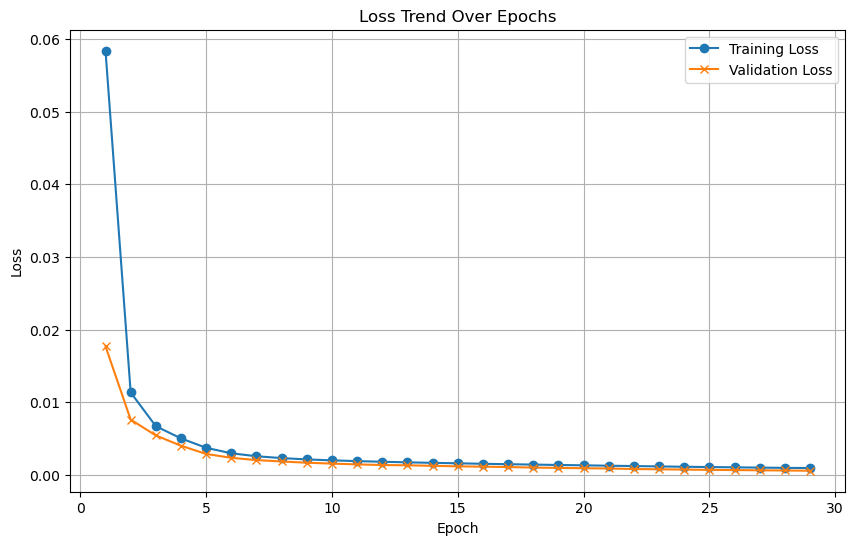

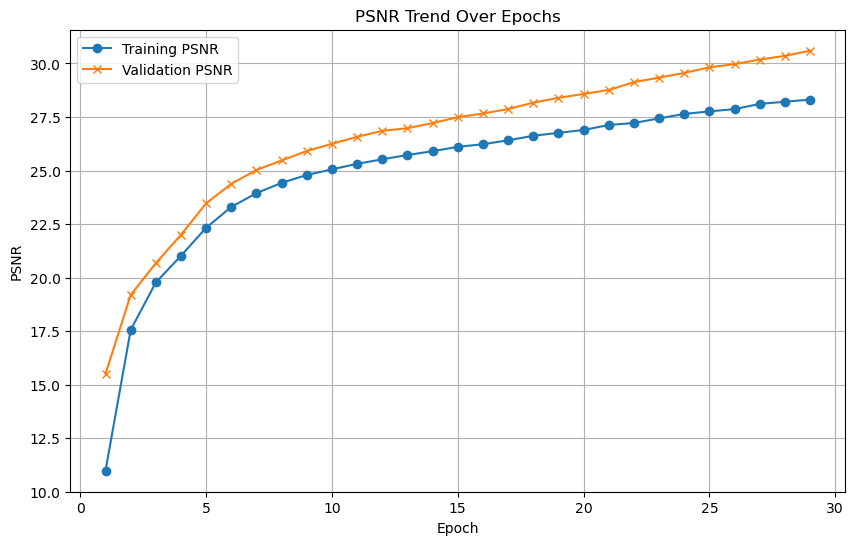

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/166 for test dataset.


    Processed batch 101/166 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2136
    Validation Batch [1/1], Loss: 2.2003
Validation Loss: 2.2003, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2003. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1647
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1247
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1013
    Validation Batch [1/1], Loss: 2.2004
Validation Loss: 2.2004, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

    Validation Batch [1/1], Loss: 2.1965
Validation Loss: 2.1965, Validation Accuracy: 11.11%
Validation loss improved from 2.1980 to 2.1965. Saving model...

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 1.9099
    Validation Batch [1/1], Loss: 2.1941
Validation Loss: 2.1941, Validation Accuracy: 11.11%
Validation loss improved from 2.1965 to 2.1941. Saving model...

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 1.8868
    Validation Batch [1/1], Loss: 2.1895
Validation Loss: 2.1895, Validation Accuracy: 11.11%
Validation loss improved from 2.1941 to 2.1895. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 1.8546
    Validation Batch [1/1], Loss: 2.1809
Validation Loss: 2.1809, Validation Accuracy: 13.33%
Validation loss improved from 2.1895 to 2.1809. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 1.8334
    Vali

Epoch [29/1000] completed, Average Training Loss: 1.6054
    Validation Batch [1/1], Loss: 1.6571
Validation Loss: 1.6571, Validation Accuracy: 73.33%
Validation loss improved from 1.6869 to 1.6571. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 1.5696
    Validation Batch [1/1], Loss: 1.6310
Validation Loss: 1.6310, Validation Accuracy: 71.11%
Validation loss improved from 1.6571 to 1.6310. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 1.5586
    Validation Batch [1/1], Loss: 1.6050
Validation Loss: 1.6050, Validation Accuracy: 71.11%
Validation loss improved from 1.6310 to 1.6050. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 1.5701
    Validation Batch [1/1], Loss: 1.5742
Validation Loss: 1.5742, Validation Accuracy: 71.11%
Validation loss improved from 1.6050 to 1.5742. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [3

Epoch [46/1000] completed, Average Training Loss: 1.3550
    Validation Batch [1/1], Loss: 1.3073
Validation Loss: 1.3073, Validation Accuracy: 75.56%
Validation loss improved from 1.3435 to 1.3073. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 1.3274
    Validation Batch [1/1], Loss: 1.2732
Validation Loss: 1.2732, Validation Accuracy: 80.00%
Validation loss improved from 1.3073 to 1.2732. Saving model...

LOG: Epoch [48/1000] - Training
Epoch [48/1000] completed, Average Training Loss: 1.2894
    Validation Batch [1/1], Loss: 1.2672
Validation Loss: 1.2672, Validation Accuracy: 75.56%
Validation loss improved from 1.2732 to 1.2672. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.3081
    Validation Batch [1/1], Loss: 1.2610
Validation Loss: 1.2610, Validation Accuracy: 77.78%
Validation loss improved from 1.2672 to 1.2610. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [5

Epoch [63/1000] completed, Average Training Loss: 1.0506
    Validation Batch [1/1], Loss: 1.0467
Validation Loss: 1.0467, Validation Accuracy: 80.00%
Validation loss improved from 1.0765 to 1.0467. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.0379
    Validation Batch [1/1], Loss: 1.0352
Validation Loss: 1.0352, Validation Accuracy: 73.33%
Validation loss improved from 1.0467 to 1.0352. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.0444
    Validation Batch [1/1], Loss: 1.0137
Validation Loss: 1.0137, Validation Accuracy: 84.44%
Validation loss improved from 1.0352 to 1.0137. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.0256
    Validation Batch [1/1], Loss: 0.9843
Validation Loss: 0.9843, Validation Accuracy: 84.44%
Validation loss improved from 1.0137 to 0.9843. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 0.8553
Validation Loss: 0.8553, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 0.8019
    Validation Batch [1/1], Loss: 0.7957
Validation Loss: 0.7957, Validation Accuracy: 88.89%
Validation loss improved from 0.8496 to 0.7957. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 0.7800
    Validation Batch [1/1], Loss: 0.7726
Validation Loss: 0.7726, Validation Accuracy: 82.22%
Validation loss improved from 0.7957 to 0.7726. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 0.7494
    Validation Batch [1/1], Loss: 0.7952
Validation Loss: 0.7952, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 0.7444
    Validation Batch [1/1], Loss: 0.79

Epoch [97/1000] completed, Average Training Loss: 0.5918
    Validation Batch [1/1], Loss: 0.7279
Validation Loss: 0.7279, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 0.5662
    Validation Batch [1/1], Loss: 0.6169
Validation Loss: 0.6169, Validation Accuracy: 95.56%
Validation loss improved from 0.6275 to 0.6169. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 0.5352
    Validation Batch [1/1], Loss: 0.6129
Validation Loss: 0.6129, Validation Accuracy: 82.22%
Validation loss improved from 0.6169 to 0.6129. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 0.5431
    Validation Batch [1/1], Loss: 0.5365
Validation Loss: 0.5365, Validation Accuracy: 95.56%
Validation loss improved from 0.6129 to 0.5365. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] com

Epoch [115/1000] completed, Average Training Loss: 0.3748
    Validation Batch [1/1], Loss: 0.4343
Validation Loss: 0.4343, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.3802
    Validation Batch [1/1], Loss: 0.4455
Validation Loss: 0.4455, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.3454
    Validation Batch [1/1], Loss: 0.4229
Validation Loss: 0.4229, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.3239
    Validation Batch [1/1], Loss: 0.4295
Validation Loss: 0.4295, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.3466
  

Epoch [132/1000] completed, Average Training Loss: 0.2558
    Validation Batch [1/1], Loss: 0.4334
Validation Loss: 0.4334, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.2626
    Validation Batch [1/1], Loss: 0.3421
Validation Loss: 0.3421, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 0.2401
    Validation Batch [1/1], Loss: 0.2850
Validation Loss: 0.2850, Validation Accuracy: 95.56%
Validation loss improved from 0.2929 to 0.2850. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.2530
    Validation Batch [1/1], Loss: 0.3055
Validation Loss: 0.3055, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training 

Epoch [150/1000] completed, Average Training Loss: 0.1795
    Validation Batch [1/1], Loss: 0.2919
Validation Loss: 0.2919, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.1848
    Validation Batch [1/1], Loss: 0.3118
Validation Loss: 0.3118, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.1928
    Validation Batch [1/1], Loss: 0.2640
Validation Loss: 0.2640, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.1662
    Validation Batch [1/1], Loss: 0.2898
Validation Loss: 0.2898, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.167

Epoch [167/1000] completed, Average Training Loss: 0.1288
    Validation Batch [1/1], Loss: 0.2503
Validation Loss: 0.2503, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.1204
    Validation Batch [1/1], Loss: 0.2057
Validation Loss: 0.2057, Validation Accuracy: 93.33%
Validation loss improved from 0.2061 to 0.2057. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.1334
    Validation Batch [1/1], Loss: 0.2435
Validation Loss: 0.2435, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.1149
    Validation Batch [1/1], Loss: 0.2208
Validation Loss: 0.2208, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.1844
Validation Loss: 0.1844, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.1038
    Validation Batch [1/1], Loss: 0.6203
Validation Loss: 0.6203, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.0993
    Validation Batch [1/1], Loss: 0.2694
Validation Loss: 0.2694, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.1005
    Validation Batch [1/1], Loss: 0.2468
Validation Loss: 0.2468, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.0978
    Validation Batch [1/1], Loss: 0.7333
Validation Loss

Epoch [202/1000] completed, Average Training Loss: 0.0884
    Validation Batch [1/1], Loss: 0.2632
Validation Loss: 0.2632, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.3992
Validation Loss: 0.3992, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.1812
Validation Loss: 0.1812, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.0788
    Validation Batch [1/1], Loss: 0.3882
Validation Loss: 0.3882, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.0825
  

Epoch [220/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.2737
Validation Loss: 0.2737, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.1380
Validation Loss: 0.1380, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.0597
    Validation Batch [1/1], Loss: 0.1392
Validation Loss: 0.1392, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.0630
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.0639

Epoch [237/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.2539
Validation Loss: 0.2539, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.0563
    Validation Batch [1/1], Loss: 0.1965
Validation Loss: 0.1965, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.0475
    Validation Batch [1/1], Loss: 0.1446
Validation Loss: 0.1446, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.1424
Validation Loss: 0.1424, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.050

Epoch [253/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.1502
Validation Loss: 0.1502, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1274
Validation Loss: 0.1274, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.1755
Validation Loss: 0.1755, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.3226
Validation Loss: 0.3226, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.048

Epoch [271/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.1231
Validation Loss: 0.1231, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.0364
    Validation Batch [1/1], Loss: 0.1439
Validation Loss: 0.1439, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.1534
Validation Loss: 0.1534, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0328
    Validation Batch [1/1], Loss: 0.1378
Validation Loss: 0.1378, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.032

Epoch [289/1000] completed, Average Training Loss: 0.0311
    Validation Batch [1/1], Loss: 0.1397
Validation Loss: 0.1397, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.1445
Validation Loss: 0.1445, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.2460
Validation Loss: 0.2460, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.2620
Validation Loss: 0.2620, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.0285
 

    Validation Batch [1/1], Loss: 0.1835
Validation Loss: 0.1835, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.2051
Validation Loss: 0.2051, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.1650
Validation Loss: 0.1650, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.0232
    Validation Batch [1/1], Loss: 0.1242
Validation Loss: 0.1242, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.0265
    Validation Batch [1/1], Loss: 0.1087
Validation Loss

Epoch [325/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.2419
Validation Loss: 0.2419, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.0221
    Validation Batch [1/1], Loss: 0.2347
Validation Loss: 0.2347, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.1684
Validation Loss: 0.1684, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.0209
    Validation Batch [1/1], Loss: 0.1315
Validation Loss: 0.1315, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.020

Epoch [342/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.1633
Validation Loss: 0.1633, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.0214
    Validation Batch [1/1], Loss: 0.1586
Validation Loss: 0.1586, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.0238
    Validation Batch [1/1], Loss: 0.1995
Validation Loss: 0.1995, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.1893
Validation Loss: 0.1893, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.025

Epoch [360/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.1829
Validation Loss: 0.1829, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.1575
Validation Loss: 0.1575, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.1637
Validation Loss: 0.1637, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.2061
Validation Loss: 0.2061, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.019

Epoch [378/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.4145
Validation Loss: 0.4145, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.2438
Validation Loss: 0.2438, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.1334
Validation Loss: 0.1334, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.0165
    Validation Batch [1/1], Loss: 0.1053
Validation Loss: 0.1053, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.018

    Validation Batch [1/1], Loss: 0.1835
Validation Loss: 0.1835, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.1226
Validation Loss: 0.1226, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.0147
    Validation Batch [1/1], Loss: 0.1191
Validation Loss: 0.1191, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0163
    Validation Batch [1/1], Loss: 0.1181
Validation Loss: 0.1181, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.1210
Validation Loss

Epoch [413/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.1314
Validation Loss: 0.1314, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.1341
Validation Loss: 0.1341, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.2125
Validation Loss: 0.2125, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.2711
Validation Loss: 0.2711, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.012

Epoch [431/1000] completed, Average Training Loss: 0.0150
    Validation Batch [1/1], Loss: 0.1475
Validation Loss: 0.1475, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0133
    Validation Batch [1/1], Loss: 0.1684
Validation Loss: 0.1684, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0160
    Validation Batch [1/1], Loss: 0.2390
Validation Loss: 0.2390, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.2615
Validation Loss: 0.2615, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.012

Epoch [449/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.3549
Validation Loss: 0.3549, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.3455
Validation Loss: 0.3455, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.2493
Validation Loss: 0.2493, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0121
    Validation Batch [1/1], Loss: 0.1578
Validation Loss: 0.1578, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.010

Epoch [466/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.1000
Validation Loss: 0.1000, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.1413
Validation Loss: 0.1413, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0110
    Validation Batch [1/1], Loss: 0.1795
Validation Loss: 0.1795, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.1917
Validation Loss: 0.1917, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.012

Epoch [483/1000] completed, Average Training Loss: 0.0076
    Validation Batch [1/1], Loss: 0.1190
Validation Loss: 0.1190, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0110
    Validation Batch [1/1], Loss: 0.1366
Validation Loss: 0.1366, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.1571
Validation Loss: 0.1571, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.1531
Validation Loss: 0.1531, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.009

Epoch [501/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.3166
Validation Loss: 0.3166, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.3658
Validation Loss: 0.3658, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.2379
Validation Loss: 0.2379, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.1953
Validation Loss: 0.1953, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.009

Epoch [519/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.2749
Validation Loss: 0.2749, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.2655
Validation Loss: 0.2655, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.1933
Validation Loss: 0.1933, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0097
    Validation Batch [1/1], Loss: 0.1253
Validation Loss: 0.1253, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.007

Epoch [537/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.0891
Validation Loss: 0.0891, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0076
    Validation Batch [1/1], Loss: 0.1144
Validation Loss: 0.1144, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.1449
Validation Loss: 0.1449, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.0085
    Validation Batch [1/1], Loss: 0.1783
Validation Loss: 0.1783, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.008

    Validation Batch [1/1], Loss: 0.1150
Validation Loss: 0.1150, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.1074
Validation Loss: 0.1074, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.1188
Validation Loss: 0.1188, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.1543
Validation Loss: 0.1543, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.1888
Validation Loss

Epoch [570/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0916
Validation Loss: 0.0916, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0811
Validation Loss: 0.0811, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0855
Validation Loss: 0.0855, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.1187
Validation Loss: 0.1187, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 573. No improvement for 100 epochs.
Loading the best mo

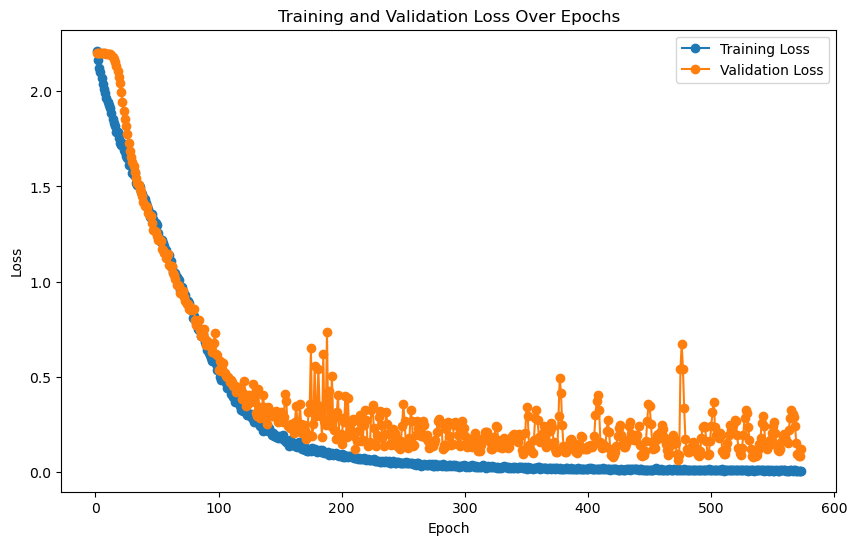

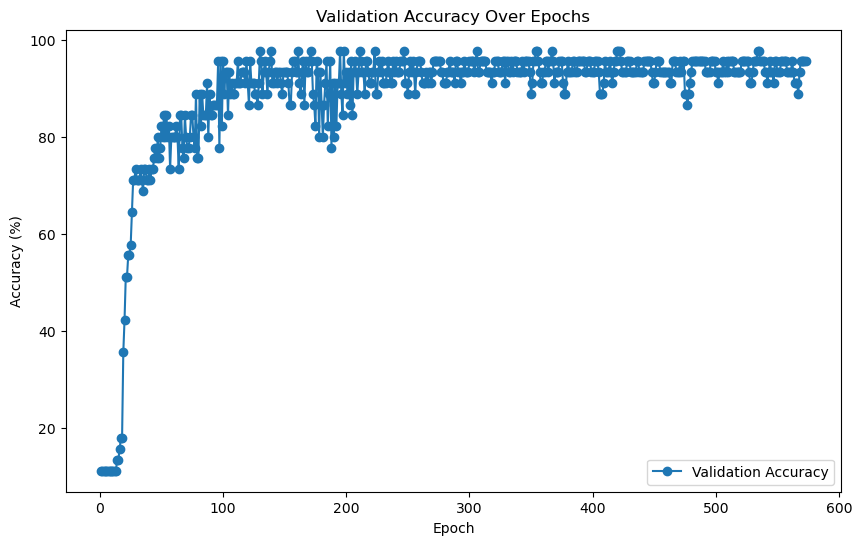


Evaluating on the test set...
    Test Batch [1/166], Loss: 0.2342



Final Test Loss: 0.2315, Test Accuracy: 92.42%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.


  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.


  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42371, 64), Test labels shape: (42371,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.80      0.62         5
           2       0.80      0.80      0.80         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       1.00      0.20      0.33         5
           6       0.83      1.00      0.91         5
           7       0.80      0.80      0.80         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42371, 64)
Test labels shape: (42371,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2482  |  Val Loss: 2.0377
Validation loss improved from inf to 2.0377.
[Epoch 2/1000] Train Loss: 1.9857  |  Val Loss: 1.9024
Validation loss improved from 2.0377 to 1.9024.
[Epoch 3/1000] Train Loss: 1.8346  |  Val Loss: 1.7457
Validation loss improved from 1.9024 to 1.7457.
[Epoch 4/1000] Train Loss: 1.6607  |  Val Loss: 1.5732
Validation loss improved from 1.7457 to 1.5732.
[Epoch 5/1000] Train Loss: 1.4731  |  Val Loss: 1.3791
Validation loss improved from 1.5732 to 1.3791.
[Epoch 6/1000] Train Loss: 1.2860  |  Val Loss: 1.2231
Validation loss improved from 1.3791 to 1.2231.
[Epoch 7/1000] Train Loss: 1.1456  |  Val Loss: 1.0920
Validation loss improved from 1.2231 to 1.0920.
[Epoch 8/1000] Train Loss: 1.0238  |  Val Loss: 0.9875
Validation loss improved from 1.0920 to 0.9875.
[Epoch 9/1000] Train Loss: 0.9210  |  Val Loss: 0.8910
Validation loss improved from 0.9875 to 0.8910.
[Epoch 10/1000] Train Loss: 0.8327  |  Val Loss: 0.8131
Validation loss impr

[Epoch 12/1000] Train Loss: 0.6993  |  Val Loss: 0.6792
Validation loss improved from 0.7564 to 0.6792.
[Epoch 13/1000] Train Loss: 0.6500  |  Val Loss: 0.6457
Validation loss improved from 0.6792 to 0.6457.
[Epoch 14/1000] Train Loss: 0.6094  |  Val Loss: 0.5961
Validation loss improved from 0.6457 to 0.5961.
[Epoch 15/1000] Train Loss: 0.5786  |  Val Loss: 0.5713
Validation loss improved from 0.5961 to 0.5713.
[Epoch 16/1000] Train Loss: 0.5397  |  Val Loss: 0.5269
Validation loss improved from 0.5713 to 0.5269.
[Epoch 17/1000] Train Loss: 0.5141  |  Val Loss: 0.5182
Validation loss improved from 0.5269 to 0.5182.
[Epoch 18/1000] Train Loss: 0.4869  |  Val Loss: 0.4973
Validation loss improved from 0.5182 to 0.4973.
[Epoch 19/1000] Train Loss: 0.4701  |  Val Loss: 0.4681
Validation loss improved from 0.4973 to 0.4681.


[Epoch 20/1000] Train Loss: 0.4400  |  Val Loss: 0.4575
Validation loss improved from 0.4681 to 0.4575.
[Epoch 21/1000] Train Loss: 0.4241  |  Val Loss: 0.4387
Validation loss improved from 0.4575 to 0.4387.
[Epoch 22/1000] Train Loss: 0.4276  |  Val Loss: 0.4367
Validation loss improved from 0.4387 to 0.4367.
[Epoch 23/1000] Train Loss: 0.4119  |  Val Loss: 0.4621
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 0.4024  |  Val Loss: 0.4255
Validation loss improved from 0.4367 to 0.4255.
[Epoch 25/1000] Train Loss: 0.4044  |  Val Loss: 0.4200
Validation loss improved from 0.4255 to 0.4200.
[Epoch 26/1000] Train Loss: 0.3781  |  Val Loss: 0.4253
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.3517  |  Val Loss: 0.4132
Validation loss improved from 0.4200 to 0.4132.
[Epoch 28/1000] Train Loss: 0.3499  |  Val Loss: 0.4354
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 0.3348  |  Val Los

[Epoch 30/1000] Train Loss: 0.3152  |  Val Loss: 0.3932
Validation loss improved from 0.4061 to 0.3932.
[Epoch 31/1000] Train Loss: 0.3130  |  Val Loss: 0.3957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 0.3074  |  Val Loss: 0.3820
Validation loss improved from 0.3932 to 0.3820.
[Epoch 33/1000] Train Loss: 0.3021  |  Val Loss: 0.4011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 0.2894  |  Val Loss: 0.4016
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 35/1000] Train Loss: 0.2800  |  Val Loss: 0.4074
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 36/1000] Train Loss: 0.2742  |  Val Loss: 0.3999
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 37/1000] Train Loss: 0.2685  |  Val Loss: 0.4044
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 38/1000] Train Loss: 0.2638  |  Val Loss: 0.4302
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 39/1000] Train Loss: 0.2657  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 40/1000] Train Loss: 0.2558  |  Val Loss: 0.4353
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 41/1000] Train Loss: 0.2543  |  Val Loss: 0.3884
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 42/1000] Train Loss: 0.2443  |  Val Loss: 0.4321
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 43/1000] Train Loss: 0.2469  |  Val Loss: 0.3889
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 44/1000] Train Loss: 0.2474  |  Val Loss: 0.3970
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 

[Epoch 46/1000] Train Loss: 0.2313  |  Val Loss: 0.4100
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 47/1000] Train Loss: 0.2245  |  Val Loss: 0.4000
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 48/1000] Train Loss: 0.2229  |  Val Loss: 0.4362
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 49/1000] Train Loss: 0.2128  |  Val Loss: 0.4085
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 50/1000] Train Loss: 0.2049  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 51/1000] Train Loss: 0.2172  |  Val Loss: 0.4386
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 52/1000] Train Loss: 0.2238  |  Val Loss: 0.4343
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 53/1000] Train Loss: 0.2131  |  Val Loss: 0.4858
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 54/1000] Train Loss: 0.2284  |  Val Loss: 0.4057
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 55/1000] Train Loss: 0.2154  |  Val Loss: 0.4302
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 56/1000] Train Loss: 0.1878  |  Val Loss: 0.4170
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 57/1000] Train Loss: 0.1926  |  Val Loss: 0.3956
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 58/1000] Train Loss: 0.1959  |  Val Loss: 0.4387
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 59/1000] Train Loss: 0.1945  |  Val Loss: 0.4608
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 60/1000] Train Loss: 0.1817  |  Val Loss: 0.4136
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 61/1000] Train Loss: 0.1741  |  Val Loss: 0.4473
!! Validation loss did NOT improve !! Patience: 29/100


[Epoch 62/1000] Train Loss: 0.1802  |  Val Loss: 0.4145
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 63/1000] Train Loss: 0.1760  |  Val Loss: 0.4205
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 64/1000] Train Loss: 0.1705  |  Val Loss: 0.4122
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 65/1000] Train Loss: 0.1767  |  Val Loss: 0.4281
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 66/1000] Train Loss: 0.1689  |  Val Loss: 0.4409
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 67/1000] Train Loss: 0.1672  |  Val Loss: 0.4245
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 68/1000] Train Loss: 0.1678  |  Val Loss: 0.4625
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 69/1000] Train Loss: 0.1714  |  Val Loss: 0.4326
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 70/1000] Train Loss: 0.1541  |  Val Loss: 0.4436
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 71/1000] Train Loss: 0.1629  |  Val Loss: 0.4220
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 72/1000] Train Loss: 0.1524  |  Val Loss: 0.4273
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 73/1000] Train Loss: 0.1420  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 74/1000] Train Loss: 0.1466  |  Val Loss: 0.4322
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 75/1000] Train Loss: 0.1432  |  Val Loss: 0.4557
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 76/1000] Train Loss: 0.1400  |  Val Loss: 0.4677
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 77/1000] Train Loss: 0.1407  |  Val Loss: 0.4292
!! Validation loss did NOT improve !! Patience: 45/100
[

[Epoch 79/1000] Train Loss: 0.1473  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 80/1000] Train Loss: 0.1415  |  Val Loss: 0.4638
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 81/1000] Train Loss: 0.1384  |  Val Loss: 0.4362
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 82/1000] Train Loss: 0.1313  |  Val Loss: 0.4263
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 83/1000] Train Loss: 0.1223  |  Val Loss: 0.4677
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 84/1000] Train Loss: 0.1238  |  Val Loss: 0.4422
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 85/1000] Train Loss: 0.1198  |  Val Loss: 0.4308
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 86/1000] Train Loss: 0.1243  |  Val Loss: 0.4623
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 87/1000] Train Loss: 0.1242  |  Val Loss: 0.4710
!! Validation loss did NOT improve !! Patience: 55/100
[

[Epoch 89/1000] Train Loss: 0.1181  |  Val Loss: 0.4680
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 90/1000] Train Loss: 0.1203  |  Val Loss: 0.4427
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 91/1000] Train Loss: 0.1167  |  Val Loss: 0.4938
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 92/1000] Train Loss: 0.1176  |  Val Loss: 0.4187
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 93/1000] Train Loss: 0.1289  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 94/1000] Train Loss: 0.1134  |  Val Loss: 0.4184
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 95/1000] Train Loss: 0.1048  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 63/100


[Epoch 96/1000] Train Loss: 0.1040  |  Val Loss: 0.4333
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 97/1000] Train Loss: 0.1023  |  Val Loss: 0.5333
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 98/1000] Train Loss: 0.1020  |  Val Loss: 0.4382
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 99/1000] Train Loss: 0.1121  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 100/1000] Train Loss: 0.0971  |  Val Loss: 0.4334
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 101/1000] Train Loss: 0.0925  |  Val Loss: 0.5014
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 102/1000] Train Loss: 0.1009  |  Val Loss: 0.4444
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 103/1000] Train Loss: 0.0876  |  Val Loss: 0.5204
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 104/1000] Train Loss: 0.0937  |  Val Loss: 0.5004
!! Validation loss did NOT improve !! Patience: 72/

[Epoch 108/1000] Train Loss: 0.0958  |  Val Loss: 0.5776
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 109/1000] Train Loss: 0.1285  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 110/1000] Train Loss: 0.1132  |  Val Loss: 0.5410
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 111/1000] Train Loss: 0.0986  |  Val Loss: 0.4813
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 112/1000] Train Loss: 0.0977  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 80/100


[Epoch 113/1000] Train Loss: 0.0959  |  Val Loss: 0.4828
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 114/1000] Train Loss: 0.0868  |  Val Loss: 0.5074
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 115/1000] Train Loss: 0.0835  |  Val Loss: 0.4628
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 116/1000] Train Loss: 0.0922  |  Val Loss: 0.5251
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 117/1000] Train Loss: 0.0844  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 118/1000] Train Loss: 0.0981  |  Val Loss: 0.5241
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 119/1000] Train Loss: 0.0864  |  Val Loss: 0.4271
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 120/1000] Train Loss: 0.1041  |  Val Loss: 0.5086
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 121/1000] Train Loss: 0.1186  |  Val Loss: 0.4543
!! Validation loss did NOT improve !! Patience:

[Epoch 124/1000] Train Loss: 0.0782  |  Val Loss: 0.5080
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 125/1000] Train Loss: 0.0708  |  Val Loss: 0.4716
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 126/1000] Train Loss: 0.0749  |  Val Loss: 0.4976
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 127/1000] Train Loss: 0.0707  |  Val Loss: 0.4965
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 128/1000] Train Loss: 0.0703  |  Val Loss: 0.5226
!! Validation loss did NOT improve !! Patience: 96/100


[Epoch 129/1000] Train Loss: 0.0705  |  Val Loss: 0.5153
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 130/1000] Train Loss: 0.0800  |  Val Loss: 0.5137
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 131/1000] Train Loss: 0.0667  |  Val Loss: 0.5499
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 132/1000] Train Loss: 0.0633  |  Val Loss: 0.4948
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 132 !!
No improvement for 100 epochs.


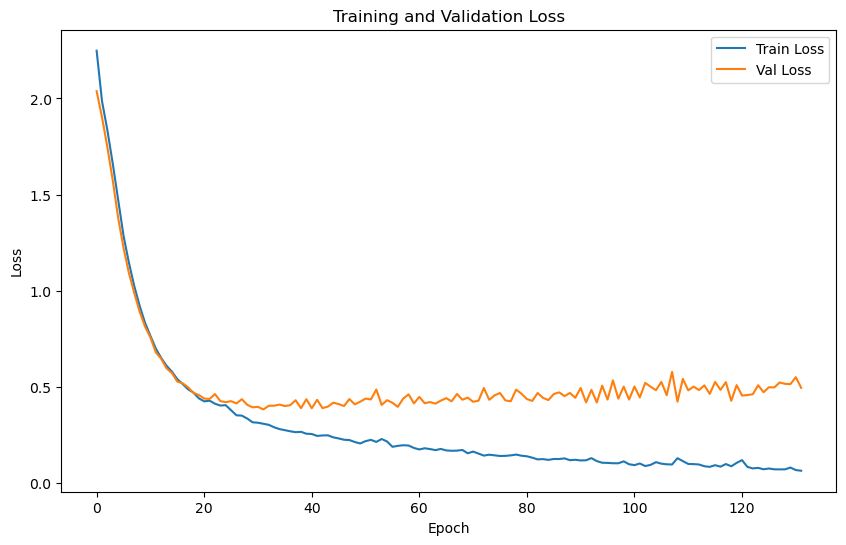

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.2262 | Test Accuracy: 73.14%


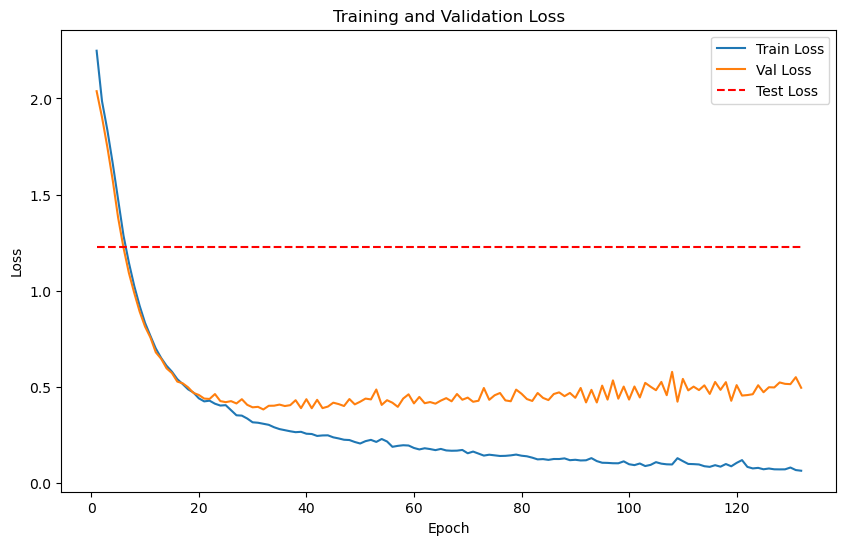

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.7709
    Batch [2/2], Train Loss: 8.6295
Epoch [1/2000], Avg Train Loss: 8.7002
Epoch [1/2000], Avg Val Loss: 4.2779
Validation loss improved from inf to 4.2779. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.6940
    Batch [2/2], Train Loss: 8.6899
Epoch [2/2000], Avg Train Loss: 8.6919
Epoch [2/2000], Avg Val Loss: 4.1873
Validation loss improved from 4.2779 to 4.1873. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.3682
    Batch [2/2], Train Loss: 8.2100
Epoch [3/2000], Avg Train Loss: 8.2891
Epoch [3/2000], Avg Val Loss: 4.1013
Validation loss improved from 4.1873 to 4.1013. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.3505
    Batch [2/2], Train Loss: 8.1699
Epoch [4/2000], Avg Train Loss: 8.2602


Epoch [4/2000], Avg Val Loss: 4.0191
Validation loss improved from 4.1013 to 4.0191. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 8.2762
    Batch [2/2], Train Loss: 7.9292
Epoch [5/2000], Avg Train Loss: 8.1027
Epoch [5/2000], Avg Val Loss: 3.9408
Validation loss improved from 4.0191 to 3.9408. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 8.0452
    Batch [2/2], Train Loss: 8.0470
Epoch [6/2000], Avg Train Loss: 8.0461
Epoch [6/2000], Avg Val Loss: 3.8662
Validation loss improved from 3.9408 to 3.8662. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 7.8912
    Batch [2/2], Train Loss: 7.8318
Epoch [7/2000], Avg Train Loss: 7.8615
Epoch [7/2000], Avg Val Loss: 3.7957
Validation loss improved from 3.8662 to 3.7957. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 7.8221
    Batch [2/2], Train Loss: 7.4857
Epoch [8/2000], Avg Train Loss: 7.6539
Epoch [8/2000], Avg Val 

    Batch [1/2], Train Loss: 7.0756
    Batch [2/2], Train Loss: 7.0936
Epoch [12/2000], Avg Train Loss: 7.0846
Epoch [12/2000], Avg Val Loss: 3.4969
Validation loss improved from 3.5501 to 3.4969. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 7.0154
    Batch [2/2], Train Loss: 6.9637
Epoch [13/2000], Avg Train Loss: 6.9895
Epoch [13/2000], Avg Val Loss: 3.4468
Validation loss improved from 3.4969 to 3.4468. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 6.8165
    Batch [2/2], Train Loss: 6.8285
Epoch [14/2000], Avg Train Loss: 6.8225
Epoch [14/2000], Avg Val Loss: 3.3997
Validation loss improved from 3.4468 to 3.3997. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 7.0246
    Batch [2/2], Train Loss: 6.6502
Epoch [15/2000], Avg Train Loss: 6.8374
Epoch [15/2000], Avg Val Loss: 3.3557
Validation loss improved from 3.3997 to 3.3557. Saving model...

LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 6.7301
    Batch [2/2], Train Loss: 6.6931
Epoch [16/2000], Avg Train Loss: 6.7116
Epoch [16/2000], Avg Val Loss: 3.3144
Validation loss improved from 3.3557 to 3.3144. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.5558
    Batch [2/2], Train Loss: 6.4601
Epoch [17/2000], Avg Train Loss: 6.5079
Epoch [17/2000], Avg Val Loss: 3.2757
Validation loss improved from 3.3144 to 3.2757. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.5956
    Batch [2/2], Train Loss: 6.5352
Epoch [18/2000], Avg Train Loss: 6.5654
Epoch [18/2000], Avg Val Loss: 3.2393
Validation loss improved from 3.2757 to 3.2393. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 6.3228
    Batch [2/2], Train Loss: 6.3968
Epoch [19/2000], Avg Train Loss: 6.3598
Epoch [19/2000], Avg Val Loss: 3.2053
Validation loss improved from 3.2393 to 3.2053. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1

Epoch [26/2000], Avg Val Loss: 3.0225
Validation loss improved from 3.0436 to 3.0225. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.7612
    Batch [2/2], Train Loss: 5.8727
Epoch [27/2000], Avg Train Loss: 5.8170
Epoch [27/2000], Avg Val Loss: 3.0027
Validation loss improved from 3.0225 to 3.0027. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.6864
    Batch [2/2], Train Loss: 5.6620
Epoch [28/2000], Avg Train Loss: 5.6742
Epoch [28/2000], Avg Val Loss: 2.9843
Validation loss improved from 3.0027 to 2.9843. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.6644
    Batch [2/2], Train Loss: 5.6354
Epoch [29/2000], Avg Train Loss: 5.6499
Epoch [29/2000], Avg Val Loss: 2.9673
Validation loss improved from 2.9843 to 2.9673. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 5.6728
    Batch [2/2], Train Loss: 5.5118
Epoch [30/2000], Avg Train Loss: 5.5923
Epoch [30/20

    Batch [1/2], Train Loss: 5.2552
    Batch [2/2], Train Loss: 5.2907
Epoch [37/2000], Avg Train Loss: 5.2730
Epoch [37/2000], Avg Val Loss: 2.8649
Validation loss improved from 2.8751 to 2.8649. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.2112
    Batch [2/2], Train Loss: 5.1417
Epoch [38/2000], Avg Train Loss: 5.1765
Epoch [38/2000], Avg Val Loss: 2.8553
Validation loss improved from 2.8649 to 2.8553. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.1738
    Batch [2/2], Train Loss: 5.2161
Epoch [39/2000], Avg Train Loss: 5.1949
Epoch [39/2000], Avg Val Loss: 2.8464
Validation loss improved from 2.8553 to 2.8464. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.1039
    Batch [2/2], Train Loss: 5.2517
Epoch [40/2000], Avg Train Loss: 5.1778
Epoch [40/2000], Avg Val Loss: 2.8378
Validation loss improved from 2.8464 to 2.8378. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.9238
    Batch [2/2], Train Loss: 4.8159
Epoch [50/2000], Avg Train Loss: 4.8698
Epoch [50/2000], Avg Val Loss: 2.7731
Validation loss improved from 2.7783 to 2.7731. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 4.8997
    Batch [2/2], Train Loss: 4.9158
Epoch [51/2000], Avg Train Loss: 4.9077
Epoch [51/2000], Avg Val Loss: 2.7679
Validation loss improved from 2.7731 to 2.7679. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 4.8597
    Batch [2/2], Train Loss: 4.9123
Epoch [52/2000], Avg Train Loss: 4.8860
Epoch [52/2000], Avg Val Loss: 2.7630
Validation loss improved from 2.7679 to 2.7630. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.8413
    Batch [2/2], Train Loss: 4.8803
Epoch [53/2000], Avg Train Loss: 4.8608
Epoch [53/2000], Avg Val Loss: 2.7580
Validation loss improved from 2.7630 to 2.7580. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.7197
Epoch [63/2000], Avg Train Loss: 4.7212
Epoch [63/2000], Avg Val Loss: 2.7142
Validation loss improved from 2.7182 to 2.7142. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.7313
    Batch [2/2], Train Loss: 4.6437
Epoch [64/2000], Avg Train Loss: 4.6875
Epoch [64/2000], Avg Val Loss: 2.7101
Validation loss improved from 2.7142 to 2.7101. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.6676
    Batch [2/2], Train Loss: 4.7315
Epoch [65/2000], Avg Train Loss: 4.6995
Epoch [65/2000], Avg Val Loss: 2.7060
Validation loss improved from 2.7101 to 2.7060. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.7181
    Batch [2/2], Train Loss: 4.6474
Epoch [66/2000], Avg Train Loss: 4.6827
Epoch [66/2000], Avg Val Loss: 2.7020
Validation loss improved from 2.7060 to 2.7020. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.6838
    Batch [2

    Batch [1/2], Train Loss: 4.6062
    Batch [2/2], Train Loss: 4.5609
Epoch [76/2000], Avg Train Loss: 4.5835
Epoch [76/2000], Avg Val Loss: 2.6637
Validation loss improved from 2.6674 to 2.6637. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.6145
    Batch [2/2], Train Loss: 4.6348
Epoch [77/2000], Avg Train Loss: 4.6246
Epoch [77/2000], Avg Val Loss: 2.6602
Validation loss improved from 2.6637 to 2.6602. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.5382
    Batch [2/2], Train Loss: 4.5725
Epoch [78/2000], Avg Train Loss: 4.5554
Epoch [78/2000], Avg Val Loss: 2.6567
Validation loss improved from 2.6602 to 2.6567. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.5331
    Batch [2/2], Train Loss: 4.5687
Epoch [79/2000], Avg Train Loss: 4.5509
Epoch [79/2000], Avg Val Loss: 2.6533
Validation loss improved from 2.6567 to 2.6533. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 4.4756
Epoch [87/2000], Avg Train Loss: 4.5022
Epoch [87/2000], Avg Val Loss: 2.6265
Validation loss improved from 2.6298 to 2.6265. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 4.4453
    Batch [2/2], Train Loss: 4.4862
Epoch [88/2000], Avg Train Loss: 4.4658
Epoch [88/2000], Avg Val Loss: 2.6233
Validation loss improved from 2.6265 to 2.6233. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 4.4602
    Batch [2/2], Train Loss: 4.4406
Epoch [89/2000], Avg Train Loss: 4.4504
Epoch [89/2000], Avg Val Loss: 2.6201
Validation loss improved from 2.6233 to 2.6201. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.5019
    Batch [2/2], Train Loss: 4.5021
Epoch [90/2000], Avg Train Loss: 4.5020
Epoch [90/2000], Avg Val Loss: 2.6170
Validation loss improved from 2.6201 to 2.6170. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.4878
    Batch [2

Epoch [98/2000], Avg Val Loss: 2.5926
Validation loss improved from 2.5957 to 2.5926. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.4362
    Batch [2/2], Train Loss: 4.4442
Epoch [99/2000], Avg Train Loss: 4.4402
Epoch [99/2000], Avg Val Loss: 2.5895
Validation loss improved from 2.5926 to 2.5895. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 4.4179
    Batch [2/2], Train Loss: 4.4341
Epoch [100/2000], Avg Train Loss: 4.4260
Epoch [100/2000], Avg Val Loss: 2.5865
Validation loss improved from 2.5895 to 2.5865. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.3723
    Batch [2/2], Train Loss: 4.4137
Epoch [101/2000], Avg Train Loss: 4.3930
Epoch [101/2000], Avg Val Loss: 2.5834
Validation loss improved from 2.5865 to 2.5834. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.4001
    Batch [2/2], Train Loss: 4.4514
Epoch [102/2000], Avg Train Loss: 4.4257
Epoc

    Batch [1/2], Train Loss: 4.3564
    Batch [2/2], Train Loss: 4.3304
Epoch [113/2000], Avg Train Loss: 4.3434
Epoch [113/2000], Avg Val Loss: 2.5484
Validation loss improved from 2.5513 to 2.5484. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 4.3987
    Batch [2/2], Train Loss: 4.3391
Epoch [114/2000], Avg Train Loss: 4.3689
Epoch [114/2000], Avg Val Loss: 2.5456
Validation loss improved from 2.5484 to 2.5456. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.3560
    Batch [2/2], Train Loss: 4.3367
Epoch [115/2000], Avg Train Loss: 4.3464
Epoch [115/2000], Avg Val Loss: 2.5428
Validation loss improved from 2.5456 to 2.5428. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.3386
    Batch [2/2], Train Loss: 4.3377
Epoch [116/2000], Avg Train Loss: 4.3381
Epoch [116/2000], Avg Val Loss: 2.5401
Validation loss improved from 2.5428 to 2.5401. Saving model...

LOG: Epoch [117/2000] - Training


Epoch [122/2000], Avg Val Loss: 2.5246
Validation loss improved from 2.5271 to 2.5246. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.3088
    Batch [2/2], Train Loss: 4.3550
Epoch [123/2000], Avg Train Loss: 4.3319
Epoch [123/2000], Avg Val Loss: 2.5220
Validation loss improved from 2.5246 to 2.5220. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 4.3067
    Batch [2/2], Train Loss: 4.2634
Epoch [124/2000], Avg Train Loss: 4.2850
Epoch [124/2000], Avg Val Loss: 2.5195
Validation loss improved from 2.5220 to 2.5195. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 4.3395
    Batch [2/2], Train Loss: 4.3214
Epoch [125/2000], Avg Train Loss: 4.3304
Epoch [125/2000], Avg Val Loss: 2.5170
Validation loss improved from 2.5195 to 2.5170. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.3118
    Batch [2/2], Train Loss: 4.3448
Epoch [126/2000], Avg Train Loss: 4.3283


    Batch [1/2], Train Loss: 4.2492
    Batch [2/2], Train Loss: 4.2942
Epoch [137/2000], Avg Train Loss: 4.2717
Epoch [137/2000], Avg Val Loss: 2.4888
Validation loss improved from 2.4911 to 2.4888. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 4.2626
    Batch [2/2], Train Loss: 4.1998
Epoch [138/2000], Avg Train Loss: 4.2312
Epoch [138/2000], Avg Val Loss: 2.4864
Validation loss improved from 2.4888 to 2.4864. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 4.2251
    Batch [2/2], Train Loss: 4.3188
Epoch [139/2000], Avg Train Loss: 4.2720
Epoch [139/2000], Avg Val Loss: 2.4841
Validation loss improved from 2.4864 to 2.4841. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 4.3143
    Batch [2/2], Train Loss: 4.2464
Epoch [140/2000], Avg Train Loss: 4.2803
Epoch [140/2000], Avg Val Loss: 2.4819
Validation loss improved from 2.4841 to 2.4819. Saving model...

LOG: Epoch [141/2000] - Training


    Batch [2/2], Train Loss: 4.1536
Epoch [147/2000], Avg Train Loss: 4.1919
Epoch [147/2000], Avg Val Loss: 2.4681
Validation loss improved from 2.4699 to 2.4681. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.2107
    Batch [2/2], Train Loss: 4.2152
Epoch [148/2000], Avg Train Loss: 4.2129
Epoch [148/2000], Avg Val Loss: 2.4663
Validation loss improved from 2.4681 to 2.4663. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 4.2032
    Batch [2/2], Train Loss: 4.2386
Epoch [149/2000], Avg Train Loss: 4.2209
Epoch [149/2000], Avg Val Loss: 2.4644
Validation loss improved from 2.4663 to 2.4644. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 4.2096
    Batch [2/2], Train Loss: 4.1749
Epoch [150/2000], Avg Train Loss: 4.1923
Epoch [150/2000], Avg Val Loss: 2.4625
Validation loss improved from 2.4644 to 2.4625. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 4.2541


Epoch [161/2000], Avg Val Loss: 2.4416
Validation loss improved from 2.4435 to 2.4416. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 4.2033
    Batch [2/2], Train Loss: 4.1814
Epoch [162/2000], Avg Train Loss: 4.1923
Epoch [162/2000], Avg Val Loss: 2.4398
Validation loss improved from 2.4416 to 2.4398. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.1308
    Batch [2/2], Train Loss: 4.1814
Epoch [163/2000], Avg Train Loss: 4.1561
Epoch [163/2000], Avg Val Loss: 2.4379
Validation loss improved from 2.4398 to 2.4379. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.1716
    Batch [2/2], Train Loss: 4.1619
Epoch [164/2000], Avg Train Loss: 4.1668
Epoch [164/2000], Avg Val Loss: 2.4361
Validation loss improved from 2.4379 to 2.4361. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 4.1238
    Batch [2/2], Train Loss: 4.0918
Epoch [165/2000], Avg Train Loss: 4.1078


    Batch [1/2], Train Loss: 4.1521
    Batch [2/2], Train Loss: 4.1579
Epoch [173/2000], Avg Train Loss: 4.1550
Epoch [173/2000], Avg Val Loss: 2.4200
Validation loss improved from 2.4216 to 2.4200. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 4.1705
    Batch [2/2], Train Loss: 4.1124
Epoch [174/2000], Avg Train Loss: 4.1415
Epoch [174/2000], Avg Val Loss: 2.4185
Validation loss improved from 2.4200 to 2.4185. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.1323
    Batch [2/2], Train Loss: 4.1603
Epoch [175/2000], Avg Train Loss: 4.1463
Epoch [175/2000], Avg Val Loss: 2.4171
Validation loss improved from 2.4185 to 2.4171. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.2160
    Batch [2/2], Train Loss: 4.0956
Epoch [176/2000], Avg Train Loss: 4.1558
Epoch [176/2000], Avg Val Loss: 2.4157
Validation loss improved from 2.4171 to 2.4157. Saving model...

LOG: Epoch [177/2000] - Training


Epoch [189/2000], Avg Val Loss: 2.3985
Validation loss improved from 2.3999 to 2.3985. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 4.0380
    Batch [2/2], Train Loss: 4.0859
Epoch [190/2000], Avg Train Loss: 4.0620
Epoch [190/2000], Avg Val Loss: 2.3970
Validation loss improved from 2.3985 to 2.3970. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 4.0712
    Batch [2/2], Train Loss: 4.0824
Epoch [191/2000], Avg Train Loss: 4.0768
Epoch [191/2000], Avg Val Loss: 2.3955
Validation loss improved from 2.3970 to 2.3955. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.0327
    Batch [2/2], Train Loss: 4.0587
Epoch [192/2000], Avg Train Loss: 4.0457
Epoch [192/2000], Avg Val Loss: 2.3941
Validation loss improved from 2.3955 to 2.3941. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.0487
    Batch [2/2], Train Loss: 4.0298
Epoch [193/2000], Avg Train Loss: 4.0393


    Batch [1/2], Train Loss: 4.0926
    Batch [2/2], Train Loss: 4.0406
Epoch [199/2000], Avg Train Loss: 4.0666
Epoch [199/2000], Avg Val Loss: 2.3850
Validation loss improved from 2.3861 to 2.3850. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.0793
    Batch [2/2], Train Loss: 4.0149
Epoch [200/2000], Avg Train Loss: 4.0471
Epoch [200/2000], Avg Val Loss: 2.3839
Validation loss improved from 2.3850 to 2.3839. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.0554
    Batch [2/2], Train Loss: 4.0824
Epoch [201/2000], Avg Train Loss: 4.0689
Epoch [201/2000], Avg Val Loss: 2.3828
Validation loss improved from 2.3839 to 2.3828. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 4.0200
    Batch [2/2], Train Loss: 4.0678
Epoch [202/2000], Avg Train Loss: 4.0439
Epoch [202/2000], Avg Val Loss: 2.3817
Validation loss improved from 2.3828 to 2.3817. Saving model...

LOG: Epoch [203/2000] - Training


    Batch [2/2], Train Loss: 4.0073
Epoch [215/2000], Avg Train Loss: 4.0244
Epoch [215/2000], Avg Val Loss: 2.3684
Validation loss improved from 2.3694 to 2.3684. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 4.0458
    Batch [2/2], Train Loss: 4.0254
Epoch [216/2000], Avg Train Loss: 4.0356
Epoch [216/2000], Avg Val Loss: 2.3676
Validation loss improved from 2.3684 to 2.3676. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.0961
    Batch [2/2], Train Loss: 4.0306
Epoch [217/2000], Avg Train Loss: 4.0634
Epoch [217/2000], Avg Val Loss: 2.3668
Validation loss improved from 2.3676 to 2.3668. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.0098
    Batch [2/2], Train Loss: 4.0693
Epoch [218/2000], Avg Train Loss: 4.0396
Epoch [218/2000], Avg Val Loss: 2.3659
Validation loss improved from 2.3668 to 2.3659. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.0383


    Batch [2/2], Train Loss: 4.0676
Epoch [224/2000], Avg Train Loss: 4.0468
Epoch [224/2000], Avg Val Loss: 2.3610
Validation loss improved from 2.3618 to 2.3610. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.0238
    Batch [2/2], Train Loss: 4.0166
Epoch [225/2000], Avg Train Loss: 4.0202
Epoch [225/2000], Avg Val Loss: 2.3602
Validation loss improved from 2.3610 to 2.3602. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 4.0184
    Batch [2/2], Train Loss: 4.0373
Epoch [226/2000], Avg Train Loss: 4.0278
Epoch [226/2000], Avg Val Loss: 2.3594
Validation loss improved from 2.3602 to 2.3594. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 4.0420
    Batch [2/2], Train Loss: 4.0085
Epoch [227/2000], Avg Train Loss: 4.0253
Epoch [227/2000], Avg Val Loss: 2.3586
Validation loss improved from 2.3594 to 2.3586. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.0005


    Batch [2/2], Train Loss: 3.9983
Epoch [241/2000], Avg Train Loss: 4.0064
Epoch [241/2000], Avg Val Loss: 2.3497
Validation loss improved from 2.3502 to 2.3497. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 3.9671
    Batch [2/2], Train Loss: 3.9730
Epoch [242/2000], Avg Train Loss: 3.9701
Epoch [242/2000], Avg Val Loss: 2.3491
Validation loss improved from 2.3497 to 2.3491. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 3.9827
    Batch [2/2], Train Loss: 4.0067
Epoch [243/2000], Avg Train Loss: 3.9947
Epoch [243/2000], Avg Val Loss: 2.3485
Validation loss improved from 2.3491 to 2.3485. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 3.9621
    Batch [2/2], Train Loss: 3.9784
Epoch [244/2000], Avg Train Loss: 3.9703
Epoch [244/2000], Avg Val Loss: 2.3479
Validation loss improved from 2.3485 to 2.3479. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 3.9793


    Batch [1/2], Train Loss: 3.9562
    Batch [2/2], Train Loss: 3.9616
Epoch [249/2000], Avg Train Loss: 3.9589
Epoch [249/2000], Avg Val Loss: 2.3442
Validation loss improved from 2.3450 to 2.3442. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 3.9872
    Batch [2/2], Train Loss: 3.9751
Epoch [250/2000], Avg Train Loss: 3.9811
Epoch [250/2000], Avg Val Loss: 2.3434
Validation loss improved from 2.3442 to 2.3434. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 3.9854
    Batch [2/2], Train Loss: 3.9828
Epoch [251/2000], Avg Train Loss: 3.9841
Epoch [251/2000], Avg Val Loss: 2.3426
Validation loss improved from 2.3434 to 2.3426. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 4.0122
    Batch [2/2], Train Loss: 3.9576
Epoch [252/2000], Avg Train Loss: 3.9849
Epoch [252/2000], Avg Val Loss: 2.3419
Validation loss improved from 2.3426 to 2.3419. Saving model...

LOG: Epoch [253/2000] - Training


    Batch [2/2], Train Loss: 3.9396
Epoch [266/2000], Avg Train Loss: 3.9530
Epoch [266/2000], Avg Val Loss: 2.3322
Validation loss improved from 2.3326 to 2.3322. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 3.9169
    Batch [2/2], Train Loss: 3.9674
Epoch [267/2000], Avg Train Loss: 3.9421
Epoch [267/2000], Avg Val Loss: 2.3317
Validation loss improved from 2.3322 to 2.3317. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 3.9547
    Batch [2/2], Train Loss: 3.9317
Epoch [268/2000], Avg Train Loss: 3.9432
Epoch [268/2000], Avg Val Loss: 2.3313
Validation loss improved from 2.3317 to 2.3313. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 3.9832
    Batch [2/2], Train Loss: 3.9830
Epoch [269/2000], Avg Train Loss: 3.9831
Epoch [269/2000], Avg Val Loss: 2.3310
Validation loss improved from 2.3313 to 2.3310. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 3.9552


    Batch [2/2], Train Loss: 3.9361
Epoch [273/2000], Avg Train Loss: 3.9582
Epoch [273/2000], Avg Val Loss: 2.3299
Validation loss improved from 2.3302 to 2.3299. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 3.8946
    Batch [2/2], Train Loss: 3.9400
Epoch [274/2000], Avg Train Loss: 3.9173
Epoch [274/2000], Avg Val Loss: 2.3294
Validation loss improved from 2.3299 to 2.3294. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 3.9292
    Batch [2/2], Train Loss: 3.9722
Epoch [275/2000], Avg Train Loss: 3.9507
Epoch [275/2000], Avg Val Loss: 2.3290
Validation loss improved from 2.3294 to 2.3290. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 3.9602
    Batch [2/2], Train Loss: 3.9353
Epoch [276/2000], Avg Train Loss: 3.9478
Epoch [276/2000], Avg Val Loss: 2.3285
Validation loss improved from 2.3290 to 2.3285. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 3.9401


    Batch [2/2], Train Loss: 3.8742
Epoch [291/2000], Avg Train Loss: 3.9132
Epoch [291/2000], Avg Val Loss: 2.3213
Validation loss improved from 2.3217 to 2.3213. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 3.9060
    Batch [2/2], Train Loss: 3.8986
Epoch [292/2000], Avg Train Loss: 3.9023
Epoch [292/2000], Avg Val Loss: 2.3209
Validation loss improved from 2.3213 to 2.3209. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 3.9038
    Batch [2/2], Train Loss: 3.9470
Epoch [293/2000], Avg Train Loss: 3.9254
Epoch [293/2000], Avg Val Loss: 2.3206
Validation loss improved from 2.3209 to 2.3206. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 3.9525
    Batch [2/2], Train Loss: 3.9161
Epoch [294/2000], Avg Train Loss: 3.9343
Epoch [294/2000], Avg Val Loss: 2.3203
Validation loss improved from 2.3206 to 2.3203. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 3.8880


    Batch [2/2], Train Loss: 3.8965
Epoch [298/2000], Avg Train Loss: 3.9018
Epoch [298/2000], Avg Val Loss: 2.3186
Validation loss improved from 2.3190 to 2.3186. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 3.9111
    Batch [2/2], Train Loss: 3.9036
Epoch [299/2000], Avg Train Loss: 3.9074
Epoch [299/2000], Avg Val Loss: 2.3181
Validation loss improved from 2.3186 to 2.3181. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 3.8578
    Batch [2/2], Train Loss: 3.9574
Epoch [300/2000], Avg Train Loss: 3.9076
Epoch [300/2000], Avg Val Loss: 2.3176
Validation loss improved from 2.3181 to 2.3176. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 3.9022
    Batch [2/2], Train Loss: 3.8840
Epoch [301/2000], Avg Train Loss: 3.8931
Epoch [301/2000], Avg Val Loss: 2.3173
Validation loss improved from 2.3176 to 2.3173. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 3.8712


    Batch [1/2], Train Loss: 3.8995
    Batch [2/2], Train Loss: 3.8619
Epoch [318/2000], Avg Train Loss: 3.8807
Epoch [318/2000], Avg Val Loss: 2.3097
Validation loss improved from 2.3103 to 2.3097. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 3.9201
    Batch [2/2], Train Loss: 3.9051
Epoch [319/2000], Avg Train Loss: 3.9126
Epoch [319/2000], Avg Val Loss: 2.3093
Validation loss improved from 2.3097 to 2.3093. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.9157
    Batch [2/2], Train Loss: 3.8767
Epoch [320/2000], Avg Train Loss: 3.8962
Epoch [320/2000], Avg Val Loss: 2.3089
Validation loss improved from 2.3093 to 2.3089. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 3.8663
    Batch [2/2], Train Loss: 3.8485
Epoch [321/2000], Avg Train Loss: 3.8574
Epoch [321/2000], Avg Val Loss: 2.3085
Validation loss improved from 2.3089 to 2.3085. Saving model...

LOG: Epoch [322/2000] - Training


    Batch [2/2], Train Loss: 3.8855
Epoch [326/2000], Avg Train Loss: 3.8876
Epoch [326/2000], Avg Val Loss: 2.3065
Validation loss improved from 2.3069 to 2.3065. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 3.9326
    Batch [2/2], Train Loss: 3.8648
Epoch [327/2000], Avg Train Loss: 3.8987
Epoch [327/2000], Avg Val Loss: 2.3062
Validation loss improved from 2.3065 to 2.3062. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 3.8967
    Batch [2/2], Train Loss: 3.8451
Epoch [328/2000], Avg Train Loss: 3.8709
Epoch [328/2000], Avg Val Loss: 2.3060
Validation loss improved from 2.3062 to 2.3060. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.9229
    Batch [2/2], Train Loss: 3.8938
Epoch [329/2000], Avg Train Loss: 3.9083
Epoch [329/2000], Avg Val Loss: 2.3058
Validation loss improved from 2.3060 to 2.3058. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.8772


    Batch [1/2], Train Loss: 3.8636
    Batch [2/2], Train Loss: 3.8469
Epoch [341/2000], Avg Train Loss: 3.8552
Epoch [341/2000], Avg Val Loss: 2.3006
Validation loss improved from 2.3012 to 2.3006. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 3.8329
    Batch [2/2], Train Loss: 3.8800
Epoch [342/2000], Avg Train Loss: 3.8565
Epoch [342/2000], Avg Val Loss: 2.3002
Validation loss improved from 2.3006 to 2.3002. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.8418
    Batch [2/2], Train Loss: 3.8519
Epoch [343/2000], Avg Train Loss: 3.8468
Epoch [343/2000], Avg Val Loss: 2.2997
Validation loss improved from 2.3002 to 2.2997. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.8659
    Batch [2/2], Train Loss: 3.8146
Epoch [344/2000], Avg Train Loss: 3.8402
Epoch [344/2000], Avg Val Loss: 2.2992
Validation loss improved from 2.2997 to 2.2992. Saving model...

LOG: Epoch [345/2000] - Training


Epoch [349/2000], Avg Val Loss: 2.2966
Validation loss improved from 2.2972 to 2.2966. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 3.7963
    Batch [2/2], Train Loss: 3.8531
Epoch [350/2000], Avg Train Loss: 3.8247
Epoch [350/2000], Avg Val Loss: 2.2959
Validation loss improved from 2.2966 to 2.2959. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 3.8912
    Batch [2/2], Train Loss: 3.8255
Epoch [351/2000], Avg Train Loss: 3.8583
Epoch [351/2000], Avg Val Loss: 2.2953
Validation loss improved from 2.2959 to 2.2953. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 3.8752
    Batch [2/2], Train Loss: 3.8817
Epoch [352/2000], Avg Train Loss: 3.8784
Epoch [352/2000], Avg Val Loss: 2.2948
Validation loss improved from 2.2953 to 2.2948. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 3.8500
    Batch [2/2], Train Loss: 3.7780
Epoch [353/2000], Avg Train Loss: 3.8140


    Batch [2/2], Train Loss: 3.8391
Epoch [366/2000], Avg Train Loss: 3.8520
Epoch [366/2000], Avg Val Loss: 2.2906
Validation loss improved from 2.2908 to 2.2906. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 3.8379
    Batch [2/2], Train Loss: 3.8794
Epoch [367/2000], Avg Train Loss: 3.8586
Epoch [367/2000], Avg Val Loss: 2.2903
Validation loss improved from 2.2906 to 2.2903. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.8109
    Batch [2/2], Train Loss: 3.7709
Epoch [368/2000], Avg Train Loss: 3.7909
Epoch [368/2000], Avg Val Loss: 2.2900
Validation loss improved from 2.2903 to 2.2900. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.8372
    Batch [2/2], Train Loss: 3.8097
Epoch [369/2000], Avg Train Loss: 3.8235
Epoch [369/2000], Avg Val Loss: 2.2896
Validation loss improved from 2.2900 to 2.2896. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.8683


    Batch [1/2], Train Loss: 3.8692
    Batch [2/2], Train Loss: 3.8370
Epoch [377/2000], Avg Train Loss: 3.8531
Epoch [377/2000], Avg Val Loss: 2.2866
Validation loss improved from 2.2869 to 2.2866. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 3.8156
    Batch [2/2], Train Loss: 3.8247
Epoch [378/2000], Avg Train Loss: 3.8201
Epoch [378/2000], Avg Val Loss: 2.2864
Validation loss improved from 2.2866 to 2.2864. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 3.8497
    Batch [2/2], Train Loss: 3.8487
Epoch [379/2000], Avg Train Loss: 3.8492
Epoch [379/2000], Avg Val Loss: 2.2862
Validation loss improved from 2.2864 to 2.2862. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 3.7839
    Batch [2/2], Train Loss: 3.8404
Epoch [380/2000], Avg Train Loss: 3.8122
Epoch [380/2000], Avg Val Loss: 2.2858
Validation loss improved from 2.2862 to 2.2858. Saving model...

LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 3.8254
    Batch [2/2], Train Loss: 3.7792
Epoch [390/2000], Avg Train Loss: 3.8023
Epoch [390/2000], Avg Val Loss: 2.2818
Validation loss improved from 2.2824 to 2.2818. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 3.8194
    Batch [2/2], Train Loss: 3.8096
Epoch [391/2000], Avg Train Loss: 3.8145
Epoch [391/2000], Avg Val Loss: 2.2813
Validation loss improved from 2.2818 to 2.2813. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 3.8380
    Batch [2/2], Train Loss: 3.8591
Epoch [392/2000], Avg Train Loss: 3.8485
Epoch [392/2000], Avg Val Loss: 2.2809
Validation loss improved from 2.2813 to 2.2809. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.8364
    Batch [2/2], Train Loss: 3.8471
Epoch [393/2000], Avg Train Loss: 3.8418
Epoch [393/2000], Avg Val Loss: 2.2806
Validation loss improved from 2.2809 to 2.2806. Saving model...

LOG: Epoch [394/2000] - Training


Epoch [401/2000], Avg Val Loss: 2.2786
Validation loss improved from 2.2789 to 2.2786. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 3.8223
    Batch [2/2], Train Loss: 3.8035
Epoch [402/2000], Avg Train Loss: 3.8129
Epoch [402/2000], Avg Val Loss: 2.2784
Validation loss improved from 2.2786 to 2.2784. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 3.8078
    Batch [2/2], Train Loss: 3.8158
Epoch [403/2000], Avg Train Loss: 3.8118
Epoch [403/2000], Avg Val Loss: 2.2781
Validation loss improved from 2.2784 to 2.2781. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 3.7736
    Batch [2/2], Train Loss: 3.7873
Epoch [404/2000], Avg Train Loss: 3.7804
Epoch [404/2000], Avg Val Loss: 2.2779
Validation loss improved from 2.2781 to 2.2779. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.7932
    Batch [2/2], Train Loss: 3.7379
Epoch [405/2000], Avg Train Loss: 3.7655


    Batch [1/2], Train Loss: 3.7591
    Batch [2/2], Train Loss: 3.7774
Epoch [417/2000], Avg Train Loss: 3.7682
Epoch [417/2000], Avg Val Loss: 2.2749
Validation loss improved from 2.2753 to 2.2749. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 3.7843
    Batch [2/2], Train Loss: 3.7258
Epoch [418/2000], Avg Train Loss: 3.7551
Epoch [418/2000], Avg Val Loss: 2.2746
Validation loss improved from 2.2749 to 2.2746. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 3.8410
    Batch [2/2], Train Loss: 3.7304
Epoch [419/2000], Avg Train Loss: 3.7857
Epoch [419/2000], Avg Val Loss: 2.2743
Validation loss improved from 2.2746 to 2.2743. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.7709
    Batch [2/2], Train Loss: 3.8073
Epoch [420/2000], Avg Train Loss: 3.7891
Epoch [420/2000], Avg Val Loss: 2.2739
Validation loss improved from 2.2743 to 2.2739. Saving model...

LOG: Epoch [421/2000] - Training


    Batch [2/2], Train Loss: 3.7549
Epoch [428/2000], Avg Train Loss: 3.7555
Epoch [428/2000], Avg Val Loss: 2.2720
Validation loss improved from 2.2722 to 2.2720. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 3.7811
    Batch [2/2], Train Loss: 3.8037
Epoch [429/2000], Avg Train Loss: 3.7924
Epoch [429/2000], Avg Val Loss: 2.2717
Validation loss improved from 2.2720 to 2.2717. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 3.7417
    Batch [2/2], Train Loss: 3.7686
Epoch [430/2000], Avg Train Loss: 3.7552
Epoch [430/2000], Avg Val Loss: 2.2714
Validation loss improved from 2.2717 to 2.2714. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 3.7848
    Batch [2/2], Train Loss: 3.8691
Epoch [431/2000], Avg Train Loss: 3.8270
Epoch [431/2000], Avg Val Loss: 2.2713
Validation loss improved from 2.2714 to 2.2713. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 3.7901


Epoch [442/2000], Avg Val Loss: 2.2688
Validation loss improved from 2.2691 to 2.2688. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 3.7372
    Batch [2/2], Train Loss: 3.7159
Epoch [443/2000], Avg Train Loss: 3.7265
Epoch [443/2000], Avg Val Loss: 2.2685
Validation loss improved from 2.2688 to 2.2685. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 3.7555
    Batch [2/2], Train Loss: 3.7744
Epoch [444/2000], Avg Train Loss: 3.7649
Epoch [444/2000], Avg Val Loss: 2.2683
Validation loss improved from 2.2685 to 2.2683. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 3.7910
    Batch [2/2], Train Loss: 3.7828
Epoch [445/2000], Avg Train Loss: 3.7869
Epoch [445/2000], Avg Val Loss: 2.2682
Validation loss improved from 2.2683 to 2.2682. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 3.7725
    Batch [2/2], Train Loss: 3.7473
Epoch [446/2000], Avg Train Loss: 3.7599


    Batch [1/2], Train Loss: 3.7303
    Batch [2/2], Train Loss: 3.7382
Epoch [453/2000], Avg Train Loss: 3.7342
Epoch [453/2000], Avg Val Loss: 2.2668
Validation loss improved from 2.2670 to 2.2668. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 3.7488
    Batch [2/2], Train Loss: 3.7816
Epoch [454/2000], Avg Train Loss: 3.7652
Epoch [454/2000], Avg Val Loss: 2.2664
Validation loss improved from 2.2668 to 2.2664. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 3.7117
    Batch [2/2], Train Loss: 3.8009
Epoch [455/2000], Avg Train Loss: 3.7563
Epoch [455/2000], Avg Val Loss: 2.2660
Validation loss improved from 2.2664 to 2.2660. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 3.7555
    Batch [2/2], Train Loss: 3.7807
Epoch [456/2000], Avg Train Loss: 3.7681
Epoch [456/2000], Avg Val Loss: 2.2658
Validation loss improved from 2.2660 to 2.2658. Saving model...

LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 3.7475
    Batch [2/2], Train Loss: 3.7932
Epoch [466/2000], Avg Train Loss: 3.7704
Epoch [466/2000], Avg Val Loss: 2.2636
Validation loss improved from 2.2638 to 2.2636. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.7919
    Batch [2/2], Train Loss: 3.7221
Epoch [467/2000], Avg Train Loss: 3.7570
Epoch [467/2000], Avg Val Loss: 2.2635
Validation loss improved from 2.2636 to 2.2635. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 3.7393
    Batch [2/2], Train Loss: 3.7716
Epoch [468/2000], Avg Train Loss: 3.7555
Epoch [468/2000], Avg Val Loss: 2.2633
Validation loss improved from 2.2635 to 2.2633. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 3.7383
    Batch [2/2], Train Loss: 3.7206
Epoch [469/2000], Avg Train Loss: 3.7295
Epoch [469/2000], Avg Val Loss: 2.2630
Validation loss improved from 2.2633 to 2.2630. Saving model...

LOG: Epoch [470/2000] - Training


    Batch [2/2], Train Loss: 3.7406
Epoch [477/2000], Avg Train Loss: 3.7835
Epoch [477/2000], Avg Val Loss: 2.2612
Validation loss improved from 2.2613 to 2.2612. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 3.7412
    Batch [2/2], Train Loss: 3.7471
Epoch [478/2000], Avg Train Loss: 3.7442
Epoch [478/2000], Avg Val Loss: 2.2612
Validation loss improved from 2.2612 to 2.2612. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 3.7424
    Batch [2/2], Train Loss: 3.7492
Epoch [479/2000], Avg Train Loss: 3.7458
Epoch [479/2000], Avg Val Loss: 2.2611
Validation loss improved from 2.2612 to 2.2611. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 3.7462
    Batch [2/2], Train Loss: 3.7418
Epoch [480/2000], Avg Train Loss: 3.7440
Epoch [480/2000], Avg Val Loss: 2.2610
Validation loss improved from 2.2611 to 2.2610. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 3.7308


    Batch [1/2], Train Loss: 3.7183
    Batch [2/2], Train Loss: 3.7423
Epoch [490/2000], Avg Train Loss: 3.7303
Epoch [490/2000], Avg Val Loss: 2.2585
Validation loss improved from 2.2587 to 2.2585. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.7549
    Batch [2/2], Train Loss: 3.7092
Epoch [491/2000], Avg Train Loss: 3.7320
Epoch [491/2000], Avg Val Loss: 2.2584
Validation loss improved from 2.2585 to 2.2584. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.7572
    Batch [2/2], Train Loss: 3.7889
Epoch [492/2000], Avg Train Loss: 3.7730
Epoch [492/2000], Avg Val Loss: 2.2582
Validation loss improved from 2.2584 to 2.2582. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 3.7185
    Batch [2/2], Train Loss: 3.7497
Epoch [493/2000], Avg Train Loss: 3.7341
Epoch [493/2000], Avg Val Loss: 2.2579
Validation loss improved from 2.2582 to 2.2579. Saving model...

LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 3.7459
    Batch [2/2], Train Loss: 3.6956
Epoch [503/2000], Avg Train Loss: 3.7208
Epoch [503/2000], Avg Val Loss: 2.2554
Validation loss improved from 2.2555 to 2.2554. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 3.7751
    Batch [2/2], Train Loss: 3.7559
Epoch [504/2000], Avg Train Loss: 3.7655
Epoch [504/2000], Avg Val Loss: 2.2551
Validation loss improved from 2.2554 to 2.2551. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 3.7643
    Batch [2/2], Train Loss: 3.7571
Epoch [505/2000], Avg Train Loss: 3.7607
Epoch [505/2000], Avg Val Loss: 2.2547
Validation loss improved from 2.2551 to 2.2547. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 3.7019
    Batch [2/2], Train Loss: 3.7889
Epoch [506/2000], Avg Train Loss: 3.7454
Epoch [506/2000], Avg Val Loss: 2.2543
Validation loss improved from 2.2547 to 2.2543. Saving model...

LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 3.7384
    Batch [2/2], Train Loss: 3.7431
Epoch [514/2000], Avg Train Loss: 3.7407
Epoch [514/2000], Avg Val Loss: 2.2523
Validation loss improved from 2.2524 to 2.2523. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 3.7782
    Batch [2/2], Train Loss: 3.6895
Epoch [515/2000], Avg Train Loss: 3.7339
Epoch [515/2000], Avg Val Loss: 2.2524
Validation loss did not improve. Patience: 1/100

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.7474
    Batch [2/2], Train Loss: 3.7432
Epoch [516/2000], Avg Train Loss: 3.7453
Epoch [516/2000], Avg Val Loss: 2.2524
Validation loss did not improve. Patience: 2/100

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.7024
    Batch [2/2], Train Loss: 3.7745
Epoch [517/2000], Avg Train Loss: 3.7385
Epoch [517/2000], Avg Val Loss: 2.2525
Validation loss did not improve. Patience: 3/100

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.7527
    Batch

    Batch [2/2], Train Loss: 3.6945
Epoch [529/2000], Avg Train Loss: 3.6762
Epoch [529/2000], Avg Val Loss: 2.2505
Validation loss improved from 2.2506 to 2.2505. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 3.7135
    Batch [2/2], Train Loss: 3.7608
Epoch [530/2000], Avg Train Loss: 3.7372
Epoch [530/2000], Avg Val Loss: 2.2502
Validation loss improved from 2.2505 to 2.2502. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 3.7036
    Batch [2/2], Train Loss: 3.7032
Epoch [531/2000], Avg Train Loss: 3.7034
Epoch [531/2000], Avg Val Loss: 2.2500
Validation loss improved from 2.2502 to 2.2500. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 3.7071
    Batch [2/2], Train Loss: 3.7257
Epoch [532/2000], Avg Train Loss: 3.7164
Epoch [532/2000], Avg Val Loss: 2.2499
Validation loss improved from 2.2500 to 2.2499. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 3.7466


    Batch [1/2], Train Loss: 3.7098
    Batch [2/2], Train Loss: 3.7105
Epoch [539/2000], Avg Train Loss: 3.7101
Epoch [539/2000], Avg Val Loss: 2.2496
Validation loss did not improve. Patience: 2/100

LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 3.7058
    Batch [2/2], Train Loss: 3.6817
Epoch [540/2000], Avg Train Loss: 3.6937
Epoch [540/2000], Avg Val Loss: 2.2496
Validation loss did not improve. Patience: 3/100

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 3.7283
    Batch [2/2], Train Loss: 3.6823
Epoch [541/2000], Avg Train Loss: 3.7053
Epoch [541/2000], Avg Val Loss: 2.2494
Validation loss improved from 2.2496 to 2.2494. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.7340
    Batch [2/2], Train Loss: 3.7027
Epoch [542/2000], Avg Train Loss: 3.7183
Epoch [542/2000], Avg Val Loss: 2.2492
Validation loss improved from 2.2494 to 2.2492. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.6832
    Batch [2/2], Train Loss: 3.7628
Epoch [557/2000], Avg Train Loss: 3.7230
Epoch [557/2000], Avg Val Loss: 2.2471
Validation loss improved from 2.2476 to 2.2471. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 3.7090
    Batch [2/2], Train Loss: 3.7104
Epoch [558/2000], Avg Train Loss: 3.7097
Epoch [558/2000], Avg Val Loss: 2.2464
Validation loss improved from 2.2471 to 2.2464. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 3.6945
    Batch [2/2], Train Loss: 3.6678
Epoch [559/2000], Avg Train Loss: 3.6812
Epoch [559/2000], Avg Val Loss: 2.2458
Validation loss improved from 2.2464 to 2.2458. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 3.6994
    Batch [2/2], Train Loss: 3.7189
Epoch [560/2000], Avg Train Loss: 3.7091
Epoch [560/2000], Avg Val Loss: 2.2451
Validation loss improved from 2.2458 to 2.2451. Saving model...

LOG: Epoch [561/2000] - Training


Epoch [565/2000], Avg Val Loss: 2.2423
Validation loss improved from 2.2428 to 2.2423. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 3.6537
    Batch [2/2], Train Loss: 3.7281
Epoch [566/2000], Avg Train Loss: 3.6909
Epoch [566/2000], Avg Val Loss: 2.2418
Validation loss improved from 2.2423 to 2.2418. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 3.7084
    Batch [2/2], Train Loss: 3.7376
Epoch [567/2000], Avg Train Loss: 3.7230
Epoch [567/2000], Avg Val Loss: 2.2415
Validation loss improved from 2.2418 to 2.2415. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 3.7050
    Batch [2/2], Train Loss: 3.6526
Epoch [568/2000], Avg Train Loss: 3.6788
Epoch [568/2000], Avg Val Loss: 2.2413
Validation loss improved from 2.2415 to 2.2413. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 3.7170
    Batch [2/2], Train Loss: 3.7731
Epoch [569/2000], Avg Train Loss: 3.7450


    Batch [2/2], Train Loss: 3.6819
Epoch [581/2000], Avg Train Loss: 3.6890
Epoch [581/2000], Avg Val Loss: 2.2386
Validation loss improved from 2.2386 to 2.2386. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 3.7705
    Batch [2/2], Train Loss: 3.6801
Epoch [582/2000], Avg Train Loss: 3.7253
Epoch [582/2000], Avg Val Loss: 2.2386
Validation loss did not improve. Patience: 1/100

LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 3.7226
    Batch [2/2], Train Loss: 3.7050
Epoch [583/2000], Avg Train Loss: 3.7138
Epoch [583/2000], Avg Val Loss: 2.2385
Validation loss improved from 2.2386 to 2.2385. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 3.6618
    Batch [2/2], Train Loss: 3.6404
Epoch [584/2000], Avg Train Loss: 3.6511
Epoch [584/2000], Avg Val Loss: 2.2383
Validation loss improved from 2.2385 to 2.2383. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 3.6977
    Batch [2/2]

    Batch [1/2], Train Loss: 3.6700
    Batch [2/2], Train Loss: 3.6751
Epoch [590/2000], Avg Train Loss: 3.6725
Epoch [590/2000], Avg Val Loss: 2.2366
Validation loss improved from 2.2368 to 2.2366. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 3.7096
    Batch [2/2], Train Loss: 3.6732
Epoch [591/2000], Avg Train Loss: 3.6914
Epoch [591/2000], Avg Val Loss: 2.2363
Validation loss improved from 2.2366 to 2.2363. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 3.6718
    Batch [2/2], Train Loss: 3.6545
Epoch [592/2000], Avg Train Loss: 3.6632
Epoch [592/2000], Avg Val Loss: 2.2359
Validation loss improved from 2.2363 to 2.2359. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/2], Train Loss: 3.6585
    Batch [2/2], Train Loss: 3.7013
Epoch [593/2000], Avg Train Loss: 3.6799
Epoch [593/2000], Avg Val Loss: 2.2352
Validation loss improved from 2.2359 to 2.2352. Saving model...

LOG: Epoch [594/2000] - Training


    Batch [2/2], Train Loss: 3.6646
Epoch [606/2000], Avg Train Loss: 3.6801
Epoch [606/2000], Avg Val Loss: 2.2314
Validation loss improved from 2.2315 to 2.2314. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 3.6939
    Batch [2/2], Train Loss: 3.6358
Epoch [607/2000], Avg Train Loss: 3.6648
Epoch [607/2000], Avg Val Loss: 2.2313
Validation loss improved from 2.2314 to 2.2313. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/2], Train Loss: 3.6676
    Batch [2/2], Train Loss: 3.6945
Epoch [608/2000], Avg Train Loss: 3.6811
Epoch [608/2000], Avg Val Loss: 2.2312
Validation loss improved from 2.2313 to 2.2312. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 3.7377
    Batch [2/2], Train Loss: 3.6252
Epoch [609/2000], Avg Train Loss: 3.6814
Epoch [609/2000], Avg Val Loss: 2.2309
Validation loss improved from 2.2312 to 2.2309. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 3.6223


    Batch [1/2], Train Loss: 3.6609
    Batch [2/2], Train Loss: 3.6461
Epoch [615/2000], Avg Train Loss: 3.6535
Epoch [615/2000], Avg Val Loss: 2.2293
Validation loss improved from 2.2297 to 2.2293. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 3.6707
    Batch [2/2], Train Loss: 3.7263
Epoch [616/2000], Avg Train Loss: 3.6985
Epoch [616/2000], Avg Val Loss: 2.2288
Validation loss improved from 2.2293 to 2.2288. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 3.6416
    Batch [2/2], Train Loss: 3.6589
Epoch [617/2000], Avg Train Loss: 3.6503
Epoch [617/2000], Avg Val Loss: 2.2284
Validation loss improved from 2.2288 to 2.2284. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 3.6892
    Batch [2/2], Train Loss: 3.6752
Epoch [618/2000], Avg Train Loss: 3.6822
Epoch [618/2000], Avg Val Loss: 2.2279
Validation loss improved from 2.2284 to 2.2279. Saving model...

LOG: Epoch [619/2000] - Training


    Batch [2/2], Train Loss: 3.6493
Epoch [621/2000], Avg Train Loss: 3.6869
Epoch [621/2000], Avg Val Loss: 2.2268
Validation loss improved from 2.2271 to 2.2268. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 3.7104
    Batch [2/2], Train Loss: 3.6945
Epoch [622/2000], Avg Train Loss: 3.7025
Epoch [622/2000], Avg Val Loss: 2.2264
Validation loss improved from 2.2268 to 2.2264. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/2], Train Loss: 3.6477
    Batch [2/2], Train Loss: 3.6936
Epoch [623/2000], Avg Train Loss: 3.6707
Epoch [623/2000], Avg Val Loss: 2.2261
Validation loss improved from 2.2264 to 2.2261. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 3.6728
    Batch [2/2], Train Loss: 3.6553
Epoch [624/2000], Avg Train Loss: 3.6640
Epoch [624/2000], Avg Val Loss: 2.2260
Validation loss improved from 2.2261 to 2.2260. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.6468


    Batch [1/2], Train Loss: 3.6951
    Batch [2/2], Train Loss: 3.6578
Epoch [627/2000], Avg Train Loss: 3.6764
Epoch [627/2000], Avg Val Loss: 2.2262
Validation loss did not improve. Patience: 2/100

LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 3.6250
    Batch [2/2], Train Loss: 3.6917
Epoch [628/2000], Avg Train Loss: 3.6583
Epoch [628/2000], Avg Val Loss: 2.2262
Validation loss did not improve. Patience: 3/100

LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 3.6249
    Batch [2/2], Train Loss: 3.6723
Epoch [629/2000], Avg Train Loss: 3.6486
Epoch [629/2000], Avg Val Loss: 2.2261
Validation loss did not improve. Patience: 4/100

LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 3.6542
    Batch [2/2], Train Loss: 3.6953
Epoch [630/2000], Avg Train Loss: 3.6747
Epoch [630/2000], Avg Val Loss: 2.2261
Validation loss did not improve. Patience: 5/100

LOG: Epoch [631/2000] - Training
    Batch [1/2], Train Loss: 3.6429
    Batch [2/2], Train L

Epoch [647/2000], Avg Val Loss: 2.2271
Validation loss did not improve. Patience: 15/100

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.6546
    Batch [2/2], Train Loss: 3.6825
Epoch [648/2000], Avg Train Loss: 3.6685
Epoch [648/2000], Avg Val Loss: 2.2269
Validation loss did not improve. Patience: 16/100

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 3.6740
    Batch [2/2], Train Loss: 3.7113
Epoch [649/2000], Avg Train Loss: 3.6927
Epoch [649/2000], Avg Val Loss: 2.2267
Validation loss did not improve. Patience: 17/100

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 3.6258
    Batch [2/2], Train Loss: 3.6843
Epoch [650/2000], Avg Train Loss: 3.6550
Epoch [650/2000], Avg Val Loss: 2.2264
Validation loss did not improve. Patience: 18/100

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.6371
    Batch [2/2], Train Loss: 3.6215
Epoch [651/2000], Avg Train Loss: 3.6293
Epoch [651/2000], Avg Val Loss: 2.2261
Validation loss d

    Batch [1/2], Train Loss: 3.6182
    Batch [2/2], Train Loss: 3.6259
Epoch [653/2000], Avg Train Loss: 3.6220
Epoch [653/2000], Avg Val Loss: 2.2253
Validation loss improved from 2.2258 to 2.2253. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 3.6576
    Batch [2/2], Train Loss: 3.6215
Epoch [654/2000], Avg Train Loss: 3.6396
Epoch [654/2000], Avg Val Loss: 2.2250
Validation loss improved from 2.2253 to 2.2250. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 3.6338
    Batch [2/2], Train Loss: 3.6038
Epoch [655/2000], Avg Train Loss: 3.6188
Epoch [655/2000], Avg Val Loss: 2.2246
Validation loss improved from 2.2250 to 2.2246. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 3.6555
    Batch [2/2], Train Loss: 3.6412
Epoch [656/2000], Avg Train Loss: 3.6484
Epoch [656/2000], Avg Val Loss: 2.2243
Validation loss improved from 2.2246 to 2.2243. Saving model...

LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 3.6263
    Batch [2/2], Train Loss: 3.6307
Epoch [671/2000], Avg Train Loss: 3.6285
Epoch [671/2000], Avg Val Loss: 2.2218
Validation loss did not improve. Patience: 4/100

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.6505
    Batch [2/2], Train Loss: 3.6746
Epoch [672/2000], Avg Train Loss: 3.6625
Epoch [672/2000], Avg Val Loss: 2.2219
Validation loss did not improve. Patience: 5/100

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 3.6654
    Batch [2/2], Train Loss: 3.6644
Epoch [673/2000], Avg Train Loss: 3.6649
Epoch [673/2000], Avg Val Loss: 2.2222
Validation loss did not improve. Patience: 6/100

LOG: Epoch [674/2000] - Training
    Batch [1/2], Train Loss: 3.6390
    Batch [2/2], Train Loss: 3.6661
Epoch [674/2000], Avg Train Loss: 3.6525
Epoch [674/2000], Avg Val Loss: 2.2223
Validation loss did not improve. Patience: 7/100

LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 3.6949
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.6011
Epoch [677/2000], Avg Train Loss: 3.6094
Epoch [677/2000], Avg Val Loss: 2.2215
Validation loss improved from 2.2217 to 2.2215. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 3.6802
    Batch [2/2], Train Loss: 3.6577
Epoch [678/2000], Avg Train Loss: 3.6690
Epoch [678/2000], Avg Val Loss: 2.2211
Validation loss improved from 2.2215 to 2.2211. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 3.6042
    Batch [2/2], Train Loss: 3.6054
Epoch [679/2000], Avg Train Loss: 3.6048
Epoch [679/2000], Avg Val Loss: 2.2206
Validation loss improved from 2.2211 to 2.2206. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 3.5983
    Batch [2/2], Train Loss: 3.6344
Epoch [680/2000], Avg Train Loss: 3.6163
Epoch [680/2000], Avg Val Loss: 2.2199
Validation loss improved from 2.2206 to 2.2199. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/2], Train Loss: 3.5994


    Batch [2/2], Train Loss: 3.6388
Epoch [695/2000], Avg Train Loss: 3.6197
Epoch [695/2000], Avg Val Loss: 2.2145
Validation loss improved from 2.2147 to 2.2145. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/2], Train Loss: 3.6915
    Batch [2/2], Train Loss: 3.6056
Epoch [696/2000], Avg Train Loss: 3.6485
Epoch [696/2000], Avg Val Loss: 2.2142
Validation loss improved from 2.2145 to 2.2142. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/2], Train Loss: 3.6351
    Batch [2/2], Train Loss: 3.6011
Epoch [697/2000], Avg Train Loss: 3.6181
Epoch [697/2000], Avg Val Loss: 2.2138
Validation loss improved from 2.2142 to 2.2138. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 3.6168
    Batch [2/2], Train Loss: 3.6198
Epoch [698/2000], Avg Train Loss: 3.6183
Epoch [698/2000], Avg Val Loss: 2.2131
Validation loss improved from 2.2138 to 2.2131. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 3.6360


    Batch [2/2], Train Loss: 3.6102
Epoch [703/2000], Avg Train Loss: 3.6111
Epoch [703/2000], Avg Val Loss: 2.2099
Validation loss improved from 2.2104 to 2.2099. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/2], Train Loss: 3.5788
    Batch [2/2], Train Loss: 3.6054
Epoch [704/2000], Avg Train Loss: 3.5921
Epoch [704/2000], Avg Val Loss: 2.2094
Validation loss improved from 2.2099 to 2.2094. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/2], Train Loss: 3.6051
    Batch [2/2], Train Loss: 3.6437
Epoch [705/2000], Avg Train Loss: 3.6244
Epoch [705/2000], Avg Val Loss: 2.2092
Validation loss improved from 2.2094 to 2.2092. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/2], Train Loss: 3.5975
    Batch [2/2], Train Loss: 3.6141
Epoch [706/2000], Avg Train Loss: 3.6058
Epoch [706/2000], Avg Val Loss: 2.2089
Validation loss improved from 2.2092 to 2.2089. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/2], Train Loss: 3.6442


    Batch [1/2], Train Loss: 3.6595
    Batch [2/2], Train Loss: 3.5856
Epoch [721/2000], Avg Train Loss: 3.6226
Epoch [721/2000], Avg Val Loss: 2.2084
Validation loss improved from 2.2086 to 2.2084. Saving model...

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 3.6175
    Batch [2/2], Train Loss: 3.5877
Epoch [722/2000], Avg Train Loss: 3.6026
Epoch [722/2000], Avg Val Loss: 2.2081
Validation loss improved from 2.2084 to 2.2081. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.5623
    Batch [2/2], Train Loss: 3.6088
Epoch [723/2000], Avg Train Loss: 3.5855
Epoch [723/2000], Avg Val Loss: 2.2078
Validation loss improved from 2.2081 to 2.2078. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 3.6248
    Batch [2/2], Train Loss: 3.5893
Epoch [724/2000], Avg Train Loss: 3.6070
Epoch [724/2000], Avg Val Loss: 2.2073
Validation loss improved from 2.2078 to 2.2073. Saving model...

LOG: Epoch [725/2000] - Training


    Batch [1/2], Train Loss: 3.5803
    Batch [2/2], Train Loss: 3.5782
Epoch [730/2000], Avg Train Loss: 3.5793
Epoch [730/2000], Avg Val Loss: 2.2047
Validation loss improved from 2.2051 to 2.2047. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/2], Train Loss: 3.6096
    Batch [2/2], Train Loss: 3.5700
Epoch [731/2000], Avg Train Loss: 3.5898
Epoch [731/2000], Avg Val Loss: 2.2041
Validation loss improved from 2.2047 to 2.2041. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/2], Train Loss: 3.5209
    Batch [2/2], Train Loss: 3.6039
Epoch [732/2000], Avg Train Loss: 3.5624
Epoch [732/2000], Avg Val Loss: 2.2036
Validation loss improved from 2.2041 to 2.2036. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/2], Train Loss: 3.6150
    Batch [2/2], Train Loss: 3.6125
Epoch [733/2000], Avg Train Loss: 3.6137
Epoch [733/2000], Avg Val Loss: 2.2030
Validation loss improved from 2.2036 to 2.2030. Saving model...

LOG: Epoch [734/2000] - Training


    Batch [1/2], Train Loss: 3.5514
    Batch [2/2], Train Loss: 3.5810
Epoch [749/2000], Avg Train Loss: 3.5662
Epoch [749/2000], Avg Val Loss: 2.2005
Validation loss improved from 2.2011 to 2.2005. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 3.5916
    Batch [2/2], Train Loss: 3.5516
Epoch [750/2000], Avg Train Loss: 3.5716
Epoch [750/2000], Avg Val Loss: 2.2003
Validation loss improved from 2.2005 to 2.2003. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 3.5646
    Batch [2/2], Train Loss: 3.6199
Epoch [751/2000], Avg Train Loss: 3.5922
Epoch [751/2000], Avg Val Loss: 2.2003
Validation loss did not improve. Patience: 1/100

LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 3.5636
    Batch [2/2], Train Loss: 3.5731
Epoch [752/2000], Avg Train Loss: 3.5683
Epoch [752/2000], Avg Val Loss: 2.2005
Validation loss did not improve. Patience: 2/100

LOG: Epoch [753/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.5821
    Batch [2/2], Train Loss: 3.5937
Epoch [756/2000], Avg Train Loss: 3.5879
Epoch [756/2000], Avg Val Loss: 2.2019
Validation loss did not improve. Patience: 6/100

LOG: Epoch [757/2000] - Training
    Batch [1/2], Train Loss: 3.6000
    Batch [2/2], Train Loss: 3.5932
Epoch [757/2000], Avg Train Loss: 3.5966
Epoch [757/2000], Avg Val Loss: 2.2021
Validation loss did not improve. Patience: 7/100

LOG: Epoch [758/2000] - Training
    Batch [1/2], Train Loss: 3.5866
    Batch [2/2], Train Loss: 3.5728
Epoch [758/2000], Avg Train Loss: 3.5797
Epoch [758/2000], Avg Val Loss: 2.2021
Validation loss did not improve. Patience: 8/100

LOG: Epoch [759/2000] - Training
    Batch [1/2], Train Loss: 3.5731
    Batch [2/2], Train Loss: 3.6069
Epoch [759/2000], Avg Train Loss: 3.5900
Epoch [759/2000], Avg Val Loss: 2.2019
Validation loss did not improve. Patience: 9/100

LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 3.5599
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.5502
Epoch [773/2000], Avg Train Loss: 3.5620
Epoch [773/2000], Avg Val Loss: 2.1983
Validation loss did not improve. Patience: 1/100

LOG: Epoch [774/2000] - Training
    Batch [1/2], Train Loss: 3.5875
    Batch [2/2], Train Loss: 3.5878
Epoch [774/2000], Avg Train Loss: 3.5876
Epoch [774/2000], Avg Val Loss: 2.1984
Validation loss did not improve. Patience: 2/100

LOG: Epoch [775/2000] - Training
    Batch [1/2], Train Loss: 3.5703
    Batch [2/2], Train Loss: 3.5743
Epoch [775/2000], Avg Train Loss: 3.5723
Epoch [775/2000], Avg Val Loss: 2.1984
Validation loss did not improve. Patience: 3/100

LOG: Epoch [776/2000] - Training
    Batch [1/2], Train Loss: 3.5939
    Batch [2/2], Train Loss: 3.5822
Epoch [776/2000], Avg Train Loss: 3.5881
Epoch [776/2000], Avg Val Loss: 2.1984
Validation loss did not improve. Patience: 4/100

LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 3.5652
    Batch [2/2], Train Loss: 3.5929
Epoch [777/2000], Avg Tr

    Batch [2/2], Train Loss: 3.5470
Epoch [780/2000], Avg Train Loss: 3.5686
Epoch [780/2000], Avg Val Loss: 2.1992
Validation loss did not improve. Patience: 2/100

LOG: Epoch [781/2000] - Training
    Batch [1/2], Train Loss: 3.5876
    Batch [2/2], Train Loss: 3.5830
Epoch [781/2000], Avg Train Loss: 3.5853
Epoch [781/2000], Avg Val Loss: 2.1993
Validation loss did not improve. Patience: 3/100

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 3.5786
    Batch [2/2], Train Loss: 3.5742
Epoch [782/2000], Avg Train Loss: 3.5764
Epoch [782/2000], Avg Val Loss: 2.1993
Validation loss did not improve. Patience: 4/100

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 3.5539
    Batch [2/2], Train Loss: 3.5381
Epoch [783/2000], Avg Train Loss: 3.5460
Epoch [783/2000], Avg Val Loss: 2.1992
Validation loss did not improve. Patience: 5/100

LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 3.5916
    Batch [2/2], Train Loss: 3.5849
Epoch [784/2000], Avg Tr

    Batch [1/2], Train Loss: 3.5447
    Batch [2/2], Train Loss: 3.5815
Epoch [797/2000], Avg Train Loss: 3.5631
Epoch [797/2000], Avg Val Loss: 2.1954
Validation loss improved from 2.1956 to 2.1954. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/2], Train Loss: 3.5826
    Batch [2/2], Train Loss: 3.5913
Epoch [798/2000], Avg Train Loss: 3.5869
Epoch [798/2000], Avg Val Loss: 2.1950
Validation loss improved from 2.1954 to 2.1950. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/2], Train Loss: 3.5943
    Batch [2/2], Train Loss: 3.5500
Epoch [799/2000], Avg Train Loss: 3.5721
Epoch [799/2000], Avg Val Loss: 2.1951
Validation loss did not improve. Patience: 1/100

LOG: Epoch [800/2000] - Training
    Batch [1/2], Train Loss: 3.5942
    Batch [2/2], Train Loss: 3.5584
Epoch [800/2000], Avg Train Loss: 3.5763
Epoch [800/2000], Avg Val Loss: 2.1952
Validation loss did not improve. Patience: 2/100

LOG: Epoch [801/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.5180
    Batch [2/2], Train Loss: 3.5936
Epoch [804/2000], Avg Train Loss: 3.5558
Epoch [804/2000], Avg Val Loss: 2.1953
Validation loss did not improve. Patience: 2/100

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 3.5077
    Batch [2/2], Train Loss: 3.5757
Epoch [805/2000], Avg Train Loss: 3.5417
Epoch [805/2000], Avg Val Loss: 2.1954
Validation loss did not improve. Patience: 3/100

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 3.5459
    Batch [2/2], Train Loss: 3.6002
Epoch [806/2000], Avg Train Loss: 3.5730
Epoch [806/2000], Avg Val Loss: 2.1951
Validation loss did not improve. Patience: 4/100

LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 3.5586
    Batch [2/2], Train Loss: 3.5545
Epoch [807/2000], Avg Train Loss: 3.5566
Epoch [807/2000], Avg Val Loss: 2.1950
Validation loss did not improve. Patience: 5/100

LOG: Epoch [808/2000] - Training
    Batch [1/2], Train Loss: 3.5515
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.5378
    Batch [2/2], Train Loss: 3.5985
Epoch [822/2000], Avg Train Loss: 3.5682
Epoch [822/2000], Avg Val Loss: 2.1925
Validation loss improved from 2.1926 to 2.1925. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/2], Train Loss: 3.5528
    Batch [2/2], Train Loss: 3.5815
Epoch [823/2000], Avg Train Loss: 3.5672
Epoch [823/2000], Avg Val Loss: 2.1928
Validation loss did not improve. Patience: 1/100

LOG: Epoch [824/2000] - Training
    Batch [1/2], Train Loss: 3.5248
    Batch [2/2], Train Loss: 3.5609
Epoch [824/2000], Avg Train Loss: 3.5428
Epoch [824/2000], Avg Val Loss: 2.1930
Validation loss did not improve. Patience: 2/100

LOG: Epoch [825/2000] - Training
    Batch [1/2], Train Loss: 3.5473
    Batch [2/2], Train Loss: 3.5400
Epoch [825/2000], Avg Train Loss: 3.5436
Epoch [825/2000], Avg Val Loss: 2.1930
Validation loss did not improve. Patience: 3/100

LOG: Epoch [826/2000] - Training
    Batch [1/2], Train Loss: 3.5610
    Batch

Epoch [830/2000], Avg Val Loss: 2.1931
Validation loss did not improve. Patience: 8/100

LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 3.5616
    Batch [2/2], Train Loss: 3.5495
Epoch [831/2000], Avg Train Loss: 3.5555
Epoch [831/2000], Avg Val Loss: 2.1934
Validation loss did not improve. Patience: 9/100

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 3.5652
    Batch [2/2], Train Loss: 3.5541
Epoch [832/2000], Avg Train Loss: 3.5596
Epoch [832/2000], Avg Val Loss: 2.1939
Validation loss did not improve. Patience: 10/100

LOG: Epoch [833/2000] - Training
    Batch [1/2], Train Loss: 3.5399
    Batch [2/2], Train Loss: 3.5923
Epoch [833/2000], Avg Train Loss: 3.5661
Epoch [833/2000], Avg Val Loss: 2.1941
Validation loss did not improve. Patience: 11/100

LOG: Epoch [834/2000] - Training
    Batch [1/2], Train Loss: 3.5397
    Batch [2/2], Train Loss: 3.5434
Epoch [834/2000], Avg Train Loss: 3.5415
Epoch [834/2000], Avg Val Loss: 2.1941
Validation loss did

    Batch [2/2], Train Loss: 3.5312
Epoch [847/2000], Avg Train Loss: 3.5346
Epoch [847/2000], Avg Val Loss: 2.1865
Validation loss improved from 2.1871 to 2.1865. Saving model...

LOG: Epoch [848/2000] - Training
    Batch [1/2], Train Loss: 3.5217
    Batch [2/2], Train Loss: 3.5278
Epoch [848/2000], Avg Train Loss: 3.5247
Epoch [848/2000], Avg Val Loss: 2.1857
Validation loss improved from 2.1865 to 2.1857. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/2], Train Loss: 3.5424
    Batch [2/2], Train Loss: 3.5432
Epoch [849/2000], Avg Train Loss: 3.5428
Epoch [849/2000], Avg Val Loss: 2.1850
Validation loss improved from 2.1857 to 2.1850. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 3.5974
    Batch [2/2], Train Loss: 3.5314
Epoch [850/2000], Avg Train Loss: 3.5644
Epoch [850/2000], Avg Val Loss: 2.1843
Validation loss improved from 2.1850 to 2.1843. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 3.5404


Epoch [856/2000], Avg Val Loss: 2.1794
Validation loss improved from 2.1800 to 2.1794. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 3.4857
    Batch [2/2], Train Loss: 3.5605
Epoch [857/2000], Avg Train Loss: 3.5231
Epoch [857/2000], Avg Val Loss: 2.1787
Validation loss improved from 2.1794 to 2.1787. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/2], Train Loss: 3.5093
    Batch [2/2], Train Loss: 3.5267
Epoch [858/2000], Avg Train Loss: 3.5180
Epoch [858/2000], Avg Val Loss: 2.1777
Validation loss improved from 2.1787 to 2.1777. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/2], Train Loss: 3.5578
    Batch [2/2], Train Loss: 3.5128
Epoch [859/2000], Avg Train Loss: 3.5353
Epoch [859/2000], Avg Val Loss: 2.1764
Validation loss improved from 2.1777 to 2.1764. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/2], Train Loss: 3.5651
    Batch [2/2], Train Loss: 3.5657
Epoch [860/2000], Avg Train Loss: 3.5654


    Batch [2/2], Train Loss: 3.4798
Epoch [872/2000], Avg Train Loss: 3.5130
Epoch [872/2000], Avg Val Loss: 2.1769
Validation loss did not improve. Patience: 8/100

LOG: Epoch [873/2000] - Training
    Batch [1/2], Train Loss: 3.5375
    Batch [2/2], Train Loss: 3.5610
Epoch [873/2000], Avg Train Loss: 3.5492
Epoch [873/2000], Avg Val Loss: 2.1768
Validation loss did not improve. Patience: 9/100

LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 3.5390
    Batch [2/2], Train Loss: 3.5375
Epoch [874/2000], Avg Train Loss: 3.5383
Epoch [874/2000], Avg Val Loss: 2.1768
Validation loss did not improve. Patience: 10/100

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 3.5268
    Batch [2/2], Train Loss: 3.5185
Epoch [875/2000], Avg Train Loss: 3.5227
Epoch [875/2000], Avg Val Loss: 2.1767
Validation loss did not improve. Patience: 11/100

LOG: Epoch [876/2000] - Training
    Batch [1/2], Train Loss: 3.5460
    Batch [2/2], Train Loss: 3.5095
Epoch [876/2000], Avg 

    Batch [2/2], Train Loss: 3.5040
Epoch [883/2000], Avg Train Loss: 3.5225
Epoch [883/2000], Avg Val Loss: 2.1785
Validation loss did not improve. Patience: 19/100

LOG: Epoch [884/2000] - Training
    Batch [1/2], Train Loss: 3.5145
    Batch [2/2], Train Loss: 3.5248
Epoch [884/2000], Avg Train Loss: 3.5197
Epoch [884/2000], Avg Val Loss: 2.1786
Validation loss did not improve. Patience: 20/100

LOG: Epoch [885/2000] - Training
    Batch [1/2], Train Loss: 3.5574
    Batch [2/2], Train Loss: 3.5464
Epoch [885/2000], Avg Train Loss: 3.5519
Epoch [885/2000], Avg Val Loss: 2.1783
Validation loss did not improve. Patience: 21/100

LOG: Epoch [886/2000] - Training
    Batch [1/2], Train Loss: 3.5187
    Batch [2/2], Train Loss: 3.5201
Epoch [886/2000], Avg Train Loss: 3.5194
Epoch [886/2000], Avg Val Loss: 2.1782
Validation loss did not improve. Patience: 22/100

LOG: Epoch [887/2000] - Training
    Batch [1/2], Train Loss: 3.4934
    Batch [2/2], Train Loss: 3.5140
Epoch [887/2000], Av

    Batch [1/2], Train Loss: 3.5289
    Batch [2/2], Train Loss: 3.5212
Epoch [898/2000], Avg Train Loss: 3.5250
Epoch [898/2000], Avg Val Loss: 2.1815
Validation loss did not improve. Patience: 34/100

LOG: Epoch [899/2000] - Training
    Batch [1/2], Train Loss: 3.4827
    Batch [2/2], Train Loss: 3.5292
Epoch [899/2000], Avg Train Loss: 3.5060
Epoch [899/2000], Avg Val Loss: 2.1812
Validation loss did not improve. Patience: 35/100

LOG: Epoch [900/2000] - Training
    Batch [1/2], Train Loss: 3.4774
    Batch [2/2], Train Loss: 3.5094
Epoch [900/2000], Avg Train Loss: 3.4934
Epoch [900/2000], Avg Val Loss: 2.1809
Validation loss did not improve. Patience: 36/100

LOG: Epoch [901/2000] - Training
    Batch [1/2], Train Loss: 3.4755
    Batch [2/2], Train Loss: 3.5613
Epoch [901/2000], Avg Train Loss: 3.5184
Epoch [901/2000], Avg Val Loss: 2.1806
Validation loss did not improve. Patience: 37/100

LOG: Epoch [902/2000] - Training
    Batch [1/2], Train Loss: 3.5200
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4992
    Batch [2/2], Train Loss: 3.5377
Epoch [909/2000], Avg Train Loss: 3.5184
Epoch [909/2000], Avg Val Loss: 2.1804
Validation loss did not improve. Patience: 45/100

LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 3.5168
    Batch [2/2], Train Loss: 3.5270
Epoch [910/2000], Avg Train Loss: 3.5219
Epoch [910/2000], Avg Val Loss: 2.1804
Validation loss did not improve. Patience: 46/100

LOG: Epoch [911/2000] - Training
    Batch [1/2], Train Loss: 3.4991
    Batch [2/2], Train Loss: 3.5155
Epoch [911/2000], Avg Train Loss: 3.5073
Epoch [911/2000], Avg Val Loss: 2.1802
Validation loss did not improve. Patience: 47/100

LOG: Epoch [912/2000] - Training
    Batch [1/2], Train Loss: 3.4862
    Batch [2/2], Train Loss: 3.5050
Epoch [912/2000], Avg Train Loss: 3.4956
Epoch [912/2000], Avg Val Loss: 2.1800
Validation loss did not improve. Patience: 48/100

LOG: Epoch [913/2000] - Training
    Batch [1/2], Train Loss: 3.5229
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4903
    Batch [2/2], Train Loss: 3.4904
Epoch [922/2000], Avg Train Loss: 3.4903
Epoch [922/2000], Avg Val Loss: 2.1813
Validation loss did not improve. Patience: 58/100

LOG: Epoch [923/2000] - Training
    Batch [1/2], Train Loss: 3.4771
    Batch [2/2], Train Loss: 3.5032
Epoch [923/2000], Avg Train Loss: 3.4901
Epoch [923/2000], Avg Val Loss: 2.1811
Validation loss did not improve. Patience: 59/100

LOG: Epoch [924/2000] - Training
    Batch [1/2], Train Loss: 3.4982
    Batch [2/2], Train Loss: 3.4625
Epoch [924/2000], Avg Train Loss: 3.4804
Epoch [924/2000], Avg Val Loss: 2.1805
Validation loss did not improve. Patience: 60/100

LOG: Epoch [925/2000] - Training
    Batch [1/2], Train Loss: 3.5336
    Batch [2/2], Train Loss: 3.4934
Epoch [925/2000], Avg Train Loss: 3.5135
Epoch [925/2000], Avg Val Loss: 2.1800
Validation loss did not improve. Patience: 61/100

LOG: Epoch [926/2000] - Training
    Batch [1/2], Train Loss: 3.5172
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4954
    Batch [2/2], Train Loss: 3.4826
Epoch [933/2000], Avg Train Loss: 3.4890
Epoch [933/2000], Avg Val Loss: 2.1781
Validation loss did not improve. Patience: 69/100

LOG: Epoch [934/2000] - Training
    Batch [1/2], Train Loss: 3.4992
    Batch [2/2], Train Loss: 3.5344
Epoch [934/2000], Avg Train Loss: 3.5168
Epoch [934/2000], Avg Val Loss: 2.1784
Validation loss did not improve. Patience: 70/100

LOG: Epoch [935/2000] - Training
    Batch [1/2], Train Loss: 3.5031
    Batch [2/2], Train Loss: 3.4919
Epoch [935/2000], Avg Train Loss: 3.4975
Epoch [935/2000], Avg Val Loss: 2.1787
Validation loss did not improve. Patience: 71/100

LOG: Epoch [936/2000] - Training
    Batch [1/2], Train Loss: 3.5289
    Batch [2/2], Train Loss: 3.5070
Epoch [936/2000], Avg Train Loss: 3.5180
Epoch [936/2000], Avg Val Loss: 2.1796
Validation loss did not improve. Patience: 72/100

LOG: Epoch [937/2000] - Training
    Batch [1/2], Train Loss: 3.5033
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.4682
    Batch [2/2], Train Loss: 3.4746
Epoch [947/2000], Avg Train Loss: 3.4714
Epoch [947/2000], Avg Val Loss: 2.1770
Validation loss did not improve. Patience: 83/100

LOG: Epoch [948/2000] - Training
    Batch [1/2], Train Loss: 3.4962
    Batch [2/2], Train Loss: 3.4773
Epoch [948/2000], Avg Train Loss: 3.4867
Epoch [948/2000], Avg Val Loss: 2.1758
Validation loss did not improve. Patience: 84/100

LOG: Epoch [949/2000] - Training
    Batch [1/2], Train Loss: 3.4637
    Batch [2/2], Train Loss: 3.4862
Epoch [949/2000], Avg Train Loss: 3.4750
Epoch [949/2000], Avg Val Loss: 2.1747
Validation loss did not improve. Patience: 85/100

LOG: Epoch [950/2000] - Training
    Batch [1/2], Train Loss: 3.4726
    Batch [2/2], Train Loss: 3.4661
Epoch [950/2000], Avg Train Loss: 3.4693
Epoch [950/2000], Avg Val Loss: 2.1741
Validation loss improved from 2.1743 to 2.1741. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/2], Train Loss: 3.4710
    Ba

    Batch [1/2], Train Loss: 3.4316
    Batch [2/2], Train Loss: 3.4696
Epoch [956/2000], Avg Train Loss: 3.4506
Epoch [956/2000], Avg Val Loss: 2.1748
Validation loss did not improve. Patience: 4/100

LOG: Epoch [957/2000] - Training
    Batch [1/2], Train Loss: 3.4915
    Batch [2/2], Train Loss: 3.5278
Epoch [957/2000], Avg Train Loss: 3.5097
Epoch [957/2000], Avg Val Loss: 2.1757
Validation loss did not improve. Patience: 5/100

LOG: Epoch [958/2000] - Training
    Batch [1/2], Train Loss: 3.4761
    Batch [2/2], Train Loss: 3.4828
Epoch [958/2000], Avg Train Loss: 3.4794
Epoch [958/2000], Avg Val Loss: 2.1758
Validation loss did not improve. Patience: 6/100

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.4609
    Batch [2/2], Train Loss: 3.4775
Epoch [959/2000], Avg Train Loss: 3.4692
Epoch [959/2000], Avg Val Loss: 2.1754
Validation loss did not improve. Patience: 7/100

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.5302
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 3.4780
    Batch [2/2], Train Loss: 3.4658
Epoch [971/2000], Avg Train Loss: 3.4719
Epoch [971/2000], Avg Val Loss: 2.1704
Validation loss did not improve. Patience: 5/100

LOG: Epoch [972/2000] - Training
    Batch [1/2], Train Loss: 3.4511
    Batch [2/2], Train Loss: 3.4637
Epoch [972/2000], Avg Train Loss: 3.4574
Epoch [972/2000], Avg Val Loss: 2.1703
Validation loss improved from 2.1703 to 2.1703. Saving model...

LOG: Epoch [973/2000] - Training
    Batch [1/2], Train Loss: 3.4866
    Batch [2/2], Train Loss: 3.4729
Epoch [973/2000], Avg Train Loss: 3.4798
Epoch [973/2000], Avg Val Loss: 2.1701
Validation loss improved from 2.1703 to 2.1701. Saving model...

LOG: Epoch [974/2000] - Training
    Batch [1/2], Train Loss: 3.5012
    Batch [2/2], Train Loss: 3.5190
Epoch [974/2000], Avg Train Loss: 3.5101
Epoch [974/2000], Avg Val Loss: 2.1702
Validation loss did not improve. Patience: 1/100

LOG: Epoch [975/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.5098
Epoch [981/2000], Avg Train Loss: 3.4761
Epoch [981/2000], Avg Val Loss: 2.1764
Validation loss did not improve. Patience: 8/100

LOG: Epoch [982/2000] - Training
    Batch [1/2], Train Loss: 3.4799
    Batch [2/2], Train Loss: 3.4980
Epoch [982/2000], Avg Train Loss: 3.4890
Epoch [982/2000], Avg Val Loss: 2.1762
Validation loss did not improve. Patience: 9/100

LOG: Epoch [983/2000] - Training
    Batch [1/2], Train Loss: 3.5066
    Batch [2/2], Train Loss: 3.4754
Epoch [983/2000], Avg Train Loss: 3.4910
Epoch [983/2000], Avg Val Loss: 2.1756
Validation loss did not improve. Patience: 10/100

LOG: Epoch [984/2000] - Training
    Batch [1/2], Train Loss: 3.4744
    Batch [2/2], Train Loss: 3.4648
Epoch [984/2000], Avg Train Loss: 3.4696
Epoch [984/2000], Avg Val Loss: 2.1750
Validation loss did not improve. Patience: 11/100

LOG: Epoch [985/2000] - Training
    Batch [1/2], Train Loss: 3.4205
    Batch [2/2], Train Loss: 3.4406
Epoch [985/2000], Avg 

    Batch [2/2], Train Loss: 3.4991
Epoch [998/2000], Avg Train Loss: 3.4844
Epoch [998/2000], Avg Val Loss: 2.1662
Validation loss did not improve. Patience: 1/100

LOG: Epoch [999/2000] - Training
    Batch [1/2], Train Loss: 3.4708
    Batch [2/2], Train Loss: 3.5334
Epoch [999/2000], Avg Train Loss: 3.5021
Epoch [999/2000], Avg Val Loss: 2.1663
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1000/2000] - Training
    Batch [1/2], Train Loss: 3.4453
    Batch [2/2], Train Loss: 3.4867
Epoch [1000/2000], Avg Train Loss: 3.4660
Epoch [1000/2000], Avg Val Loss: 2.1665
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1001/2000] - Training
    Batch [1/2], Train Loss: 3.4476
    Batch [2/2], Train Loss: 3.4473
Epoch [1001/2000], Avg Train Loss: 3.4475
Epoch [1001/2000], Avg Val Loss: 2.1670
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1002/2000] - Training
    Batch [1/2], Train Loss: 3.4793
    Batch [2/2], Train Loss: 3.4652
Epoch [1002/2000]

Epoch [1006/2000], Avg Train Loss: 3.4647
Epoch [1006/2000], Avg Val Loss: 2.1681
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1007/2000] - Training
    Batch [1/2], Train Loss: 3.4629
    Batch [2/2], Train Loss: 3.4287
Epoch [1007/2000], Avg Train Loss: 3.4458
Epoch [1007/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1008/2000] - Training
    Batch [1/2], Train Loss: 3.4673
    Batch [2/2], Train Loss: 3.4294
Epoch [1008/2000], Avg Train Loss: 3.4484
Epoch [1008/2000], Avg Val Loss: 2.1678
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1009/2000] - Training
    Batch [1/2], Train Loss: 3.4563
    Batch [2/2], Train Loss: 3.4747
Epoch [1009/2000], Avg Train Loss: 3.4655
Epoch [1009/2000], Avg Val Loss: 2.1679
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1010/2000] - Training
    Batch [1/2], Train Loss: 3.4531
    Batch [2/2], Train Loss: 3.4867
Epoch [1010/2000], Avg Train Loss: 3.4699
Epo

Epoch [1023/2000], Avg Val Loss: 2.1729
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1024/2000] - Training
    Batch [1/2], Train Loss: 3.4655
    Batch [2/2], Train Loss: 3.4474
Epoch [1024/2000], Avg Train Loss: 3.4565
Epoch [1024/2000], Avg Val Loss: 2.1729
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1025/2000] - Training
    Batch [1/2], Train Loss: 3.5065
    Batch [2/2], Train Loss: 3.3933
Epoch [1025/2000], Avg Train Loss: 3.4499
Epoch [1025/2000], Avg Val Loss: 2.1723
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1026/2000] - Training
    Batch [1/2], Train Loss: 3.5105
    Batch [2/2], Train Loss: 3.4691
Epoch [1026/2000], Avg Train Loss: 3.4898
Epoch [1026/2000], Avg Val Loss: 2.1715
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1027/2000] - Training
    Batch [1/2], Train Loss: 3.4792
    Batch [2/2], Train Loss: 3.4335
Epoch [1027/2000], Avg Train Loss: 3.4563
Epoch [1027/2000], Avg Val Loss: 2.1710
Vali

Epoch [1028/2000], Avg Val Loss: 2.1704
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1029/2000] - Training
    Batch [1/2], Train Loss: 3.4639
    Batch [2/2], Train Loss: 3.5101
Epoch [1029/2000], Avg Train Loss: 3.4870
Epoch [1029/2000], Avg Val Loss: 2.1695
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1030/2000] - Training
    Batch [1/2], Train Loss: 3.4548
    Batch [2/2], Train Loss: 3.4226
Epoch [1030/2000], Avg Train Loss: 3.4387
Epoch [1030/2000], Avg Val Loss: 2.1687
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1031/2000] - Training
    Batch [1/2], Train Loss: 3.4808
    Batch [2/2], Train Loss: 3.4798
Epoch [1031/2000], Avg Train Loss: 3.4803
Epoch [1031/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1032/2000] - Training
    Batch [1/2], Train Loss: 3.4575
    Batch [2/2], Train Loss: 3.4507
Epoch [1032/2000], Avg Train Loss: 3.4541
Epoch [1032/2000], Avg Val Loss: 2.1679
Vali

    Batch [2/2], Train Loss: 3.4477
Epoch [1048/2000], Avg Train Loss: 3.4297
Epoch [1048/2000], Avg Val Loss: 2.1677
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1049/2000] - Training
    Batch [1/2], Train Loss: 3.4266
    Batch [2/2], Train Loss: 3.4622
Epoch [1049/2000], Avg Train Loss: 3.4444
Epoch [1049/2000], Avg Val Loss: 2.1679
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1050/2000] - Training
    Batch [1/2], Train Loss: 3.4563
    Batch [2/2], Train Loss: 3.4495
Epoch [1050/2000], Avg Train Loss: 3.4529
Epoch [1050/2000], Avg Val Loss: 2.1682
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1051/2000] - Training
    Batch [1/2], Train Loss: 3.4730
    Batch [2/2], Train Loss: 3.4472
Epoch [1051/2000], Avg Train Loss: 3.4601
Epoch [1051/2000], Avg Val Loss: 2.1685
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1052/2000] - Training
    Batch [1/2], Train Loss: 3.4685
    Batch [2/2], Train Loss: 3.4435
Epoch [1

Epoch [1052/2000], Avg Val Loss: 2.1687
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1053/2000] - Training
    Batch [1/2], Train Loss: 3.4271
    Batch [2/2], Train Loss: 3.4108
Epoch [1053/2000], Avg Train Loss: 3.4189
Epoch [1053/2000], Avg Val Loss: 2.1686
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1054/2000] - Training
    Batch [1/2], Train Loss: 3.4694
    Batch [2/2], Train Loss: 3.4141
Epoch [1054/2000], Avg Train Loss: 3.4417
Epoch [1054/2000], Avg Val Loss: 2.1689
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1055/2000] - Training
    Batch [1/2], Train Loss: 3.4472
    Batch [2/2], Train Loss: 3.4558
Epoch [1055/2000], Avg Train Loss: 3.4515
Epoch [1055/2000], Avg Val Loss: 2.1691
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1056/2000] - Training
    Batch [1/2], Train Loss: 3.4774
    Batch [2/2], Train Loss: 3.4863
Epoch [1056/2000], Avg Train Loss: 3.4818
Epoch [1056/2000], Avg Val Loss: 2.1693
Vali

Epoch [1073/2000], Avg Val Loss: 2.1702
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1074/2000] - Training
    Batch [1/2], Train Loss: 3.4374
    Batch [2/2], Train Loss: 3.3988
Epoch [1074/2000], Avg Train Loss: 3.4181
Epoch [1074/2000], Avg Val Loss: 2.1707
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1075/2000] - Training
    Batch [1/2], Train Loss: 3.4420
    Batch [2/2], Train Loss: 3.3850
Epoch [1075/2000], Avg Train Loss: 3.4135
Epoch [1075/2000], Avg Val Loss: 2.1711
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1076/2000] - Training
    Batch [1/2], Train Loss: 3.4560
    Batch [2/2], Train Loss: 3.4244
Epoch [1076/2000], Avg Train Loss: 3.4402
Epoch [1076/2000], Avg Val Loss: 2.1716
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1077/2000] - Training
    Batch [1/2], Train Loss: 3.4796
    Batch [2/2], Train Loss: 3.4246
Epoch [1077/2000], Avg Train Loss: 3.4521
Epoch [1077/2000], Avg Val Loss: 2.1723
Vali

Epoch [1096/2000], Avg Val Loss: 2.1660
Validation loss improved from 2.1661 to 2.1660. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/2], Train Loss: 3.4016
    Batch [2/2], Train Loss: 3.4315
Epoch [1097/2000], Avg Train Loss: 3.4165
Epoch [1097/2000], Avg Val Loss: 2.1658
Validation loss improved from 2.1660 to 2.1658. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/2], Train Loss: 3.3968
    Batch [2/2], Train Loss: 3.4246
Epoch [1098/2000], Avg Train Loss: 3.4107
Epoch [1098/2000], Avg Val Loss: 2.1657
Validation loss improved from 2.1658 to 2.1657. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/2], Train Loss: 3.4536
    Batch [2/2], Train Loss: 3.4365
Epoch [1099/2000], Avg Train Loss: 3.4451
Epoch [1099/2000], Avg Val Loss: 2.1665
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1100/2000] - Training
    Batch [1/2], Train Loss: 3.3888
    Batch [2/2], Train Loss: 3.4258
Epoch [1100/2000], Avg Train Loss: 3.4073
Epo

    Batch [2/2], Train Loss: 3.4319
Epoch [1123/2000], Avg Train Loss: 3.4199
Epoch [1123/2000], Avg Val Loss: 2.1684
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1124/2000] - Training
    Batch [1/2], Train Loss: 3.4404
    Batch [2/2], Train Loss: 3.4126
Epoch [1124/2000], Avg Train Loss: 3.4265
Epoch [1124/2000], Avg Val Loss: 2.1680
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1125/2000] - Training
    Batch [1/2], Train Loss: 3.3679
    Batch [2/2], Train Loss: 3.4428
Epoch [1125/2000], Avg Train Loss: 3.4054
Epoch [1125/2000], Avg Val Loss: 2.1682
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1126/2000] - Training
    Batch [1/2], Train Loss: 3.4076
    Batch [2/2], Train Loss: 3.3887
Epoch [1126/2000], Avg Train Loss: 3.3982
Epoch [1126/2000], Avg Val Loss: 2.1683
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1127/2000] - Training
    Batch [1/2], Train Loss: 3.4120
    Batch [2/2], Train Loss: 3.4074
Epoch [1

    Batch [2/2], Train Loss: 3.4072
Epoch [1148/2000], Avg Train Loss: 3.4145
Epoch [1148/2000], Avg Val Loss: 2.1719
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1149/2000] - Training
    Batch [1/2], Train Loss: 3.4288
    Batch [2/2], Train Loss: 3.4383
Epoch [1149/2000], Avg Train Loss: 3.4336
Epoch [1149/2000], Avg Val Loss: 2.1724
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1150/2000] - Training
    Batch [1/2], Train Loss: 3.4361
    Batch [2/2], Train Loss: 3.3960
Epoch [1150/2000], Avg Train Loss: 3.4161
Epoch [1150/2000], Avg Val Loss: 2.1728
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1151/2000] - Training
    Batch [1/2], Train Loss: 3.3934
    Batch [2/2], Train Loss: 3.3765
Epoch [1151/2000], Avg Train Loss: 3.3849
Epoch [1151/2000], Avg Val Loss: 2.1734
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1152/2000] - Training
    Batch [1/2], Train Loss: 3.4518
    Batch [2/2], Train Loss: 3.4066
Epoch [1

    Batch [2/2], Train Loss: 3.3770
Epoch [1172/2000], Avg Train Loss: 3.3589
Epoch [1172/2000], Avg Val Loss: 2.1646
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1173/2000] - Training
    Batch [1/2], Train Loss: 3.4015
    Batch [2/2], Train Loss: 3.4094
Epoch [1173/2000], Avg Train Loss: 3.4054
Epoch [1173/2000], Avg Val Loss: 2.1640
Validation loss improved from 2.1641 to 2.1640. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/2], Train Loss: 3.3760
    Batch [2/2], Train Loss: 3.4416
Epoch [1174/2000], Avg Train Loss: 3.4088
Epoch [1174/2000], Avg Val Loss: 2.1637
Validation loss improved from 2.1640 to 2.1637. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/2], Train Loss: 3.4103
    Batch [2/2], Train Loss: 3.3759
Epoch [1175/2000], Avg Train Loss: 3.3931
Epoch [1175/2000], Avg Val Loss: 2.1634
Validation loss improved from 2.1637 to 2.1634. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/2], Train Loss: 3.3959
   

    Batch [2/2], Train Loss: 3.3735
Epoch [1196/2000], Avg Train Loss: 3.3556
Epoch [1196/2000], Avg Val Loss: 2.1674
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1197/2000] - Training
    Batch [1/2], Train Loss: 3.4446
    Batch [2/2], Train Loss: 3.3872
Epoch [1197/2000], Avg Train Loss: 3.4159
Epoch [1197/2000], Avg Val Loss: 2.1670
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1198/2000] - Training
    Batch [1/2], Train Loss: 3.4049
    Batch [2/2], Train Loss: 3.4334
Epoch [1198/2000], Avg Train Loss: 3.4191
Epoch [1198/2000], Avg Val Loss: 2.1668
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1199/2000] - Training
    Batch [1/2], Train Loss: 3.4142
    Batch [2/2], Train Loss: 3.4099
Epoch [1199/2000], Avg Train Loss: 3.4120
Epoch [1199/2000], Avg Val Loss: 2.1663
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1200/2000] - Training
    Batch [1/2], Train Loss: 3.3800
    Batch [2/2], Train Loss: 3.3595
Epoch [1

    Batch [1/2], Train Loss: 3.3598
    Batch [2/2], Train Loss: 3.3513
Epoch [1223/2000], Avg Train Loss: 3.3556
Epoch [1223/2000], Avg Val Loss: 2.1549
Validation loss improved from 2.1551 to 2.1549. Saving model...

LOG: Epoch [1224/2000] - Training
    Batch [1/2], Train Loss: 3.3492
    Batch [2/2], Train Loss: 3.3538
Epoch [1224/2000], Avg Train Loss: 3.3515
Epoch [1224/2000], Avg Val Loss: 2.1547
Validation loss improved from 2.1549 to 2.1547. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/2], Train Loss: 3.3704
    Batch [2/2], Train Loss: 3.3584
Epoch [1225/2000], Avg Train Loss: 3.3644
Epoch [1225/2000], Avg Val Loss: 2.1546
Validation loss improved from 2.1547 to 2.1546. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/2], Train Loss: 3.3692
    Batch [2/2], Train Loss: 3.3445
Epoch [1226/2000], Avg Train Loss: 3.3569
Epoch [1226/2000], Avg Val Loss: 2.1544
Validation loss improved from 2.1546 to 2.1544. Saving model...

LOG: Epoch [1227/2000]

    Batch [1/2], Train Loss: 3.4153
    Batch [2/2], Train Loss: 3.4054
Epoch [1246/2000], Avg Train Loss: 3.4104
Epoch [1246/2000], Avg Val Loss: 2.1643
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1247/2000] - Training
    Batch [1/2], Train Loss: 3.3577
    Batch [2/2], Train Loss: 3.4223
Epoch [1247/2000], Avg Train Loss: 3.3900
Epoch [1247/2000], Avg Val Loss: 2.1641
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1248/2000] - Training
    Batch [1/2], Train Loss: 3.3900
    Batch [2/2], Train Loss: 3.3733
Epoch [1248/2000], Avg Train Loss: 3.3817
Epoch [1248/2000], Avg Val Loss: 2.1638
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1249/2000] - Training
    Batch [1/2], Train Loss: 3.3654
    Batch [2/2], Train Loss: 3.4148
Epoch [1249/2000], Avg Train Loss: 3.3901
Epoch [1249/2000], Avg Val Loss: 2.1633
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1250/2000] - Training
    Batch [1/2], Train Loss: 3.3945
    Batc

    Batch [2/2], Train Loss: 3.4160
Epoch [1270/2000], Avg Train Loss: 3.3875
Epoch [1270/2000], Avg Val Loss: 2.1632
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1271/2000] - Training
    Batch [1/2], Train Loss: 3.3709
    Batch [2/2], Train Loss: 3.3371
Epoch [1271/2000], Avg Train Loss: 3.3540
Epoch [1271/2000], Avg Val Loss: 2.1625
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1272/2000] - Training
    Batch [1/2], Train Loss: 3.3556
    Batch [2/2], Train Loss: 3.3930
Epoch [1272/2000], Avg Train Loss: 3.3743
Epoch [1272/2000], Avg Val Loss: 2.1623
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1273/2000] - Training
    Batch [1/2], Train Loss: 3.3180
    Batch [2/2], Train Loss: 3.3567
Epoch [1273/2000], Avg Train Loss: 3.3374
Epoch [1273/2000], Avg Val Loss: 2.1621
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1274/2000] - Training
    Batch [1/2], Train Loss: 3.3541
    Batch [2/2], Train Loss: 3.3803
Epoch [1

    Batch [1/2], Train Loss: 3.3919
    Batch [2/2], Train Loss: 3.3591
Epoch [1296/2000], Avg Train Loss: 3.3755
Epoch [1296/2000], Avg Val Loss: 2.1569
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1297/2000] - Training
    Batch [1/2], Train Loss: 3.3695
    Batch [2/2], Train Loss: 3.3588
Epoch [1297/2000], Avg Train Loss: 3.3641
Epoch [1297/2000], Avg Val Loss: 2.1557
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1298/2000] - Training
    Batch [1/2], Train Loss: 3.3670
    Batch [2/2], Train Loss: 3.3458
Epoch [1298/2000], Avg Train Loss: 3.3564
Epoch [1298/2000], Avg Val Loss: 2.1549
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1299/2000] - Training
    Batch [1/2], Train Loss: 3.3716
    Batch [2/2], Train Loss: 3.3348
Epoch [1299/2000], Avg Train Loss: 3.3532
Epoch [1299/2000], Avg Val Loss: 2.1543
Validation loss improved from 2.1544 to 2.1543. Saving model...

LOG: Epoch [1300/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.3625
Epoch [1320/2000], Avg Train Loss: 3.3516
Epoch [1320/2000], Avg Val Loss: 2.1555
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1321/2000] - Training
    Batch [1/2], Train Loss: 3.3486
    Batch [2/2], Train Loss: 3.3933
Epoch [1321/2000], Avg Train Loss: 3.3710
Epoch [1321/2000], Avg Val Loss: 2.1554
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1322/2000] - Training
    Batch [1/2], Train Loss: 3.3982
    Batch [2/2], Train Loss: 3.3006
Epoch [1322/2000], Avg Train Loss: 3.3494
Epoch [1322/2000], Avg Val Loss: 2.1554
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1323/2000] - Training
    Batch [1/2], Train Loss: 3.3784
    Batch [2/2], Train Loss: 3.3746
Epoch [1323/2000], Avg Train Loss: 3.3765
Epoch [1323/2000], Avg Val Loss: 2.1560
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1324/2000] - Training
    Batch [1/2], Train Loss: 3.3065
    Batch [2/2], Train Loss: 3.3530
Epoch [1

    Batch [2/2], Train Loss: 3.3916
Epoch [1347/2000], Avg Train Loss: 3.3760
Epoch [1347/2000], Avg Val Loss: 2.1530
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1348/2000] - Training
    Batch [1/2], Train Loss: 3.3059
    Batch [2/2], Train Loss: 3.3613
Epoch [1348/2000], Avg Train Loss: 3.3336
Epoch [1348/2000], Avg Val Loss: 2.1512
Validation loss improved from 2.1530 to 2.1512. Saving model...

LOG: Epoch [1349/2000] - Training
    Batch [1/2], Train Loss: 3.3391
    Batch [2/2], Train Loss: 3.3214
Epoch [1349/2000], Avg Train Loss: 3.3303
Epoch [1349/2000], Avg Val Loss: 2.1499
Validation loss improved from 2.1512 to 2.1499. Saving model...

LOG: Epoch [1350/2000] - Training
    Batch [1/2], Train Loss: 3.3443
    Batch [2/2], Train Loss: 3.3480
Epoch [1350/2000], Avg Train Loss: 3.3462
Epoch [1350/2000], Avg Val Loss: 2.1495
Validation loss improved from 2.1499 to 2.1495. Saving model...

LOG: Epoch [1351/2000] - Training
    Batch [1/2], Train Loss: 3.3194
  

    Batch [2/2], Train Loss: 3.3311
Epoch [1374/2000], Avg Train Loss: 3.3439
Epoch [1374/2000], Avg Val Loss: 2.1578
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1375/2000] - Training
    Batch [1/2], Train Loss: 3.3370
    Batch [2/2], Train Loss: 3.2861
Epoch [1375/2000], Avg Train Loss: 3.3116
Epoch [1375/2000], Avg Val Loss: 2.1575
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1376/2000] - Training
    Batch [1/2], Train Loss: 3.3813
    Batch [2/2], Train Loss: 3.3393
Epoch [1376/2000], Avg Train Loss: 3.3603
Epoch [1376/2000], Avg Val Loss: 2.1569
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1377/2000] - Training
    Batch [1/2], Train Loss: 3.3264
    Batch [2/2], Train Loss: 3.3436
Epoch [1377/2000], Avg Train Loss: 3.3350
Epoch [1377/2000], Avg Val Loss: 2.1573
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1378/2000] - Training
    Batch [1/2], Train Loss: 3.3350
    Batch [2/2], Train Loss: 3.3486
Epoch [1

    Batch [1/2], Train Loss: 3.3437
    Batch [2/2], Train Loss: 3.3157
Epoch [1398/2000], Avg Train Loss: 3.3297
Epoch [1398/2000], Avg Val Loss: 2.1672
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1399/2000] - Training
    Batch [1/2], Train Loss: 3.3852
    Batch [2/2], Train Loss: 3.3447
Epoch [1399/2000], Avg Train Loss: 3.3650
Epoch [1399/2000], Avg Val Loss: 2.1674
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1400/2000] - Training
    Batch [1/2], Train Loss: 3.3651
    Batch [2/2], Train Loss: 3.3116
Epoch [1400/2000], Avg Train Loss: 3.3383
Epoch [1400/2000], Avg Val Loss: 2.1670
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1401/2000] - Training
    Batch [1/2], Train Loss: 3.3779
    Batch [2/2], Train Loss: 3.3600
Epoch [1401/2000], Avg Train Loss: 3.3689
Epoch [1401/2000], Avg Val Loss: 2.1657
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1402/2000] - Training
    Batch [1/2], Train Loss: 3.3459
    Batc

    Batch [1/2], Train Loss: 3.3325
    Batch [2/2], Train Loss: 3.3098
Epoch [1424/2000], Avg Train Loss: 3.3211
Epoch [1424/2000], Avg Val Loss: 2.1584
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1425/2000] - Training
    Batch [1/2], Train Loss: 3.3044
    Batch [2/2], Train Loss: 3.3598
Epoch [1425/2000], Avg Train Loss: 3.3321
Epoch [1425/2000], Avg Val Loss: 2.1574
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1426/2000] - Training
    Batch [1/2], Train Loss: 3.3236
    Batch [2/2], Train Loss: 3.3421
Epoch [1426/2000], Avg Train Loss: 3.3328
Epoch [1426/2000], Avg Val Loss: 2.1563
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1427/2000] - Training
    Batch [1/2], Train Loss: 3.3222
    Batch [2/2], Train Loss: 3.3594
Epoch [1427/2000], Avg Train Loss: 3.3408
Epoch [1427/2000], Avg Val Loss: 2.1552
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1428/2000] - Training
    Batch [1/2], Train Loss: 3.3351
    Batc

    Batch [1/2], Train Loss: 3.3038
    Batch [2/2], Train Loss: 3.3732
Epoch [1444/2000], Avg Train Loss: 3.3385
Epoch [1444/2000], Avg Val Loss: 2.1590
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1445/2000] - Training
    Batch [1/2], Train Loss: 3.3967
    Batch [2/2], Train Loss: 3.3276
Epoch [1445/2000], Avg Train Loss: 3.3622
Epoch [1445/2000], Avg Val Loss: 2.1605
Validation loss did not improve. Patience: 95/100

LOG: Epoch [1446/2000] - Training
    Batch [1/2], Train Loss: 3.3300
    Batch [2/2], Train Loss: 3.3363
Epoch [1446/2000], Avg Train Loss: 3.3331
Epoch [1446/2000], Avg Val Loss: 2.1624
Validation loss did not improve. Patience: 96/100

LOG: Epoch [1447/2000] - Training
    Batch [1/2], Train Loss: 3.3145
    Batch [2/2], Train Loss: 3.3319
Epoch [1447/2000], Avg Train Loss: 3.3232
Epoch [1447/2000], Avg Val Loss: 2.1634
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1448/2000] - Training
    Batch [1/2], Train Loss: 3.3495
    Batc

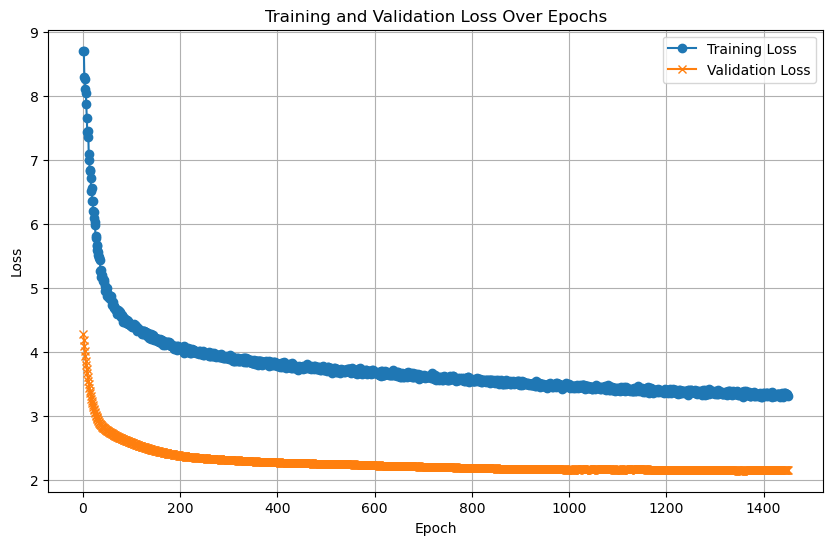

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/166], Loss: 5.1846
Test Batch [20/166], Loss: 4.9089
Test Batch [30/166], Loss: 4.8737


Test Batch [40/166], Loss: 4.9340
Test Batch [50/166], Loss: 4.8758
Test Batch [60/166], Loss: 5.0722
Test Batch [70/166], Loss: 5.0699
Test Batch [80/166], Loss: 4.7611
Test Batch [90/166], Loss: 4.6552
Test Batch [100/166], Loss: 4.7473
Test Batch [110/166], Loss: 4.9218
Test Batch [120/166], Loss: 5.0275
Test Batch [130/166], Loss: 5.1345
Test Batch [140/166], Loss: 5.3445
Test Batch [150/166], Loss: 4.8471


Test Batch [160/166], Loss: 6.7687

Test Loss: 5.0524


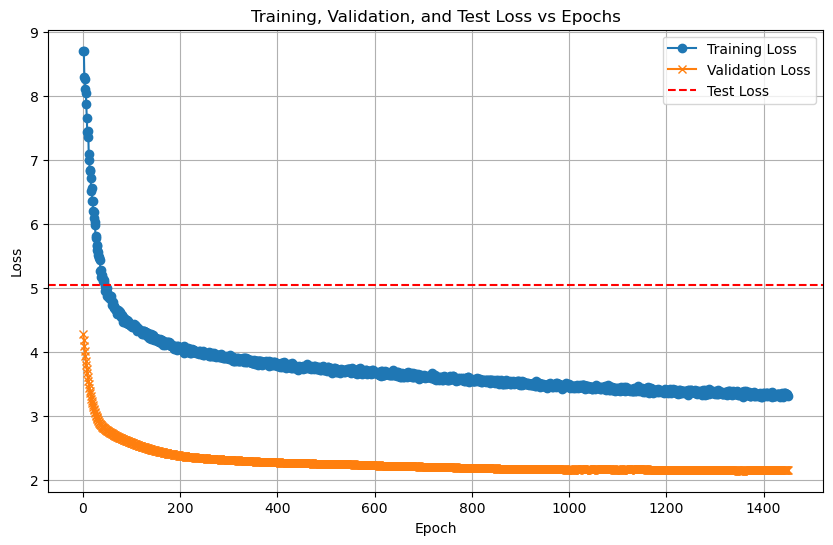

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.


  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.


  Processed batch 70/166 for test dataset.


  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.
  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.


  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.


  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.80      0.62         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.20      0.33         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5

    accuracy                           0.87        45
   macro avg       0.91      0.87      0.85        45
weighted avg       0.91      0.87      0.85        45


LOG: Evaluating on the test set...
Test Accuracy: 75.38%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2002  |  Val Loss: 2.0942
Validation loss improved from inf to 2.0942.


[Epoch 2/1000] Train Loss: 2.0859  |  Val Loss: 2.0032
Validation loss improved from 2.0942 to 2.0032.
[Epoch 3/1000] Train Loss: 2.0014  |  Val Loss: 1.9381
Validation loss improved from 2.0032 to 1.9381.
[Epoch 4/1000] Train Loss: 1.9385  |  Val Loss: 1.8858
Validation loss improved from 1.9381 to 1.8858.
[Epoch 5/1000] Train Loss: 1.8851  |  Val Loss: 1.8415
Validation loss improved from 1.8858 to 1.8415.
[Epoch 6/1000] Train Loss: 1.8363  |  Val Loss: 1.8013
Validation loss improved from 1.8415 to 1.8013.
[Epoch 7/1000] Train Loss: 1.7939  |  Val Loss: 1.7635
Validation loss improved from 1.8013 to 1.7635.
[Epoch 8/1000] Train Loss: 1.7552  |  Val Loss: 1.7262
Validation loss improved from 1.7635 to 1.7262.
[Epoch 9/1000] Train Loss: 1.7176  |  Val Loss: 1.6924
Validation loss improved from 1.7262 to 1.6924.
[Epoch 10/1000] Train Loss: 1.6832  |  Val Loss: 1.6622
Validation loss improved from 1.6924 to 1.6622.
[Epoch 11/1000] Train Loss: 1.6529  |  Val Loss: 1.6337
Validation loss 

[Epoch 17/1000] Train Loss: 1.4951  |  Val Loss: 1.4869
Validation loss improved from 1.5084 to 1.4869.
[Epoch 18/1000] Train Loss: 1.4726  |  Val Loss: 1.4663
Validation loss improved from 1.4869 to 1.4663.
[Epoch 19/1000] Train Loss: 1.4510  |  Val Loss: 1.4467
Validation loss improved from 1.4663 to 1.4467.
[Epoch 20/1000] Train Loss: 1.4303  |  Val Loss: 1.4276
Validation loss improved from 1.4467 to 1.4276.
[Epoch 21/1000] Train Loss: 1.4105  |  Val Loss: 1.4092
Validation loss improved from 1.4276 to 1.4092.
[Epoch 22/1000] Train Loss: 1.3912  |  Val Loss: 1.3911
Validation loss improved from 1.4092 to 1.3911.
[Epoch 23/1000] Train Loss: 1.3725  |  Val Loss: 1.3733
Validation loss improved from 1.3911 to 1.3733.
[Epoch 24/1000] Train Loss: 1.3540  |  Val Loss: 1.3557
Validation loss improved from 1.3733 to 1.3557.
[Epoch 25/1000] Train Loss: 1.3357  |  Val Loss: 1.3384
Validation loss improved from 1.3557 to 1.3384.
[Epoch 26/1000] Train Loss: 1.3172  |  Val Loss: 1.3217
Validati

[Epoch 32/1000] Train Loss: 1.2183  |  Val Loss: 1.2264
Validation loss improved from 1.2419 to 1.2264.
[Epoch 33/1000] Train Loss: 1.2022  |  Val Loss: 1.2116
Validation loss improved from 1.2264 to 1.2116.
[Epoch 34/1000] Train Loss: 1.1867  |  Val Loss: 1.1970
Validation loss improved from 1.2116 to 1.1970.
[Epoch 35/1000] Train Loss: 1.1717  |  Val Loss: 1.1818
Validation loss improved from 1.1970 to 1.1818.
[Epoch 36/1000] Train Loss: 1.1569  |  Val Loss: 1.1666
Validation loss improved from 1.1818 to 1.1666.
[Epoch 37/1000] Train Loss: 1.1418  |  Val Loss: 1.1518
Validation loss improved from 1.1666 to 1.1518.
[Epoch 38/1000] Train Loss: 1.1272  |  Val Loss: 1.1372
Validation loss improved from 1.1518 to 1.1372.
[Epoch 39/1000] Train Loss: 1.1128  |  Val Loss: 1.1231
Validation loss improved from 1.1372 to 1.1231.
[Epoch 40/1000] Train Loss: 1.0982  |  Val Loss: 1.1095
Validation loss improved from 1.1231 to 1.1095.
[Epoch 41/1000] Train Loss: 1.0846  |  Val Loss: 1.0955
Validati

[Epoch 49/1000] Train Loss: 0.9753  |  Val Loss: 0.9913
Validation loss improved from 1.0039 to 0.9913.
[Epoch 50/1000] Train Loss: 0.9614  |  Val Loss: 0.9791
Validation loss improved from 0.9913 to 0.9791.
[Epoch 51/1000] Train Loss: 0.9479  |  Val Loss: 0.9663
Validation loss improved from 0.9791 to 0.9663.
[Epoch 52/1000] Train Loss: 0.9338  |  Val Loss: 0.9537
Validation loss improved from 0.9663 to 0.9537.
[Epoch 53/1000] Train Loss: 0.9196  |  Val Loss: 0.9412
Validation loss improved from 0.9537 to 0.9412.
[Epoch 54/1000] Train Loss: 0.9059  |  Val Loss: 0.9284
Validation loss improved from 0.9412 to 0.9284.
[Epoch 55/1000] Train Loss: 0.8922  |  Val Loss: 0.9154
Validation loss improved from 0.9284 to 0.9154.
[Epoch 56/1000] Train Loss: 0.8777  |  Val Loss: 0.9022
Validation loss improved from 0.9154 to 0.9022.
[Epoch 57/1000] Train Loss: 0.8637  |  Val Loss: 0.8889
Validation loss improved from 0.9022 to 0.8889.
[Epoch 58/1000] Train Loss: 0.8494  |  Val Loss: 0.8759
Validati

[Epoch 67/1000] Train Loss: 0.7243  |  Val Loss: 0.7601
Validation loss improved from 0.7732 to 0.7601.
[Epoch 68/1000] Train Loss: 0.7106  |  Val Loss: 0.7479
Validation loss improved from 0.7601 to 0.7479.
[Epoch 69/1000] Train Loss: 0.6970  |  Val Loss: 0.7361
Validation loss improved from 0.7479 to 0.7361.
[Epoch 70/1000] Train Loss: 0.6837  |  Val Loss: 0.7239
Validation loss improved from 0.7361 to 0.7239.
[Epoch 71/1000] Train Loss: 0.6706  |  Val Loss: 0.7113
Validation loss improved from 0.7239 to 0.7113.
[Epoch 72/1000] Train Loss: 0.6574  |  Val Loss: 0.6999
Validation loss improved from 0.7113 to 0.6999.
[Epoch 73/1000] Train Loss: 0.6442  |  Val Loss: 0.6890
Validation loss improved from 0.6999 to 0.6890.
[Epoch 74/1000] Train Loss: 0.6313  |  Val Loss: 0.6773
Validation loss improved from 0.6890 to 0.6773.
[Epoch 75/1000] Train Loss: 0.6184  |  Val Loss: 0.6656
Validation loss improved from 0.6773 to 0.6656.
[Epoch 76/1000] Train Loss: 0.6060  |  Val Loss: 0.6537
Validati

[Epoch 84/1000] Train Loss: 0.5106  |  Val Loss: 0.5718
Validation loss improved from 0.5812 to 0.5718.
[Epoch 85/1000] Train Loss: 0.4996  |  Val Loss: 0.5630
Validation loss improved from 0.5718 to 0.5630.
[Epoch 86/1000] Train Loss: 0.4888  |  Val Loss: 0.5545
Validation loss improved from 0.5630 to 0.5545.
[Epoch 87/1000] Train Loss: 0.4785  |  Val Loss: 0.5463
Validation loss improved from 0.5545 to 0.5463.
[Epoch 88/1000] Train Loss: 0.4684  |  Val Loss: 0.5383
Validation loss improved from 0.5463 to 0.5383.
[Epoch 89/1000] Train Loss: 0.4583  |  Val Loss: 0.5311
Validation loss improved from 0.5383 to 0.5311.
[Epoch 90/1000] Train Loss: 0.4487  |  Val Loss: 0.5233
Validation loss improved from 0.5311 to 0.5233.
[Epoch 91/1000] Train Loss: 0.4393  |  Val Loss: 0.5147
Validation loss improved from 0.5233 to 0.5147.
[Epoch 92/1000] Train Loss: 0.4299  |  Val Loss: 0.5079
Validation loss improved from 0.5147 to 0.5079.
[Epoch 93/1000] Train Loss: 0.4210  |  Val Loss: 0.5008
Validati

[Epoch 101/1000] Train Loss: 0.3575  |  Val Loss: 0.4555
Validation loss improved from 0.4605 to 0.4555.
[Epoch 102/1000] Train Loss: 0.3504  |  Val Loss: 0.4506
Validation loss improved from 0.4555 to 0.4506.
[Epoch 103/1000] Train Loss: 0.3435  |  Val Loss: 0.4460
Validation loss improved from 0.4506 to 0.4460.
[Epoch 104/1000] Train Loss: 0.3369  |  Val Loss: 0.4419
Validation loss improved from 0.4460 to 0.4419.
[Epoch 105/1000] Train Loss: 0.3307  |  Val Loss: 0.4381
Validation loss improved from 0.4419 to 0.4381.
[Epoch 106/1000] Train Loss: 0.3244  |  Val Loss: 0.4338
Validation loss improved from 0.4381 to 0.4338.
[Epoch 107/1000] Train Loss: 0.3183  |  Val Loss: 0.4315
Validation loss improved from 0.4338 to 0.4315.
[Epoch 108/1000] Train Loss: 0.3126  |  Val Loss: 0.4274
Validation loss improved from 0.4315 to 0.4274.
[Epoch 109/1000] Train Loss: 0.3068  |  Val Loss: 0.4243
Validation loss improved from 0.4274 to 0.4243.
[Epoch 110/1000] Train Loss: 0.3012  |  Val Loss: 0.419

[Epoch 119/1000] Train Loss: 0.2583  |  Val Loss: 0.3922
Validation loss improved from 0.3955 to 0.3922.
[Epoch 120/1000] Train Loss: 0.2540  |  Val Loss: 0.3908
Validation loss improved from 0.3922 to 0.3908.
[Epoch 121/1000] Train Loss: 0.2502  |  Val Loss: 0.3900
Validation loss improved from 0.3908 to 0.3900.
[Epoch 122/1000] Train Loss: 0.2460  |  Val Loss: 0.3866
Validation loss improved from 0.3900 to 0.3866.
[Epoch 123/1000] Train Loss: 0.2423  |  Val Loss: 0.3849
Validation loss improved from 0.3866 to 0.3849.
[Epoch 124/1000] Train Loss: 0.2385  |  Val Loss: 0.3826
Validation loss improved from 0.3849 to 0.3826.
[Epoch 125/1000] Train Loss: 0.2350  |  Val Loss: 0.3801
Validation loss improved from 0.3826 to 0.3801.
[Epoch 126/1000] Train Loss: 0.2313  |  Val Loss: 0.3786
Validation loss improved from 0.3801 to 0.3786.
[Epoch 127/1000] Train Loss: 0.2280  |  Val Loss: 0.3767
Validation loss improved from 0.3786 to 0.3767.
[Epoch 128/1000] Train Loss: 0.2245  |  Val Loss: 0.374

[Epoch 138/1000] Train Loss: 0.1952  |  Val Loss: 0.3621
Validation loss improved from 0.3629 to 0.3621.
[Epoch 139/1000] Train Loss: 0.1928  |  Val Loss: 0.3625
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 0.1904  |  Val Loss: 0.3620
Validation loss improved from 0.3621 to 0.3620.
[Epoch 141/1000] Train Loss: 0.1879  |  Val Loss: 0.3624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 0.1857  |  Val Loss: 0.3591
Validation loss improved from 0.3620 to 0.3591.
[Epoch 143/1000] Train Loss: 0.1834  |  Val Loss: 0.3586
Validation loss improved from 0.3591 to 0.3586.
[Epoch 144/1000] Train Loss: 0.1812  |  Val Loss: 0.3581
Validation loss improved from 0.3586 to 0.3581.
[Epoch 145/1000] Train Loss: 0.1792  |  Val Loss: 0.3547
Validation loss improved from 0.3581 to 0.3547.
[Epoch 146/1000] Train Loss: 0.1769  |  Val Loss: 0.3554
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 0.1750  

[Epoch 156/1000] Train Loss: 0.1589  |  Val Loss: 0.3540
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 0.1577  |  Val Loss: 0.3569
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 0.1561  |  Val Loss: 0.3576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 0.1547  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Loss: 0.1530  |  Val Loss: 0.3513
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 161/1000] Train Loss: 0.1514  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 162/1000] Train Loss: 0.1502  |  Val Loss: 0.3552
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 163/1000] Train Loss: 0.1487  |  Val Loss: 0.3550
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 164/1000] Train Loss: 0.1474  |  Val Loss: 0.3559
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 172/1000] Train Loss: 0.1377  |  Val Loss: 0.3525
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 173/1000] Train Loss: 0.1367  |  Val Loss: 0.3537
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 174/1000] Train Loss: 0.1359  |  Val Loss: 0.3562
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 175/1000] Train Loss: 0.1350  |  Val Loss: 0.3503
Validation loss improved from 0.3504 to 0.3503.
[Epoch 176/1000] Train Loss: 0.1339  |  Val Loss: 0.3539
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 0.1325  |  Val Loss: 0.3539
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 0.1317  |  Val Loss: 0.3522
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 0.1306  |  Val Loss: 0.3530
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 0.1300  |  Val Loss: 0.3566
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 188/1000] Train Loss: 0.1231  |  Val Loss: 0.3624
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 189/1000] Train Loss: 0.1222  |  Val Loss: 0.3608
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 190/1000] Train Loss: 0.1213  |  Val Loss: 0.3563
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 191/1000] Train Loss: 0.1209  |  Val Loss: 0.3582
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 192/1000] Train Loss: 0.1203  |  Val Loss: 0.3540
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 193/1000] Train Loss: 0.1194  |  Val Loss: 0.3565
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 194/1000] Train Loss: 0.1187  |  Val Loss: 0.3582
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 195/1000] Train Loss: 0.1178  |  Val Loss: 0.3595
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 196/1000] Train Loss: 0.1173  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience:

[Epoch 204/1000] Train Loss: 0.1122  |  Val Loss: 0.3633
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 205/1000] Train Loss: 0.1117  |  Val Loss: 0.3626
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 206/1000] Train Loss: 0.1111  |  Val Loss: 0.3633
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 207/1000] Train Loss: 0.1104  |  Val Loss: 0.3616
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 208/1000] Train Loss: 0.1099  |  Val Loss: 0.3603
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 209/1000] Train Loss: 0.1096  |  Val Loss: 0.3597
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 210/1000] Train Loss: 0.1093  |  Val Loss: 0.3582
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 211/1000] Train Loss: 0.1084  |  Val Loss: 0.3637
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 212/1000] Train Loss: 0.1079  |  Val Loss: 0.3668
!! Validation loss did NOT improve !! Patience:

[Epoch 221/1000] Train Loss: 0.1038  |  Val Loss: 0.3723
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 222/1000] Train Loss: 0.1033  |  Val Loss: 0.3699
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 223/1000] Train Loss: 0.1033  |  Val Loss: 0.3616
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 224/1000] Train Loss: 0.1028  |  Val Loss: 0.3605
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 225/1000] Train Loss: 0.1022  |  Val Loss: 0.3654
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 226/1000] Train Loss: 0.1014  |  Val Loss: 0.3690
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 227/1000] Train Loss: 0.1016  |  Val Loss: 0.3743
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 228/1000] Train Loss: 0.1007  |  Val Loss: 0.3732
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 229/1000] Train Loss: 0.1003  |  Val Loss: 0.3721
!! Validation loss did NOT improve !! Patience:

[Epoch 237/1000] Train Loss: 0.0975  |  Val Loss: 0.3759
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 238/1000] Train Loss: 0.0974  |  Val Loss: 0.3724
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 239/1000] Train Loss: 0.0969  |  Val Loss: 0.3725
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 240/1000] Train Loss: 0.0964  |  Val Loss: 0.3745
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 241/1000] Train Loss: 0.0959  |  Val Loss: 0.3789
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 242/1000] Train Loss: 0.0956  |  Val Loss: 0.3835
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 243/1000] Train Loss: 0.0957  |  Val Loss: 0.3877
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 244/1000] Train Loss: 0.0954  |  Val Loss: 0.3873
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 245/1000] Train Loss: 0.0949  |  Val Loss: 0.3850
!! Validation loss did NOT improve !! Patience:

[Epoch 254/1000] Train Loss: 0.0923  |  Val Loss: 0.3812
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 255/1000] Train Loss: 0.0920  |  Val Loss: 0.3805
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 256/1000] Train Loss: 0.0917  |  Val Loss: 0.3825
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 257/1000] Train Loss: 0.0915  |  Val Loss: 0.3846
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 258/1000] Train Loss: 0.0912  |  Val Loss: 0.3862
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 259/1000] Train Loss: 0.0909  |  Val Loss: 0.3866
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 260/1000] Train Loss: 0.0906  |  Val Loss: 0.3885
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 261/1000] Train Loss: 0.0904  |  Val Loss: 0.3883
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 262/1000] Train Loss: 0.0906  |  Val Loss: 0.3920
!! Validation loss did NOT improve !! Patience:

[Epoch 271/1000] Train Loss: 0.0880  |  Val Loss: 0.3898
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 272/1000] Train Loss: 0.0876  |  Val Loss: 0.3910
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 273/1000] Train Loss: 0.0874  |  Val Loss: 0.3872
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 274/1000] Train Loss: 0.0876  |  Val Loss: 0.3875
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 275/1000] Train Loss: 0.0869  |  Val Loss: 0.3929
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 275 !!
No improvement for 100 epochs.


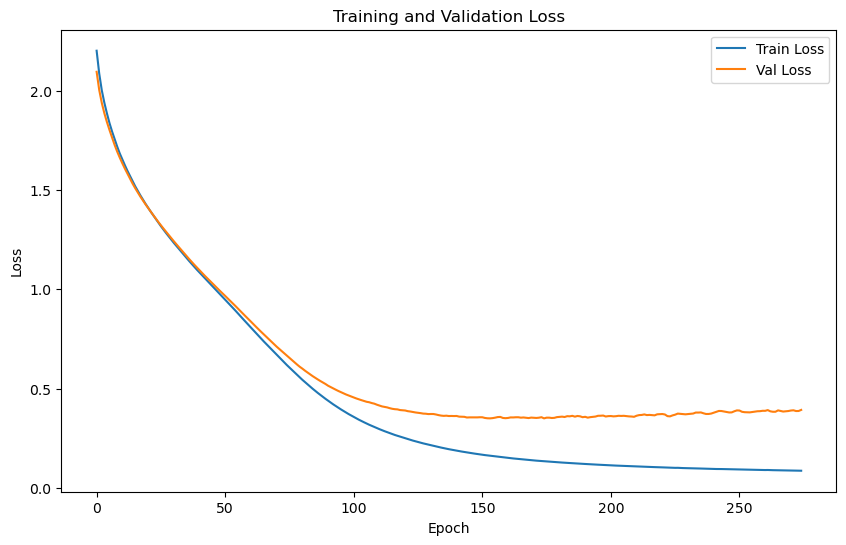

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0159 | Test Accuracy: 74.28%


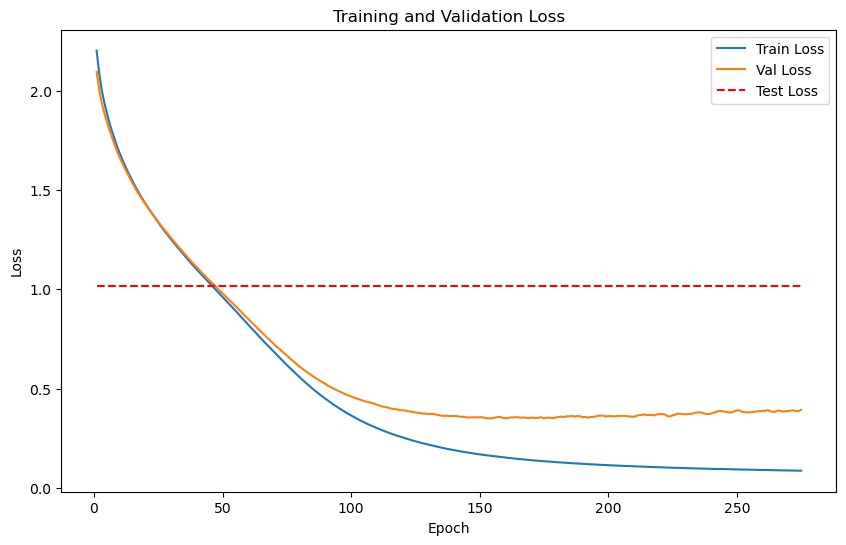

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4639


    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4400
Epoch [1/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4400

Validation loss improved from inf to 0.4400. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4695


    Batch [2/2], Train Loss: 0.4641
LOG: Epoch [2/2000] - Validation


    Batch [1/1], Val Loss: 0.4395
Epoch [2/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4395

Validation loss improved from 0.4400 to 0.4395. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4622
    Batch [2/2], Train Loss: 0.4650
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4364
Epoch [3/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4364

Validation loss improved from 0.4395 to 0.4364. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4614
    Batch [2/2], Train Loss: 0.4607
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4330
Epoch [4/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4330

Validation loss improved from 0.4364 to 0.4330. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4638


    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4296
Epoch [5/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4296

Validation loss improved from 0.4330 to 0.4296. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4567
    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4259
Epoch [6/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.4259

Validation loss improved from 0.4296 to 0.4259. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/2], Train Loss: 0.4585
    Batch [2/2], Train Loss: 0.4561
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4219
Epoch [7/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4219

Validation loss improved from 0.4259 to 0.4219. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4536


    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4179
Epoch [8/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4179

Validation loss improved from 0.4219 to 0.4179. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4152
Epoch [9/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4152

Validation loss improved from 0.4179 to 0.4152. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4544
    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4127
Epoch [10/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4127

Validation loss improved from 0.4152 to 0.4127. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4495


    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4103
Epoch [11/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4103

Validation loss improved from 0.4127 to 0.4103. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4483
LOG: Epoch [12/2000] - Validation


    Batch [1/1], Val Loss: 0.4086
Epoch [12/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4086

Validation loss improved from 0.4103 to 0.4086. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.4458
    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4068
Epoch [13/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4068

Validation loss improved from 0.4086 to 0.4068. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4441
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4052
Epoch [14/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4052

Validation loss improved from 0.4068 to 0.4052. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4374


    Batch [2/2], Train Loss: 0.4436
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [15/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4038

Validation loss improved from 0.4052 to 0.4038. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4342
    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4024
Epoch [16/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4024

Validation loss improved from 0.4038 to 0.4024. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4435
    Batch [2/2], Train Loss: 0.4361
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4007
Epoch [17/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4007

Validation loss improved from 0.4024 to 0.4007. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4402


    Batch [2/2], Train Loss: 0.4359
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [18/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3991

Validation loss improved from 0.4007 to 0.3991. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4387
    Batch [2/2], Train Loss: 0.4358
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3977
Epoch [19/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3977

Validation loss improved from 0.3991 to 0.3977. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4412
    Batch [2/2], Train Loss: 0.4344
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [20/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3961

Validation loss improved from 0.3977 to 0.3961. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4338


    Batch [2/2], Train Loss: 0.4355
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3947
Epoch [21/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3947

Validation loss improved from 0.3961 to 0.3947. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4308
    Batch [2/2], Train Loss: 0.4319
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [22/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3934

Validation loss improved from 0.3947 to 0.3934. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/2], Train Loss: 0.4262
    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [23/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3918

Validation loss improved from 0.3934 to 0.3918. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4279


    Batch [2/2], Train Loss: 0.4306
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [24/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3904

Validation loss improved from 0.3918 to 0.3904. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4292
    Batch [2/2], Train Loss: 0.4289
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.3889
Epoch [25/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3889

Validation loss improved from 0.3904 to 0.3889. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4389
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [26/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3872

Validation loss improved from 0.3889 to 0.3872. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.4311
    Batch [2/2], Train Loss: 0.4220
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3859
Epoch [27/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3859

Validation loss improved from 0.3872 to 0.3859. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4298


    Batch [2/2], Train Loss: 0.4216
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [28/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3842

Validation loss improved from 0.3859 to 0.3842. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4210
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.3827
Epoch [29/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3827

Validation loss improved from 0.3842 to 0.3827. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4180
    Batch [2/2], Train Loss: 0.4204
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.3812
Epoch [30/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3812

Validation loss improved from 0.3827 to 0.3812. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4146
    Batch [2/2], Train Loss: 0.4221
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [31/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3798

Validation loss improved from 0.3812 to 0.3798. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4167
    Batch [2/2], Train Loss: 0.4089
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [32/2000], Avg Train Loss: 0.4128, Avg Val Loss: 0.3782

Validation loss improved from 0.3798 to 0.3782. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.4195


    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [33/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3770

Validation loss improved from 0.3782 to 0.3770. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4169
    Batch [2/2], Train Loss: 0.4150
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [34/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3755

Validation loss improved from 0.3770 to 0.3755. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.4152
    Batch [2/2], Train Loss: 0.4138
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3743
Epoch [35/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3743

Validation loss improved from 0.3755 to 0.3743. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.4065
    Batch [2/2], Train Loss: 0.4127
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3730
Epoch [36/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3730

Validation loss improved from 0.3743 to 0.3730. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4242


    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3716
Epoch [37/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3716

Validation loss improved from 0.3730 to 0.3716. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4189
    Batch [2/2], Train Loss: 0.4121
LOG: Epoch [38/2000] - Validation


    Batch [1/1], Val Loss: 0.3705
Epoch [38/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3705

Validation loss improved from 0.3716 to 0.3705. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.4125
    Batch [2/2], Train Loss: 0.4108
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [39/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.3693

Validation loss improved from 0.3705 to 0.3693. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.4146
    Batch [2/2], Train Loss: 0.4060
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3681
Epoch [40/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.3681

Validation loss improved from 0.3693 to 0.3681. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4059


    Batch [2/2], Train Loss: 0.4081
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3669
Epoch [41/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3669

Validation loss improved from 0.3681 to 0.3669. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.4079
    Batch [2/2], Train Loss: 0.4113
LOG: Epoch [42/2000] - Validation


    Batch [1/1], Val Loss: 0.3660
Epoch [42/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3660

Validation loss improved from 0.3669 to 0.3660. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4059
    Batch [2/2], Train Loss: 0.4039
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3650
Epoch [43/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3650

Validation loss improved from 0.3660 to 0.3650. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4066
    Batch [2/2], Train Loss: 0.4035
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3641
Epoch [44/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3641

Validation loss improved from 0.3650 to 0.3641. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4095


    Batch [2/2], Train Loss: 0.4063
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3633
Epoch [45/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3633

Validation loss improved from 0.3641 to 0.3633. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.4145
    Batch [2/2], Train Loss: 0.4000
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [46/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3624

Validation loss improved from 0.3633 to 0.3624. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/2], Train Loss: 0.3961
    Batch [2/2], Train Loss: 0.4010
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [47/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3614

Validation loss improved from 0.3624 to 0.3614. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3959


    Batch [2/2], Train Loss: 0.4021
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [48/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3607

Validation loss improved from 0.3614 to 0.3607. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4010
    Batch [2/2], Train Loss: 0.3960
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.3598
Epoch [49/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3598

Validation loss improved from 0.3607 to 0.3598. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4032
    Batch [2/2], Train Loss: 0.3992
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [50/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3589

Validation loss improved from 0.3598 to 0.3589. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3975
    Batch [2/2], Train Loss: 0.3928
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3581
Epoch [51/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3581

Validation loss improved from 0.3589 to 0.3581. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4040


    Batch [2/2], Train Loss: 0.3927
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3572
Epoch [52/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3572

Validation loss improved from 0.3581 to 0.3572. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3933
    Batch [2/2], Train Loss: 0.3873
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3563
Epoch [53/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.3563

Validation loss improved from 0.3572 to 0.3563. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3966
    Batch [2/2], Train Loss: 0.4003
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [54/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3555

Validation loss improved from 0.3563 to 0.3555. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3936


    Batch [2/2], Train Loss: 0.3947
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [55/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.3548

Validation loss improved from 0.3555 to 0.3548. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3947
    Batch [2/2], Train Loss: 0.3874
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3541
Epoch [56/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3541

Validation loss improved from 0.3548 to 0.3541. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4006
    Batch [2/2], Train Loss: 0.3911
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3534
Epoch [57/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.3534

Validation loss improved from 0.3541 to 0.3534. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3896
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [58/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3526

Validation loss improved from 0.3534 to 0.3526. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3885


    Batch [2/2], Train Loss: 0.3922
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3516
Epoch [59/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3516

Validation loss improved from 0.3526 to 0.3516. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3929
    Batch [2/2], Train Loss: 0.3924
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [60/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3508

Validation loss improved from 0.3516 to 0.3508. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.4023
    Batch [2/2], Train Loss: 0.3908
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [61/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3501

Validation loss improved from 0.3508 to 0.3501. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3875


    Batch [2/2], Train Loss: 0.3887
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3493
Epoch [62/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.3493

Validation loss improved from 0.3501 to 0.3493. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3835
    Batch [2/2], Train Loss: 0.3875
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3486
Epoch [63/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3486

Validation loss improved from 0.3493 to 0.3486. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3853
    Batch [2/2], Train Loss: 0.3894
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [64/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3478

Validation loss improved from 0.3486 to 0.3478. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/2], Train Loss: 0.3898
    Batch [2/2], Train Loss: 0.3837
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3470
Epoch [65/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3470

Validation loss improved from 0.3478 to 0.3470. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3832


    Batch [2/2], Train Loss: 0.3877
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [66/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3462

Validation loss improved from 0.3470 to 0.3462. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.3799
    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [67/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.3455

Validation loss improved from 0.3462 to 0.3455. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3860
    Batch [2/2], Train Loss: 0.3798
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.3448
Epoch [68/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3448

Validation loss improved from 0.3455 to 0.3448. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3797


    Batch [2/2], Train Loss: 0.3879
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [69/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3440

Validation loss improved from 0.3448 to 0.3440. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3762
    Batch [2/2], Train Loss: 0.3907
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3434
Epoch [70/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3434

Validation loss improved from 0.3440 to 0.3434. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/2], Train Loss: 0.3836
    Batch [2/2], Train Loss: 0.3767
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [71/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.3427

Validation loss improved from 0.3434 to 0.3427. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3808


    Batch [2/2], Train Loss: 0.3775
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [72/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3422

Validation loss improved from 0.3427 to 0.3422. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3761
    Batch [2/2], Train Loss: 0.3785
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [73/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3416

Validation loss improved from 0.3422 to 0.3416. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.3759
    Batch [2/2], Train Loss: 0.3752
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [74/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3410

Validation loss improved from 0.3416 to 0.3410. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3779


    Batch [2/2], Train Loss: 0.3742
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [75/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3403

Validation loss improved from 0.3410 to 0.3403. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.3791
    Batch [2/2], Train Loss: 0.3736
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.3394
Epoch [76/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3394

Validation loss improved from 0.3403 to 0.3394. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3789
    Batch [2/2], Train Loss: 0.3813
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [77/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.3387

Validation loss improved from 0.3394 to 0.3387. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.3795
    Batch [2/2], Train Loss: 0.3717
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3380
Epoch [78/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3380

Validation loss improved from 0.3387 to 0.3380. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3739


    Batch [2/2], Train Loss: 0.3750
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3374
Epoch [79/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3374

Validation loss improved from 0.3380 to 0.3374. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.3743
    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3366
Epoch [80/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3366

Validation loss improved from 0.3374 to 0.3366. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.3782
    Batch [2/2], Train Loss: 0.3715
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [81/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3358

Validation loss improved from 0.3366 to 0.3358. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3765


    Batch [2/2], Train Loss: 0.3732
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [82/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3351

Validation loss improved from 0.3358 to 0.3351. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3685
    Batch [2/2], Train Loss: 0.3739
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [83/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.3346

Validation loss improved from 0.3351 to 0.3346. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.3776
    Batch [2/2], Train Loss: 0.3795
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [84/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3340

Validation loss improved from 0.3346 to 0.3340. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3738


    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [85/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.3336

Validation loss improved from 0.3340 to 0.3336. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3653
    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [86/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3332

Validation loss improved from 0.3336 to 0.3332. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3707
    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [87/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.3328

Validation loss improved from 0.3332 to 0.3328. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3774


    Batch [2/2], Train Loss: 0.3575
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [88/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3323

Validation loss improved from 0.3328 to 0.3323. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3676
    Batch [2/2], Train Loss: 0.3714
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [89/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3317

Validation loss improved from 0.3323 to 0.3317. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/2], Train Loss: 0.3673
    Batch [2/2], Train Loss: 0.3609
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [90/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3312

Validation loss improved from 0.3317 to 0.3312. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3753


    Batch [2/2], Train Loss: 0.3673
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [91/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3308

Validation loss improved from 0.3312 to 0.3308. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3658
    Batch [2/2], Train Loss: 0.3628
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.3306
Epoch [92/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.3306

Validation loss improved from 0.3308 to 0.3306. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3705
    Batch [2/2], Train Loss: 0.3740
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [93/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.3301

Validation loss improved from 0.3306 to 0.3301. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3695
    Batch [2/2], Train Loss: 0.3696
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3297
Epoch [94/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3297

Validation loss improved from 0.3301 to 0.3297. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.3668
    Batch [2/2], Train Loss: 0.3592
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3293
Epoch [95/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3293

Validation loss improved from 0.3297 to 0.3293. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3643


    Batch [2/2], Train Loss: 0.3683
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3288
Epoch [96/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3288

Validation loss improved from 0.3293 to 0.3288. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3659
    Batch [2/2], Train Loss: 0.3632
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3280
Epoch [97/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3280

Validation loss improved from 0.3288 to 0.3280. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3601
    Batch [2/2], Train Loss: 0.3613
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [98/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3272

Validation loss improved from 0.3280 to 0.3272. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.3630
    Batch [2/2], Train Loss: 0.3603
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.3266
Epoch [99/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3266

Validation loss improved from 0.3272 to 0.3266. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3593


    Batch [2/2], Train Loss: 0.3571
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3260
Epoch [100/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.3260

Validation loss improved from 0.3266 to 0.3260. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3550
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [101/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3253

Validation loss improved from 0.3260 to 0.3253. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3552
    Batch [2/2], Train Loss: 0.3477
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3246
Epoch [102/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3246

Validation loss improved from 0.3253 to 0.3246. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3553


    Batch [2/2], Train Loss: 0.3571
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [103/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.3240

Validation loss improved from 0.3246 to 0.3240. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3644
    Batch [2/2], Train Loss: 0.3540
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3233
Epoch [104/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3233

Validation loss improved from 0.3240 to 0.3233. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3616
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [105/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.3227

Validation loss improved from 0.3233 to 0.3227. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.3588
    Batch [2/2], Train Loss: 0.3643
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [106/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3221

Validation loss improved from 0.3227 to 0.3221. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3592


    Batch [2/2], Train Loss: 0.3603
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [107/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3215

Validation loss improved from 0.3221 to 0.3215. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3473
    Batch [2/2], Train Loss: 0.3469
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [108/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3209

Validation loss improved from 0.3215 to 0.3209. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.3593
    Batch [2/2], Train Loss: 0.3546
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [109/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3203

Validation loss improved from 0.3209 to 0.3203. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3503


    Batch [2/2], Train Loss: 0.3521
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [110/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3198

Validation loss improved from 0.3203 to 0.3198. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.3542
    Batch [2/2], Train Loss: 0.3517
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [111/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3193

Validation loss improved from 0.3198 to 0.3193. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3402
    Batch [2/2], Train Loss: 0.3531
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3188
Epoch [112/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.3188

Validation loss improved from 0.3193 to 0.3188. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.3491
    Batch [2/2], Train Loss: 0.3474
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3183
Epoch [113/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.3183

Validation loss improved from 0.3188 to 0.3183. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3440


    Batch [2/2], Train Loss: 0.3453
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [114/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3180

Validation loss improved from 0.3183 to 0.3180. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3404
    Batch [2/2], Train Loss: 0.3553
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3177
Epoch [115/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3177

Validation loss improved from 0.3180 to 0.3177. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3497
    Batch [2/2], Train Loss: 0.3455
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [116/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.3173

Validation loss improved from 0.3177 to 0.3173. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3490


    Batch [2/2], Train Loss: 0.3509
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3168
Epoch [117/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3168

Validation loss improved from 0.3173 to 0.3168. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3457
    Batch [2/2], Train Loss: 0.3471
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3162
Epoch [118/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3162

Validation loss improved from 0.3168 to 0.3162. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3395
    Batch [2/2], Train Loss: 0.3416
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3158
Epoch [119/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3158

Validation loss improved from 0.3162 to 0.3158. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3498


    Batch [2/2], Train Loss: 0.3490
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [120/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.3152

Validation loss improved from 0.3158 to 0.3152. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3432
    Batch [2/2], Train Loss: 0.3409
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.3145
Epoch [121/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.3145

Validation loss improved from 0.3152 to 0.3145. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.3449
    Batch [2/2], Train Loss: 0.3468
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [122/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.3140

Validation loss improved from 0.3145 to 0.3140. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.3420
    Batch [2/2], Train Loss: 0.3429
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3134
Epoch [123/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3134

Validation loss improved from 0.3140 to 0.3134. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3418


    Batch [2/2], Train Loss: 0.3543
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [124/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.3128

Validation loss improved from 0.3134 to 0.3128. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3469
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [125/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3124

Validation loss improved from 0.3128 to 0.3124. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3257
    Batch [2/2], Train Loss: 0.3374
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [126/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3122

Validation loss improved from 0.3124 to 0.3122. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3518


    Batch [2/2], Train Loss: 0.3542
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3120
Epoch [127/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3120

Validation loss improved from 0.3122 to 0.3120. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.3459
    Batch [2/2], Train Loss: 0.3453
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.3116
Epoch [128/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3116

Validation loss improved from 0.3120 to 0.3116. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.3414
    Batch [2/2], Train Loss: 0.3381
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [129/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3113

Validation loss improved from 0.3116 to 0.3113. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3397
    Batch [2/2], Train Loss: 0.3451
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [130/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3108

Validation loss improved from 0.3113 to 0.3108. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3351


    Batch [2/2], Train Loss: 0.3395
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [131/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3104

Validation loss improved from 0.3108 to 0.3104. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.3400
    Batch [2/2], Train Loss: 0.3399
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3100
Epoch [132/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.3100

Validation loss improved from 0.3104 to 0.3100. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.3401
    Batch [2/2], Train Loss: 0.3447
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3096
Epoch [133/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3096

Validation loss improved from 0.3100 to 0.3096. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.3399
    Batch [2/2], Train Loss: 0.3351
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3090
Epoch [134/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3090

Validation loss improved from 0.3096 to 0.3090. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3445


    Batch [2/2], Train Loss: 0.3411
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [135/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3082

Validation loss improved from 0.3090 to 0.3082. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.3354
    Batch [2/2], Train Loss: 0.3376
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3077
Epoch [136/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.3077

Validation loss improved from 0.3082 to 0.3077. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.3411
    Batch [2/2], Train Loss: 0.3329
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3073
Epoch [137/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3073

Validation loss improved from 0.3077 to 0.3073. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3381


    Batch [2/2], Train Loss: 0.3310
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3068
Epoch [138/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3068

Validation loss improved from 0.3073 to 0.3068. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.3326
    Batch [2/2], Train Loss: 0.3355
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3062
Epoch [139/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3062

Validation loss improved from 0.3068 to 0.3062. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3328
    Batch [2/2], Train Loss: 0.3345
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3058
Epoch [140/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3058

Validation loss improved from 0.3062 to 0.3058. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.3385
    Batch [2/2], Train Loss: 0.3223
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [141/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.3054

Validation loss improved from 0.3058 to 0.3054. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.3293


    Batch [2/2], Train Loss: 0.3451
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [142/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3050

Validation loss improved from 0.3054 to 0.3050. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3232
    Batch [2/2], Train Loss: 0.3333
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [143/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.3048

Validation loss improved from 0.3050 to 0.3048. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.3274
    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [144/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3045

Validation loss improved from 0.3048 to 0.3045. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.3357


    Batch [2/2], Train Loss: 0.3368
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [145/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.3043

Validation loss improved from 0.3045 to 0.3043. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.3310
    Batch [2/2], Train Loss: 0.3363
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3039
Epoch [146/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.3039

Validation loss improved from 0.3043 to 0.3039. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.3253
    Batch [2/2], Train Loss: 0.3283
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [147/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.3038

Validation loss improved from 0.3039 to 0.3038. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3300


    Batch [2/2], Train Loss: 0.3192
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [148/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.3318
    Batch [2/2], Train Loss: 0.3264
LOG: Epoch [149/2000] - Validation


    Batch [1/1], Val Loss: 0.3036
Epoch [149/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3182
    Batch [2/2], Train Loss: 0.3334
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [150/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/2], Train Loss: 0.3223
    Batch [2/2], Train Loss: 0.3242
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [151/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3037

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3335


    Batch [2/2], Train Loss: 0.3215
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [152/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3036

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.3318
    Batch [2/2], Train Loss: 0.3293
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [153/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.3034

Validation loss improved from 0.3036 to 0.3034. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3216
    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3031
Epoch [154/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3031

Validation loss improved from 0.3034 to 0.3031. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3305


    Batch [2/2], Train Loss: 0.3260
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3028
Epoch [155/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.3028

Validation loss improved from 0.3031 to 0.3028. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3227
    Batch [2/2], Train Loss: 0.3036
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3024
Epoch [156/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.3024

Validation loss improved from 0.3028 to 0.3024. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.3208
    Batch [2/2], Train Loss: 0.3290
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [157/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3019

Validation loss improved from 0.3024 to 0.3019. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.3255


    Batch [2/2], Train Loss: 0.3226
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [158/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.3015

Validation loss improved from 0.3019 to 0.3015. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3054
    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3010
Epoch [159/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3010

Validation loss improved from 0.3015 to 0.3010. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.3198
    Batch [2/2], Train Loss: 0.3233
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [160/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3007

Validation loss improved from 0.3010 to 0.3007. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3295


    Batch [2/2], Train Loss: 0.3247
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3004
Epoch [161/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3004

Validation loss improved from 0.3007 to 0.3004. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.3235
    Batch [2/2], Train Loss: 0.3151
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [162/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3003

Validation loss improved from 0.3004 to 0.3003. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.3228
    Batch [2/2], Train Loss: 0.3257
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2999
Epoch [163/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2999

Validation loss improved from 0.3003 to 0.2999. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.3174


    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [164/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2996

Validation loss improved from 0.2999 to 0.2996. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.3235
    Batch [2/2], Train Loss: 0.3130
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.2993
Epoch [165/2000], Avg Train Loss: 0.3183, Avg Val Loss: 0.2993

Validation loss improved from 0.2996 to 0.2993. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.3219
    Batch [2/2], Train Loss: 0.3158
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2988
Epoch [166/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2988

Validation loss improved from 0.2993 to 0.2988. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.3210
    Batch [2/2], Train Loss: 0.3201
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2984
Epoch [167/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2984

Validation loss improved from 0.2988 to 0.2984. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3187


    Batch [2/2], Train Loss: 0.3184
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2981
Epoch [168/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2981

Validation loss improved from 0.2984 to 0.2981. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.3104
    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2977
Epoch [169/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2977

Validation loss improved from 0.2981 to 0.2977. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.3160
    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [170/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2970

Validation loss improved from 0.2977 to 0.2970. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.3121


    Batch [2/2], Train Loss: 0.3246
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2964
Epoch [171/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2964

Validation loss improved from 0.2970 to 0.2964. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.3165
    Batch [2/2], Train Loss: 0.3242
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2961
Epoch [172/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2961

Validation loss improved from 0.2964 to 0.2961. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.3143
    Batch [2/2], Train Loss: 0.3065
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [173/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2958

Validation loss improved from 0.2961 to 0.2958. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3222


    Batch [2/2], Train Loss: 0.3162
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [174/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2957

Validation loss improved from 0.2958 to 0.2957. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.3099
    Batch [2/2], Train Loss: 0.3059
LOG: Epoch [175/2000] - Validation


    Batch [1/1], Val Loss: 0.2957
Epoch [175/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.2957

Validation loss improved from 0.2957 to 0.2957. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.3164
    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [176/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2956

Validation loss improved from 0.2957 to 0.2956. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.3040
    Batch [2/2], Train Loss: 0.3080
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [177/2000], Avg Train Loss: 0.3060, Avg Val Loss: 0.2954

Validation loss improved from 0.2956 to 0.2954. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3192


    Batch [2/2], Train Loss: 0.3088
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [178/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2954

Validation loss improved from 0.2954 to 0.2954. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.3153
    Batch [2/2], Train Loss: 0.3180
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [179/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.3043
    Batch [2/2], Train Loss: 0.3096
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [180/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3145


    Batch [2/2], Train Loss: 0.2978
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2951
Epoch [181/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2951

Validation loss improved from 0.2953 to 0.2951. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.3055
    Batch [2/2], Train Loss: 0.3173
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [182/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.2952

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3018
    Batch [2/2], Train Loss: 0.3010
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [183/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.3087


    Batch [2/2], Train Loss: 0.3151
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2956
Epoch [184/2000], Avg Train Loss: 0.3119, Avg Val Loss: 0.2956

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.3067
    Batch [2/2], Train Loss: 0.3098
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2958
Epoch [185/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.2958

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.3102
    Batch [2/2], Train Loss: 0.3029
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2961
Epoch [186/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.2961

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3142
    Batch [2/2], Train Loss: 0.3153
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2961
Epoch [187/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.2961

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3086


    Batch [2/2], Train Loss: 0.3028
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [188/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.2957

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.3133
    Batch [2/2], Train Loss: 0.3066
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [189/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2952

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.3066
    Batch [2/2], Train Loss: 0.3158
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2949
Epoch [190/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2949

Validation loss improved from 0.2951 to 0.2949. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.3040


    Batch [2/2], Train Loss: 0.2952
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2946
Epoch [191/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.2946

Validation loss improved from 0.2949 to 0.2946. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.3152
    Batch [2/2], Train Loss: 0.3179
LOG: Epoch [192/2000] - Validation


    Batch [1/1], Val Loss: 0.2941
Epoch [192/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2941

Validation loss improved from 0.2946 to 0.2941. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.3093
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2937
Epoch [193/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2937

Validation loss improved from 0.2941 to 0.2937. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2938
    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2933
Epoch [194/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.2933

Validation loss improved from 0.2937 to 0.2933. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.3073


    Batch [2/2], Train Loss: 0.2954
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [195/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2997
    Batch [2/2], Train Loss: 0.2944
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.2930
Epoch [196/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2930

Validation loss improved from 0.2932 to 0.2930. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.3027
    Batch [2/2], Train Loss: 0.2998
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2927
Epoch [197/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.2927

Validation loss improved from 0.2930 to 0.2927. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2993
    Batch [2/2], Train Loss: 0.3052
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [198/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2926

Validation loss improved from 0.2927 to 0.2926. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.3060


    Batch [2/2], Train Loss: 0.3024
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [199/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2924

Validation loss improved from 0.2926 to 0.2924. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.3129
    Batch [2/2], Train Loss: 0.2960
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2925
Epoch [200/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2859
    Batch [2/2], Train Loss: 0.3004
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [201/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2921

Validation loss improved from 0.2924 to 0.2921. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.3013


    Batch [2/2], Train Loss: 0.3022
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [202/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.2919

Validation loss improved from 0.2921 to 0.2919. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2931
    Batch [2/2], Train Loss: 0.2949
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [203/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2919

Validation loss improved from 0.2919 to 0.2919. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.3020
    Batch [2/2], Train Loss: 0.2903
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [204/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2919

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.3016


    Batch [2/2], Train Loss: 0.2981
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2920
Epoch [205/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2920

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2973
    Batch [2/2], Train Loss: 0.2986
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [206/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2918

Validation loss improved from 0.2919 to 0.2918. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.2935
    Batch [2/2], Train Loss: 0.3005
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [207/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.2917

Validation loss improved from 0.2918 to 0.2917. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.2943


    Batch [2/2], Train Loss: 0.2853
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [208/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.2915

Validation loss improved from 0.2917 to 0.2915. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2983
    Batch [2/2], Train Loss: 0.3034
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [209/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.2915

Validation loss improved from 0.2915 to 0.2915. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2842
    Batch [2/2], Train Loss: 0.2841
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [210/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.3028


    Batch [2/2], Train Loss: 0.2998
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [211/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2918
    Batch [2/2], Train Loss: 0.3008
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.2915
Epoch [212/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2991
    Batch [2/2], Train Loss: 0.2948
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [213/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2913

Validation loss improved from 0.2915 to 0.2913. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2815
    Batch [2/2], Train Loss: 0.2862
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [214/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2910

Validation loss improved from 0.2913 to 0.2910. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2972


    Batch [2/2], Train Loss: 0.2775
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [215/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2930
    Batch [2/2], Train Loss: 0.2976
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [216/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.2909

Validation loss improved from 0.2910 to 0.2909. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2811
    Batch [2/2], Train Loss: 0.2827
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [217/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2907

Validation loss improved from 0.2909 to 0.2907. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2863
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [218/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2904

Validation loss improved from 0.2907 to 0.2904. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2833
    Batch [2/2], Train Loss: 0.2858
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [219/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2902

Validation loss improved from 0.2904 to 0.2902. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2952
    Batch [2/2], Train Loss: 0.2965
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [220/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.2896

Validation loss improved from 0.2902 to 0.2896. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.3011
    Batch [2/2], Train Loss: 0.2866
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [221/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2890

Validation loss improved from 0.2896 to 0.2890. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2795


    Batch [2/2], Train Loss: 0.2790
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [222/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2676
    Batch [2/2], Train Loss: 0.2921
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [223/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2865
    Batch [2/2], Train Loss: 0.2833
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2895
Epoch [224/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2895

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2846
    Batch [2/2], Train Loss: 0.2970
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [225/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.2898

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2780


    Batch [2/2], Train Loss: 0.2933
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [226/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.2828
    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [227/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.2927
    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [228/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2907


    Batch [2/2], Train Loss: 0.2835
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [229/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.2865
    Batch [2/2], Train Loss: 0.3004
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.2907
Epoch [230/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2969
    Batch [2/2], Train Loss: 0.2900
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [231/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2732
    Batch [2/2], Train Loss: 0.2925
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [232/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2778


    Batch [2/2], Train Loss: 0.2895
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [233/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2792
    Batch [2/2], Train Loss: 0.2864
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [234/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.2899

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.2759
    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2898
Epoch [235/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.2898

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2732


    Batch [2/2], Train Loss: 0.2772
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [236/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2771
    Batch [2/2], Train Loss: 0.2880
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2901
Epoch [237/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2901

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2763
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [238/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2880


    Batch [2/2], Train Loss: 0.2738
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [239/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2808
    Batch [2/2], Train Loss: 0.2750
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [240/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2728
    Batch [2/2], Train Loss: 0.2844
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [241/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2818


    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [242/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2719


    Batch [2/2], Train Loss: 0.2598
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [243/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2903

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.2773
    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [244/2000] - Validation


    Batch [1/1], Val Loss: 0.2897
Epoch [244/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.2897

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.2719
    Batch [2/2], Train Loss: 0.2776
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [245/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2893

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [246/2000] - Training


    Batch [1/2], Train Loss: 0.2567
    Batch [2/2], Train Loss: 0.2792
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [246/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2889

Validation loss improved from 0.2890 to 0.2889. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2867


    Batch [2/2], Train Loss: 0.2723
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [247/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.2886

Validation loss improved from 0.2889 to 0.2886. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2645
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [248/2000] - Validation


    Batch [1/1], Val Loss: 0.2885
Epoch [248/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2885

Validation loss improved from 0.2886 to 0.2885. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2708
    Batch [2/2], Train Loss: 0.2740
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [249/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2880

Validation loss improved from 0.2885 to 0.2880. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2771
    Batch [2/2], Train Loss: 0.2709
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2879
Epoch [250/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.2879

Validation loss improved from 0.2880 to 0.2879. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2792


    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [251/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.2880

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2771
    Batch [2/2], Train Loss: 0.2666
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [252/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2875

Validation loss improved from 0.2879 to 0.2875. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2636
    Batch [2/2], Train Loss: 0.2703
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [253/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2673


    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.2872
Epoch [254/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2872

Validation loss improved from 0.2873 to 0.2872. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2777
    Batch [2/2], Train Loss: 0.2686
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.2873
Epoch [255/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.2873

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.2784
    Batch [2/2], Train Loss: 0.2654
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [256/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2877

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.2582


    Batch [2/2], Train Loss: 0.2719
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [257/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2877

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.2634
    Batch [2/2], Train Loss: 0.2795
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [258/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.2612
    Batch [2/2], Train Loss: 0.2758
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [259/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2653
    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [260/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2640


    Batch [2/2], Train Loss: 0.2595
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.2892
Epoch [261/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2892

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.2645
    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [262/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.2701
    Batch [2/2], Train Loss: 0.2711
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [263/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.2783


    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [264/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2819
    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [265/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.2765
    Batch [2/2], Train Loss: 0.2853
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [266/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.2611
    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.2872
Epoch [267/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2872

Validation loss improved from 0.2872 to 0.2872. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2711


    Batch [2/2], Train Loss: 0.2528
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.2864
Epoch [268/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.2864

Validation loss improved from 0.2872 to 0.2864. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2681
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [269/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2860

Validation loss improved from 0.2864 to 0.2860. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2642
    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.2863
Epoch [270/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.2863

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2612


    Batch [2/2], Train Loss: 0.2543
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.2861
Epoch [271/2000], Avg Train Loss: 0.2578, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2753
    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.2861
Epoch [272/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.2861

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2654
    Batch [2/2], Train Loss: 0.2620
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.2858
Epoch [273/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.2858

Validation loss improved from 0.2860 to 0.2858. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2644
    Batch [2/2], Train Loss: 0.2714
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [274/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.2854

Validation loss improved from 0.2858 to 0.2854. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2656


    Batch [2/2], Train Loss: 0.2638
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [275/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2854

Validation loss improved from 0.2854 to 0.2854. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2656
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.2854
Epoch [276/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.2854

Validation loss improved from 0.2854 to 0.2854. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2440
    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [277/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2534
    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.2855
Epoch [278/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2632


    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [279/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2685
    Batch [2/2], Train Loss: 0.2577
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.2854
Epoch [280/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.2648
    Batch [2/2], Train Loss: 0.2600
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.2856
Epoch [281/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.2553


    Batch [2/2], Train Loss: 0.2729
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.2853
Epoch [282/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2642
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.2849
Epoch [283/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.2849

Validation loss improved from 0.2853 to 0.2849. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2637
    Batch [2/2], Train Loss: 0.2728
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.2843
Epoch [284/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2843

Validation loss improved from 0.2849 to 0.2843. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2762
    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [285/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2840

Validation loss improved from 0.2843 to 0.2840. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2611
    Batch [2/2], Train Loss: 0.2595
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.2834
Epoch [286/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2834

Validation loss improved from 0.2840 to 0.2834. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2634


    Batch [2/2], Train Loss: 0.2555
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.2830
Epoch [287/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.2830

Validation loss improved from 0.2834 to 0.2830. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2601
    Batch [2/2], Train Loss: 0.2537
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.2829
Epoch [288/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.2829

Validation loss improved from 0.2830 to 0.2829. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2625
    Batch [2/2], Train Loss: 0.2334
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.2825
Epoch [289/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2825

Validation loss improved from 0.2829 to 0.2825. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.2547
    Batch [2/2], Train Loss: 0.2603
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [290/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.2822

Validation loss improved from 0.2825 to 0.2822. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2376


    Batch [2/2], Train Loss: 0.2353
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [291/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2819

Validation loss improved from 0.2822 to 0.2819. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2515
    Batch [2/2], Train Loss: 0.2676
LOG: Epoch [292/2000] - Validation


    Batch [1/1], Val Loss: 0.2819
Epoch [292/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.2819

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.2509
    Batch [2/2], Train Loss: 0.2428
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [293/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.2620
    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.2831
Epoch [294/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2831

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.2610


    Batch [2/2], Train Loss: 0.2494
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.2836
Epoch [295/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2836

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.2426
    Batch [2/2], Train Loss: 0.2397
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.2843
Epoch [296/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2843

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.2470
    Batch [2/2], Train Loss: 0.2574
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.2844
Epoch [297/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2844

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2616


    Batch [2/2], Train Loss: 0.2545
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.2848
Epoch [298/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.2848

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2490
    Batch [2/2], Train Loss: 0.2523
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.2852
Epoch [299/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.2852

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2393
    Batch [2/2], Train Loss: 0.2519
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.2851
Epoch [300/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2440


    Batch [2/2], Train Loss: 0.2477
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.2851
Epoch [301/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2851

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2532
    Batch [2/2], Train Loss: 0.2367
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.2854
Epoch [302/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.2384
    Batch [2/2], Train Loss: 0.2543
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.2849
Epoch [303/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.2849

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.2414
    Batch [2/2], Train Loss: 0.2407
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.2845
Epoch [304/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [305/2000] - Training


    Batch [1/2], Train Loss: 0.2540
    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.2847
Epoch [305/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.2847

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2470


    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.2846
Epoch [306/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.2846

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.2468
    Batch [2/2], Train Loss: 0.2551
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.2848
Epoch [307/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.2848

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2445
    Batch [2/2], Train Loss: 0.2359
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.2845
Epoch [308/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2430


    Batch [2/2], Train Loss: 0.2391
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.2839
Epoch [309/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2839

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.2474
    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [310/2000] - Validation


    Batch [1/1], Val Loss: 0.2831
Epoch [310/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2831

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2459
    Batch [2/2], Train Loss: 0.2458
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.2820
Epoch [311/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2820

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.2535
    Batch [2/2], Train Loss: 0.2513
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.2813
Epoch [312/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.2813

Validation loss improved from 0.2819 to 0.2813. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.2390


    Batch [2/2], Train Loss: 0.2450
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [313/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2812

Validation loss improved from 0.2813 to 0.2812. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2386
    Batch [2/2], Train Loss: 0.2552
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.2809
Epoch [314/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.2341
    Batch [2/2], Train Loss: 0.2570
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [315/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2412
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.2810
Epoch [316/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2810

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2514


    Batch [2/2], Train Loss: 0.2437
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.2810
Epoch [317/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.2810

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2463
    Batch [2/2], Train Loss: 0.2516
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [318/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2812

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.2301
    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.2810
Epoch [319/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.2810

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2560


    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [320/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.2817

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.2448
    Batch [2/2], Train Loss: 0.2527
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.2817
Epoch [321/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2817

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.2376
    Batch [2/2], Train Loss: 0.2317
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [322/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.2819

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.2378


    Batch [2/2], Train Loss: 0.2369
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [323/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2819

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.2390
    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.2822
Epoch [324/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2822

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [325/2000] - Training


    Batch [1/2], Train Loss: 0.2442
    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [325/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.2819

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.2392


    Batch [2/2], Train Loss: 0.2381
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.2816
Epoch [326/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2816

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2356
    Batch [2/2], Train Loss: 0.2468
LOG: Epoch [327/2000] - Validation


    Batch [1/1], Val Loss: 0.2813
Epoch [327/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.2813

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.2243
    Batch [2/2], Train Loss: 0.2341
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [328/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.2809

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.2406
    Batch [2/2], Train Loss: 0.2402
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.2804
Epoch [329/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2804

Validation loss improved from 0.2809 to 0.2804. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2382


    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [330/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2803

Validation loss improved from 0.2804 to 0.2803. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.2366


    Batch [2/2], Train Loss: 0.2268
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [331/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.2418
    Batch [2/2], Train Loss: 0.2480
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [332/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2811

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.2481
    Batch [2/2], Train Loss: 0.2340
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.2812
Epoch [333/2000], Avg Train Loss: 0.2411, Avg Val Loss: 0.2812

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2283


    Batch [2/2], Train Loss: 0.2466
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [334/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2811

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.2459
    Batch [2/2], Train Loss: 0.2408
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [335/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.2811

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2398
    Batch [2/2], Train Loss: 0.2503
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.2811
Epoch [336/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2811

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.2444


    Batch [2/2], Train Loss: 0.2383
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [337/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2809

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2359
    Batch [2/2], Train Loss: 0.2468
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.2804
Epoch [338/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2804

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.2394
    Batch [2/2], Train Loss: 0.2294
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.2806
Epoch [339/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.2806

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.2368
    Batch [2/2], Train Loss: 0.2348
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.2805
Epoch [340/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2805

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.2295


    Batch [2/2], Train Loss: 0.2334
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.2804
Epoch [341/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2804

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.2291
    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.2799
Epoch [342/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.2799

Validation loss improved from 0.2803 to 0.2799. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2317
    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.2796
Epoch [343/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2796

Validation loss improved from 0.2799 to 0.2796. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2386


    Batch [2/2], Train Loss: 0.2541
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [344/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.2787

Validation loss improved from 0.2796 to 0.2787. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2273
    Batch [2/2], Train Loss: 0.2368
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.2791
Epoch [345/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.2791

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2373
    Batch [2/2], Train Loss: 0.2394
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [346/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2790

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.2285


    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.2790
Epoch [347/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.2790

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.2523
    Batch [2/2], Train Loss: 0.2337
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.2783
Epoch [348/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.2783

Validation loss improved from 0.2787 to 0.2783. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.2263
    Batch [2/2], Train Loss: 0.2286
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.2778
Epoch [349/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2778

Validation loss improved from 0.2783 to 0.2778. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.2359


    Batch [2/2], Train Loss: 0.2356
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [350/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2400
    Batch [2/2], Train Loss: 0.2312
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.2781
Epoch [351/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2781

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.2395
    Batch [2/2], Train Loss: 0.2289
LOG: Epoch [352/2000] - Validation


    Batch [1/1], Val Loss: 0.2787
Epoch [352/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2787

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2297
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.2791
Epoch [353/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2791

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.2409
    Batch [2/2], Train Loss: 0.2361
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.2794
Epoch [354/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2794

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.2427


    Batch [2/2], Train Loss: 0.2319
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.2798
Epoch [355/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2798

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [356/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.2803

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.2197
    Batch [2/2], Train Loss: 0.2287
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.2805
Epoch [357/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.2805

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2327


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.2807
Epoch [358/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.2807

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.2236
    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.2803
Epoch [359/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2803

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.2207
    Batch [2/2], Train Loss: 0.2489
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.2795
Epoch [360/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2795

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.2436


    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [361/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.2787

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2308
    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.2779
Epoch [362/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.2371
    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [363/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2776

Validation loss improved from 0.2778 to 0.2776. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.2433
    Batch [2/2], Train Loss: 0.2216
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.2776
Epoch [364/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.2372


    Batch [2/2], Train Loss: 0.2411
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.2778
Epoch [365/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.2778

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.2319
    Batch [2/2], Train Loss: 0.2175
LOG: Epoch [366/2000] - Validation


    Batch [1/1], Val Loss: 0.2778
Epoch [366/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.2778

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.2285
    Batch [2/2], Train Loss: 0.2280
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [367/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [368/2000] - Training


    Batch [1/2], Train Loss: 0.2334
    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [368/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2784

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2288


    Batch [2/2], Train Loss: 0.2327
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [369/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2781

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.2146
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [370/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2293
    Batch [2/2], Train Loss: 0.2409
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.2775
Epoch [371/2000], Avg Train Loss: 0.2351, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2142


    Batch [2/2], Train Loss: 0.2157
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.2770
Epoch [372/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.2770

Validation loss improved from 0.2775 to 0.2770. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.2272
    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.2764
Epoch [373/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.2764

Validation loss improved from 0.2770 to 0.2764. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [374/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2759

Validation loss improved from 0.2764 to 0.2759. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.2757
Epoch [375/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2757

Validation loss improved from 0.2759 to 0.2757. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.2103


    Batch [2/2], Train Loss: 0.1973
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.2757
Epoch [376/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2757

Validation loss improved from 0.2757 to 0.2757. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.2183
    Batch [2/2], Train Loss: 0.2322
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [377/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.2327
    Batch [2/2], Train Loss: 0.2164
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [378/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.2196


    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.2771
Epoch [379/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2771

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [380/2000] - Validation


    Batch [1/1], Val Loss: 0.2779
Epoch [380/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.2782
Epoch [381/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.2782

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2431
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [382/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.2781

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.2328


    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [383/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2302
    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [384/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2075
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [385/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.2274


    Batch [2/2], Train Loss: 0.2258
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.2781
Epoch [386/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.2781

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.2119
    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.2779
Epoch [387/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [388/2000], Avg Train Loss: 0.2200, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2390
    Batch [2/2], Train Loss: 0.2351
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.2787
Epoch [389/2000], Avg Train Loss: 0.2371, Avg Val Loss: 0.2787

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.2122


    Batch [2/2], Train Loss: 0.2132
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.2784
Epoch [390/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.2784

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.1917
    Batch [2/2], Train Loss: 0.2255
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.2780
Epoch [391/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.2780

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [392/2000] - Training


    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.2302
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.2779
Epoch [392/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2779

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.2065


    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [393/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.2774

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.2181
    Batch [2/2], Train Loss: 0.2133
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [394/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2774

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [395/2000] - Training


    Batch [1/2], Train Loss: 0.2194
    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [395/2000], Avg Train Loss: 0.2145, Avg Val Loss: 0.2766

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.2292


    Batch [2/2], Train Loss: 0.2163
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [396/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2761

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.1986
    Batch [2/2], Train Loss: 0.2097
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [397/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.2114
    Batch [2/2], Train Loss: 0.2141
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [398/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2234


    Batch [2/2], Train Loss: 0.2290
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [399/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.2147
    Batch [2/2], Train Loss: 0.2309
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.2755
Epoch [400/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.2113
    Batch [2/2], Train Loss: 0.2259
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [401/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2321
    Batch [2/2], Train Loss: 0.2195
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.2762
Epoch [402/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.2762

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2217


    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [403/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.2767
Epoch [404/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.2767

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.2178
    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [405/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2761

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2225
    Batch [2/2], Train Loss: 0.2113
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.2760
Epoch [406/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2760

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.2190


    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [407/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.2085
    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.2747
Epoch [408/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.2747

Validation loss improved from 0.2755 to 0.2747. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.2010
    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.2748
Epoch [409/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.2748

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.2154
    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.2751
Epoch [410/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2751

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.2060


    Batch [2/2], Train Loss: 0.2168
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [411/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.2316
    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [412/2000] - Validation


    Batch [1/1], Val Loss: 0.2755
Epoch [412/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.2054
    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [413/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [414/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.2131


    Batch [2/2], Train Loss: 0.2295
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [415/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2766

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2182
LOG: Epoch [416/2000] - Validation


    Batch [1/1], Val Loss: 0.2767
Epoch [416/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.2767

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2056
    Batch [2/2], Train Loss: 0.2018
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.2763
Epoch [417/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2763

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.2123
    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [418/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.2105


    Batch [2/2], Train Loss: 0.2235
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [419/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.2752

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.2134
    Batch [2/2], Train Loss: 0.2027
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.2747
Epoch [420/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2747

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [421/2000] - Training


    Batch [1/2], Train Loss: 0.2185
    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [421/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.2010


    Batch [2/2], Train Loss: 0.2135
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.2744
Epoch [422/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2744

Validation loss improved from 0.2746 to 0.2744. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.1973
    Batch [2/2], Train Loss: 0.2228
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.2738
Epoch [423/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2738

Validation loss improved from 0.2744 to 0.2738. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.1972
    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [424/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.2741

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.2016


    Batch [2/2], Train Loss: 0.1968
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.2745
Epoch [425/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2745

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2007
    Batch [2/2], Train Loss: 0.2198
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.2745
Epoch [426/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.2745

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.2016
    Batch [2/2], Train Loss: 0.2101
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [427/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.2749

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.2103
    Batch [2/2], Train Loss: 0.1957
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [428/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2758

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.2167


    Batch [2/2], Train Loss: 0.2184
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.2760
Epoch [429/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2760

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.2103
    Batch [2/2], Train Loss: 0.2136
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.2761
Epoch [430/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.2761

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.2131
    Batch [2/2], Train Loss: 0.2120
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [431/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.2017


    Batch [2/2], Train Loss: 0.2148
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.2762
Epoch [432/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.2762

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.1956
    Batch [2/2], Train Loss: 0.2158
LOG: Epoch [433/2000] - Validation


    Batch [1/1], Val Loss: 0.2760
Epoch [433/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2760

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.2136
    Batch [2/2], Train Loss: 0.2177
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [434/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2759

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.2094
    Batch [2/2], Train Loss: 0.2125
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.2756
Epoch [435/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2756

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.2106


    Batch [2/2], Train Loss: 0.1932
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.2753
Epoch [436/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.2753

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1932
    Batch [2/2], Train Loss: 0.2016
LOG: Epoch [437/2000] - Validation


    Batch [1/1], Val Loss: 0.2752
Epoch [437/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2752

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.1984
    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.2752
Epoch [438/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2752

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [439/2000] - Training


    Batch [1/2], Train Loss: 0.2222
    Batch [2/2], Train Loss: 0.2135
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.2755
Epoch [439/2000], Avg Train Loss: 0.2178, Avg Val Loss: 0.2755

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.2020


    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.2749
Epoch [440/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2749

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.2005
    Batch [2/2], Train Loss: 0.2064
LOG: Epoch [441/2000] - Validation


    Batch [1/1], Val Loss: 0.2746
Epoch [441/2000], Avg Train Loss: 0.2034, Avg Val Loss: 0.2746

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2094
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [442/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2743

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [443/2000] - Training


    Batch [1/2], Train Loss: 0.2151
    Batch [2/2], Train Loss: 0.2049
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [443/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2739

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.2138


    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [444/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2735

Validation loss improved from 0.2738 to 0.2735. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.2140
    Batch [2/2], Train Loss: 0.2218
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [445/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.1904
    Batch [2/2], Train Loss: 0.2000
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [446/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2732

Validation loss improved from 0.2734 to 0.2732. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.1980


    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [447/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.2008
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.2734
Epoch [448/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2071
    Batch [2/2], Train Loss: 0.2055
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [449/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1866
    Batch [2/2], Train Loss: 0.2080
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [450/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.1940


    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [451/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1931
    Batch [2/2], Train Loss: 0.1940
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [452/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.1978
    Batch [2/2], Train Loss: 0.2021
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [453/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2737

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.1927


    Batch [2/2], Train Loss: 0.2025
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.2743
Epoch [454/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2743

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.1856
    Batch [2/2], Train Loss: 0.2089
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.2746
Epoch [455/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2746

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2049
    Batch [2/2], Train Loss: 0.1919
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.2742
Epoch [456/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.2742

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.1998


    Batch [2/2], Train Loss: 0.1905
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.2741
Epoch [457/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2741

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.1991


    Batch [2/2], Train Loss: 0.1971
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.2747
Epoch [458/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2747

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.1909
    Batch [2/2], Train Loss: 0.1966
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.2745
Epoch [459/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2745

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.1881
    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.2745
Epoch [460/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2745

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.2010


    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [461/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.1953


    Batch [2/2], Train Loss: 0.1970
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [462/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2736

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.1989
    Batch [2/2], Train Loss: 0.1937
LOG: Epoch [463/2000] - Validation


    Batch [1/1], Val Loss: 0.2729
Epoch [463/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.2729

Validation loss improved from 0.2732 to 0.2729. Saving model...
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.1835
    Batch [2/2], Train Loss: 0.1970
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [464/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2726

Validation loss improved from 0.2729 to 0.2726. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/2], Train Loss: 0.1903
    Batch [2/2], Train Loss: 0.1841
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [465/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2723

Validation loss improved from 0.2726 to 0.2723. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1902


    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [466/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1979
    Batch [2/2], Train Loss: 0.2048
LOG: Epoch [467/2000] - Validation


    Batch [1/1], Val Loss: 0.2718
Epoch [467/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2718

Validation loss improved from 0.2723 to 0.2718. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.1996
    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.2715
Epoch [468/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2715

Validation loss improved from 0.2718 to 0.2715. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/2], Train Loss: 0.2057
    Batch [2/2], Train Loss: 0.1835
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.2709
Epoch [469/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2709

Validation loss improved from 0.2715 to 0.2709. Saving model...
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1995


    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [470/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2704

Validation loss improved from 0.2709 to 0.2704. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.2117
    Batch [2/2], Train Loss: 0.1992
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.2698
Epoch [471/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.2698

Validation loss improved from 0.2704 to 0.2698. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.2032
    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.2697
Epoch [472/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/2], Train Loss: 0.1882
    Batch [2/2], Train Loss: 0.1996
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [473/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2700

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.2014


    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.2704
Epoch [474/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.2704

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.1976
    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [475/2000] - Validation


    Batch [1/1], Val Loss: 0.2709
Epoch [475/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2709

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.1871
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [476/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2716

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.2097
    Batch [2/2], Train Loss: 0.1917
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [477/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.1999


    Batch [2/2], Train Loss: 0.2007
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [478/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.2071
    Batch [2/2], Train Loss: 0.1912
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [479/2000], Avg Train Loss: 0.1991, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2009
    Batch [2/2], Train Loss: 0.1976
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.2740
Epoch [480/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2740

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.2048


    Batch [2/2], Train Loss: 0.2049
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [481/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2736

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.1946
    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [482/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1857
    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [483/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1924


    Batch [2/2], Train Loss: 0.1834
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [484/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1871
    Batch [2/2], Train Loss: 0.2019
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.2722
Epoch [485/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.2717
Epoch [486/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.2717

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [487/2000] - Training


    Batch [1/2], Train Loss: 0.1855
    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.2713
Epoch [487/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.2713

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1919


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.2716
Epoch [488/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2716

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.1836
    Batch [2/2], Train Loss: 0.1893
LOG: Epoch [489/2000] - Validation


    Batch [1/1], Val Loss: 0.2721
Epoch [489/2000], Avg Train Loss: 0.1865, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 0.2024
    Batch [2/2], Train Loss: 0.2026
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [490/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.1892
    Batch [2/2], Train Loss: 0.1846
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [491/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.2104


    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [492/2000], Avg Train Loss: 0.1997, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1866
    Batch [2/2], Train Loss: 0.1805
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.2732
Epoch [493/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.1894
    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [494/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1941
    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [495/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1795


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [496/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.2033
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.2729
Epoch [497/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.1949
    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [498/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [499/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.2039


    Batch [2/2], Train Loss: 0.1795
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [500/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.1989
    Batch [2/2], Train Loss: 0.1877
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [501/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [502/2000] - Training


    Batch [1/2], Train Loss: 0.1810
    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [502/2000], Avg Train Loss: 0.1832, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.1973


    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [503/2000], Avg Train Loss: 0.1931, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1925
    Batch [2/2], Train Loss: 0.1836
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.2734
Epoch [504/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.1782
    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [505/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.2036
    Batch [2/2], Train Loss: 0.2030
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [506/2000], Avg Train Loss: 0.2033, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1760


    Batch [2/2], Train Loss: 0.1890
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [507/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.2027
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [508/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1905
    Batch [2/2], Train Loss: 0.1857
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [509/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1893


    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [510/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1962
    Batch [2/2], Train Loss: 0.1916
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.2734
Epoch [511/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.1928
    Batch [2/2], Train Loss: 0.1955
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [512/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.1858
    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [513/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1943
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [514/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1901


    Batch [2/2], Train Loss: 0.1832
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [515/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.1863
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.2737
Epoch [516/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2737

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.1954
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [517/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1714
    Batch [2/2], Train Loss: 0.2062
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [518/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.1810


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [519/2000], Avg Train Loss: 0.1837, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1799
    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.2729
Epoch [520/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.1807
    Batch [2/2], Train Loss: 0.1838
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [521/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1902
    Batch [2/2], Train Loss: 0.1855
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [522/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.2147


    Batch [2/2], Train Loss: 0.1904
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [523/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1840


    Batch [2/2], Train Loss: 0.1782
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [524/2000], Avg Train Loss: 0.1811, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.2151
    Batch [2/2], Train Loss: 0.1848
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2736
Epoch [525/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2736

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [526/2000] - Training


    Batch [1/2], Train Loss: 0.2035
    Batch [2/2], Train Loss: 0.1860
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [526/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 0.1793


    Batch [2/2], Train Loss: 0.1939
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [527/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.1997
    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [528/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1910
    Batch [2/2], Train Loss: 0.1845
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2737
Epoch [529/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2737

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.1978


    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2733
Epoch [530/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2733

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.1877
    Batch [2/2], Train Loss: 0.1912
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.2730
Epoch [531/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.1853
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [532/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.2175
    Batch [2/2], Train Loss: 0.2012
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2734
Epoch [533/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1909


    Batch [2/2], Train Loss: 0.1906
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2735
Epoch [534/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2735

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 0.1776
    Batch [2/2], Train Loss: 0.1850
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [535/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [536/2000] - Training


    Batch [1/2], Train Loss: 0.1815
    Batch [2/2], Train Loss: 0.1897
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [536/2000], Avg Train Loss: 0.1856, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.1721


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [537/2000], Avg Train Loss: 0.1797, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.1834
    Batch [2/2], Train Loss: 0.1875
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [538/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [539/2000] - Training


    Batch [1/2], Train Loss: 0.1909
    Batch [2/2], Train Loss: 0.1934
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [539/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.1931


    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.2721
Epoch [540/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2721

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.1938
    Batch [2/2], Train Loss: 0.1805
LOG: Epoch [541/2000] - Validation


    Batch [1/1], Val Loss: 0.2723
Epoch [541/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.1951
    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [542/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2724

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [543/2000] - Training


    Batch [1/2], Train Loss: 0.1736
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [543/2000], Avg Train Loss: 0.1753, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1916


    Batch [2/2], Train Loss: 0.1889
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [544/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.1855
    Batch [2/2], Train Loss: 0.1858
LOG: Epoch [545/2000] - Validation


    Batch [1/1], Val Loss: 0.2720
Epoch [545/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2720

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.1892
    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [546/2000], Avg Train Loss: 0.1823, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1910
    Batch [2/2], Train Loss: 0.1990
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [547/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.1824


    Batch [2/2], Train Loss: 0.1877
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [548/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.2006
    Batch [2/2], Train Loss: 0.1951
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.2729
Epoch [549/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.1827
    Batch [2/2], Train Loss: 0.1802
LOG: Epoch [550/2000] - Validation


    Batch [1/1], Val Loss: 0.2731
Epoch [550/2000], Avg Train Loss: 0.1815, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.1754
    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [551/2000], Avg Train Loss: 0.1768, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [552/2000] - Training


    Batch [1/2], Train Loss: 0.1958
    Batch [2/2], Train Loss: 0.2013
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [552/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.1956


    Batch [2/2], Train Loss: 0.1946
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [553/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.2051
    Batch [2/2], Train Loss: 0.1886
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [554/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1833
    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2731
Epoch [555/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2731

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.1990
    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [556/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1952


    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [557/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1993
    Batch [2/2], Train Loss: 0.1931
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.2723
Epoch [558/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1845
    Batch [2/2], Train Loss: 0.1935
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2726
Epoch [559/2000], Avg Train Loss: 0.1890, Avg Val Loss: 0.2726

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1849
    Batch [2/2], Train Loss: 0.1839
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2722
Epoch [560/2000], Avg Train Loss: 0.1844, Avg Val Loss: 0.2722

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1830


    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [561/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2724

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.2000
    Batch [2/2], Train Loss: 0.1876
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [562/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.2723
Epoch [563/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2723

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 0.1979


    Batch [2/2], Train Loss: 0.1903
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2724
Epoch [564/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2724

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.1945
    Batch [2/2], Train Loss: 0.1991
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [565/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.2728

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1956
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [566/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1955
    Batch [2/2], Train Loss: 0.2029
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2725
Epoch [567/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2725

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.1881


    Batch [2/2], Train Loss: 0.1992
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.2730
Epoch [568/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2730

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.1768
    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.2734
Epoch [569/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.2734

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.1843
    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.2732
Epoch [570/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2732

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1955
    Batch [2/2], Train Loss: 0.1899
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2729
Epoch [571/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.2729

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1936


    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.2727
Epoch [572/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.2727

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 572!!
No improvement for 100 epochs


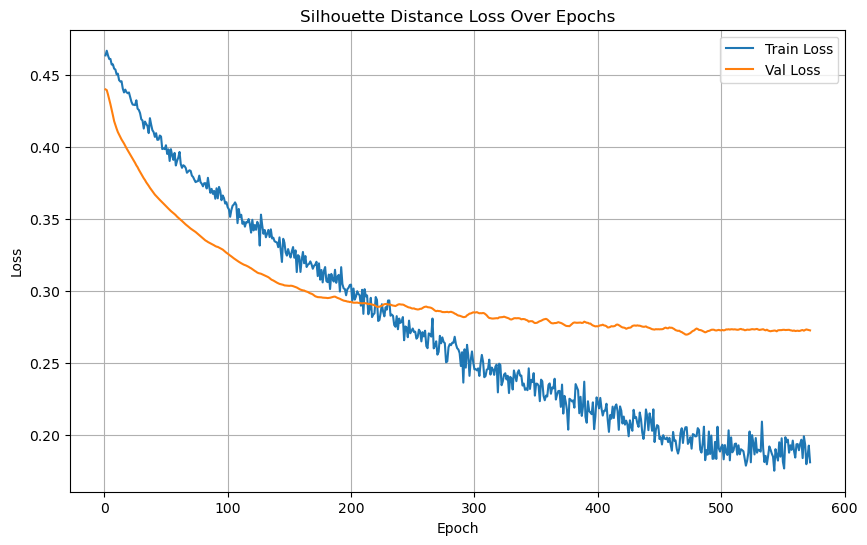

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/663], Loss: 0.2523


Test Batch [20/663], Loss: 0.1941
Test Batch [30/663], Loss: 0.2189
Test Batch [40/663], Loss: 0.3015


Test Batch [50/663], Loss: 0.2314


Test Batch [60/663], Loss: 0.2452
Test Batch [70/663], Loss: 0.1422
Test Batch [80/663], Loss: 0.1791


Test Batch [90/663], Loss: 0.1019


Test Batch [100/663], Loss: 0.0990
Test Batch [110/663], Loss: 0.0875
Test Batch [120/663], Loss: 0.1357


Test Batch [130/663], Loss: 0.1634


Test Batch [140/663], Loss: 0.2098
Test Batch [150/663], Loss: 0.1042
Test Batch [160/663], Loss: 0.1640
Test Batch [170/663], Loss: 0.1460
Test Batch [180/663], Loss: 0.5000


Test Batch [190/663], Loss: 0.1435


Test Batch [200/663], Loss: 0.0609
Test Batch [210/663], Loss: 0.5000
Test Batch [220/663], Loss: 0.5000
Test Batch [230/663], Loss: 0.1076
Test Batch [240/663], Loss: 0.5000
Test Batch [250/663], Loss: 0.5000
Test Batch [260/663], Loss: 0.5000
Test Batch [270/663], Loss: 0.5000
Test Batch [280/663], Loss: 0.5000


Test Batch [290/663], Loss: 0.5000
Test Batch [300/663], Loss: 0.1897


Test Batch [310/663], Loss: 0.1551
Test Batch [320/663], Loss: 0.1996
Test Batch [330/663], Loss: 0.1704


Test Batch [340/663], Loss: 0.1604


Test Batch [350/663], Loss: 0.1221
Test Batch [360/663], Loss: 0.1239


Test Batch [370/663], Loss: 0.0997


Test Batch [380/663], Loss: 0.1346
Test Batch [390/663], Loss: 0.1158


Test Batch [400/663], Loss: 0.1431


Test Batch [410/663], Loss: 0.1329
Test Batch [420/663], Loss: 0.0961


Test Batch [430/663], Loss: 0.2216
Test Batch [440/663], Loss: 0.2932
Test Batch [450/663], Loss: 0.3458
Test Batch [460/663], Loss: 0.3253


Test Batch [470/663], Loss: 0.3088
Test Batch [480/663], Loss: 0.1536
Test Batch [490/663], Loss: 0.1870


Test Batch [500/663], Loss: 0.1085
Test Batch [510/663], Loss: 0.1472
Test Batch [520/663], Loss: 0.1922
Test Batch [530/663], Loss: 0.2645


Test Batch [540/663], Loss: 0.3026
Test Batch [550/663], Loss: 0.2418
Test Batch [560/663], Loss: 0.2056
Test Batch [570/663], Loss: 0.2909


Test Batch [580/663], Loss: 0.2093
Test Batch [590/663], Loss: 0.2635
Test Batch [600/663], Loss: 0.2730
Test Batch [610/663], Loss: 0.2389


Test Batch [620/663], Loss: 0.1837
Test Batch [630/663], Loss: 0.2377
Test Batch [640/663], Loss: 0.2851


Test Batch [650/663], Loss: 0.3311
Test Batch [660/663], Loss: 0.4501

Test Loss: 0.2566


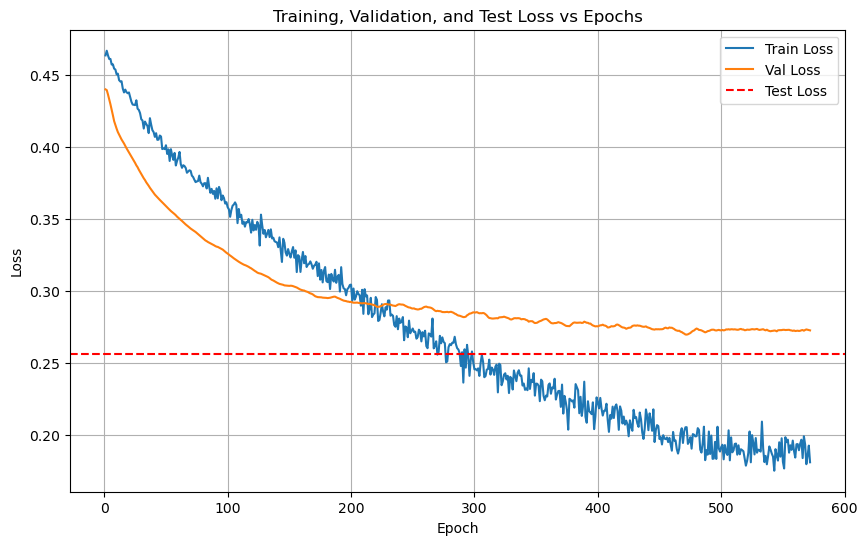

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/663 for test dataset.
  Processed batch 20/663 for test dataset.


  Processed batch 30/663 for test dataset.
  Processed batch 40/663 for test dataset.


  Processed batch 50/663 for test dataset.
  Processed batch 60/663 for test dataset.


  Processed batch 70/663 for test dataset.
  Processed batch 80/663 for test dataset.


  Processed batch 90/663 for test dataset.
  Processed batch 100/663 for test dataset.


  Processed batch 110/663 for test dataset.
  Processed batch 120/663 for test dataset.


  Processed batch 130/663 for test dataset.
  Processed batch 140/663 for test dataset.


  Processed batch 150/663 for test dataset.


  Processed batch 160/663 for test dataset.
  Processed batch 170/663 for test dataset.
  Processed batch 180/663 for test dataset.


  Processed batch 190/663 for test dataset.
  Processed batch 200/663 for test dataset.


  Processed batch 210/663 for test dataset.
  Processed batch 220/663 for test dataset.
  Processed batch 230/663 for test dataset.
  Processed batch 240/663 for test dataset.


  Processed batch 250/663 for test dataset.
  Processed batch 260/663 for test dataset.
  Processed batch 270/663 for test dataset.


  Processed batch 280/663 for test dataset.
  Processed batch 290/663 for test dataset.


  Processed batch 300/663 for test dataset.
  Processed batch 310/663 for test dataset.
  Processed batch 320/663 for test dataset.
  Processed batch 330/663 for test dataset.


  Processed batch 340/663 for test dataset.
  Processed batch 350/663 for test dataset.
  Processed batch 360/663 for test dataset.


  Processed batch 370/663 for test dataset.
  Processed batch 380/663 for test dataset.
  Processed batch 390/663 for test dataset.
  Processed batch 400/663 for test dataset.


  Processed batch 410/663 for test dataset.
  Processed batch 420/663 for test dataset.
  Processed batch 430/663 for test dataset.
  Processed batch 440/663 for test dataset.


  Processed batch 450/663 for test dataset.
  Processed batch 460/663 for test dataset.
  Processed batch 470/663 for test dataset.


  Processed batch 480/663 for test dataset.
  Processed batch 490/663 for test dataset.
  Processed batch 500/663 for test dataset.
  Processed batch 510/663 for test dataset.


  Processed batch 520/663 for test dataset.
  Processed batch 530/663 for test dataset.
  Processed batch 540/663 for test dataset.


  Processed batch 550/663 for test dataset.
  Processed batch 560/663 for test dataset.


  Processed batch 570/663 for test dataset.
  Processed batch 580/663 for test dataset.
  Processed batch 590/663 for test dataset.
  Processed batch 600/663 for test dataset.


  Processed batch 610/663 for test dataset.
  Processed batch 620/663 for test dataset.
  Processed batch 630/663 for test dataset.
  Processed batch 640/663 for test dataset.


  Processed batch 650/663 for test dataset.
  Processed batch 660/663 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.33      0.40      0.36         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       0.33      0.20      0.25         5
           6       0.83      1.00      0.91         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.79        45
weighted avg       0.80      0.80      0.79        45


LOG: Evaluating on the test set...
Test Accuracy: 77.63%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6499  |  Val Loss: 2.5392
Validation loss improved from inf to 2.5392.
[Epoch 2/1000] Train Loss: 2.4612  |  Val Loss: 2.3720
Validation loss improved from 2.5392 to 2.3720.
[Epoch 3/1000] Train Loss: 2.2881  |  Val Loss: 2.2267
Validation loss improved from 2.3720 to 2.2267.
[Epoch 4/1000] Train Loss: 2.1472  |  Val Loss: 2.1055
Validation loss improved from 2.2267 to 2.1055.
[Epoch 5/1000] Train Loss: 2.0318  |  Val Loss: 2.0085
Validation loss improved from 2.1055 to 2.0085.
[Epoch 6/1000] Train Loss: 1.9340  |  Val Loss: 1.9277
Validation loss improved from 2.0085 to 1.9277.
[Epoch 7/1000] Train Loss: 1.8551  |  Val Loss: 1.8614
Validation loss improved from 1.9277 to 1.8614.
[Epoch 8/1000] Train Loss: 1.7850  |  Val Loss: 1.8045
Validation loss improved from 1.8614 to 1.8045.
[Epoch 9/1000] Train Loss: 1.7288  |  Val Loss: 1.7544
Validation loss improved from 1.8045 to 1.7544.
[Epoch 10/1000] Train Loss: 1.6792  |  Val Loss: 1.7107
Validation loss impr

[Epoch 15/1000] Train Loss: 1.5003  |  Val Loss: 1.5544
Validation loss improved from 1.5789 to 1.5544.
[Epoch 16/1000] Train Loss: 1.4751  |  Val Loss: 1.5316
Validation loss improved from 1.5544 to 1.5316.
[Epoch 17/1000] Train Loss: 1.4517  |  Val Loss: 1.5101
Validation loss improved from 1.5316 to 1.5101.
[Epoch 18/1000] Train Loss: 1.4295  |  Val Loss: 1.4901
Validation loss improved from 1.5101 to 1.4901.
[Epoch 19/1000] Train Loss: 1.4086  |  Val Loss: 1.4711
Validation loss improved from 1.4901 to 1.4711.
[Epoch 20/1000] Train Loss: 1.3878  |  Val Loss: 1.4530
Validation loss improved from 1.4711 to 1.4530.
[Epoch 21/1000] Train Loss: 1.3684  |  Val Loss: 1.4353
Validation loss improved from 1.4530 to 1.4353.
[Epoch 22/1000] Train Loss: 1.3495  |  Val Loss: 1.4186
Validation loss improved from 1.4353 to 1.4186.
[Epoch 23/1000] Train Loss: 1.3314  |  Val Loss: 1.4026
Validation loss improved from 1.4186 to 1.4026.
[Epoch 24/1000] Train Loss: 1.3138  |  Val Loss: 1.3871
Validati

[Epoch 34/1000] Train Loss: 1.1491  |  Val Loss: 1.2444
Validation loss improved from 1.2580 to 1.2444.
[Epoch 35/1000] Train Loss: 1.1322  |  Val Loss: 1.2307
Validation loss improved from 1.2444 to 1.2307.
[Epoch 36/1000] Train Loss: 1.1164  |  Val Loss: 1.2172
Validation loss improved from 1.2307 to 1.2172.
[Epoch 37/1000] Train Loss: 1.0998  |  Val Loss: 1.2038
Validation loss improved from 1.2172 to 1.2038.
[Epoch 38/1000] Train Loss: 1.0831  |  Val Loss: 1.1903
Validation loss improved from 1.2038 to 1.1903.
[Epoch 39/1000] Train Loss: 1.0671  |  Val Loss: 1.1768
Validation loss improved from 1.1903 to 1.1768.
[Epoch 40/1000] Train Loss: 1.0507  |  Val Loss: 1.1635
Validation loss improved from 1.1768 to 1.1635.
[Epoch 41/1000] Train Loss: 1.0344  |  Val Loss: 1.1508
Validation loss improved from 1.1635 to 1.1508.
[Epoch 42/1000] Train Loss: 1.0184  |  Val Loss: 1.1381
Validation loss improved from 1.1508 to 1.1381.
[Epoch 43/1000] Train Loss: 1.0022  |  Val Loss: 1.1246
Validati

[Epoch 50/1000] Train Loss: 0.8865  |  Val Loss: 1.0319
Validation loss improved from 1.0449 to 1.0319.
[Epoch 51/1000] Train Loss: 0.8700  |  Val Loss: 1.0200
Validation loss improved from 1.0319 to 1.0200.
[Epoch 52/1000] Train Loss: 0.8531  |  Val Loss: 1.0073
Validation loss improved from 1.0200 to 1.0073.
[Epoch 53/1000] Train Loss: 0.8366  |  Val Loss: 0.9947
Validation loss improved from 1.0073 to 0.9947.
[Epoch 54/1000] Train Loss: 0.8197  |  Val Loss: 0.9811
Validation loss improved from 0.9947 to 0.9811.
[Epoch 55/1000] Train Loss: 0.8026  |  Val Loss: 0.9687
Validation loss improved from 0.9811 to 0.9687.
[Epoch 56/1000] Train Loss: 0.7854  |  Val Loss: 0.9542
Validation loss improved from 0.9687 to 0.9542.
[Epoch 57/1000] Train Loss: 0.7687  |  Val Loss: 0.9409
Validation loss improved from 0.9542 to 0.9409.
[Epoch 58/1000] Train Loss: 0.7510  |  Val Loss: 0.9274
Validation loss improved from 0.9409 to 0.9274.
[Epoch 59/1000] Train Loss: 0.7338  |  Val Loss: 0.9132
Validati

[Epoch 67/1000] Train Loss: 0.5990  |  Val Loss: 0.8050
Validation loss improved from 0.8176 to 0.8050.
[Epoch 68/1000] Train Loss: 0.5825  |  Val Loss: 0.7920
Validation loss improved from 0.8050 to 0.7920.
[Epoch 69/1000] Train Loss: 0.5662  |  Val Loss: 0.7792
Validation loss improved from 0.7920 to 0.7792.
[Epoch 70/1000] Train Loss: 0.5506  |  Val Loss: 0.7656
Validation loss improved from 0.7792 to 0.7656.
[Epoch 71/1000] Train Loss: 0.5347  |  Val Loss: 0.7516
Validation loss improved from 0.7656 to 0.7516.
[Epoch 72/1000] Train Loss: 0.5197  |  Val Loss: 0.7374
Validation loss improved from 0.7516 to 0.7374.
[Epoch 73/1000] Train Loss: 0.5044  |  Val Loss: 0.7246
Validation loss improved from 0.7374 to 0.7246.
[Epoch 74/1000] Train Loss: 0.4891  |  Val Loss: 0.7126
Validation loss improved from 0.7246 to 0.7126.
[Epoch 75/1000] Train Loss: 0.4747  |  Val Loss: 0.7014
Validation loss improved from 0.7126 to 0.7014.
[Epoch 76/1000] Train Loss: 0.4600  |  Val Loss: 0.6921
Validati

[Epoch 83/1000] Train Loss: 0.3659  |  Val Loss: 0.6245
Validation loss improved from 0.6335 to 0.6245.
[Epoch 84/1000] Train Loss: 0.3539  |  Val Loss: 0.6177
Validation loss improved from 0.6245 to 0.6177.
[Epoch 85/1000] Train Loss: 0.3423  |  Val Loss: 0.6079
Validation loss improved from 0.6177 to 0.6079.
[Epoch 86/1000] Train Loss: 0.3313  |  Val Loss: 0.6007
Validation loss improved from 0.6079 to 0.6007.
[Epoch 87/1000] Train Loss: 0.3207  |  Val Loss: 0.5954
Validation loss improved from 0.6007 to 0.5954.
[Epoch 88/1000] Train Loss: 0.3103  |  Val Loss: 0.5882
Validation loss improved from 0.5954 to 0.5882.
[Epoch 89/1000] Train Loss: 0.3007  |  Val Loss: 0.5823
Validation loss improved from 0.5882 to 0.5823.
[Epoch 90/1000] Train Loss: 0.2912  |  Val Loss: 0.5770
Validation loss improved from 0.5823 to 0.5770.
[Epoch 91/1000] Train Loss: 0.2823  |  Val Loss: 0.5719
Validation loss improved from 0.5770 to 0.5719.
[Epoch 92/1000] Train Loss: 0.2739  |  Val Loss: 0.5664
Validati

[Epoch 100/1000] Train Loss: 0.2196  |  Val Loss: 0.5403
Validation loss improved from 0.5455 to 0.5403.
[Epoch 101/1000] Train Loss: 0.2142  |  Val Loss: 0.5366
Validation loss improved from 0.5403 to 0.5366.
[Epoch 102/1000] Train Loss: 0.2092  |  Val Loss: 0.5352
Validation loss improved from 0.5366 to 0.5352.
[Epoch 103/1000] Train Loss: 0.2046  |  Val Loss: 0.5351
Validation loss improved from 0.5352 to 0.5351.
[Epoch 104/1000] Train Loss: 0.1997  |  Val Loss: 0.5329
Validation loss improved from 0.5351 to 0.5329.
[Epoch 105/1000] Train Loss: 0.1955  |  Val Loss: 0.5344
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 0.1913  |  Val Loss: 0.5330
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 0.1874  |  Val Loss: 0.5309
Validation loss improved from 0.5329 to 0.5309.
[Epoch 108/1000] Train Loss: 0.1838  |  Val Loss: 0.5267
Validation loss improved from 0.5309 to 0.5267.
[Epoch 109/1000] Train Loss: 0.1800  |  Val

[Epoch 118/1000] Train Loss: 0.1543  |  Val Loss: 0.5262
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] Train Loss: 0.1523  |  Val Loss: 0.5237
Validation loss improved from 0.5250 to 0.5237.
[Epoch 120/1000] Train Loss: 0.1498  |  Val Loss: 0.5251
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 0.1477  |  Val Loss: 0.5244
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 0.1457  |  Val Loss: 0.5247
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 123/1000] Train Loss: 0.1437  |  Val Loss: 0.5236
Validation loss improved from 0.5237 to 0.5236.
[Epoch 124/1000] Train Loss: 0.1421  |  Val Loss: 0.5228
Validation loss improved from 0.5236 to 0.5228.
[Epoch 125/1000] Train Loss: 0.1404  |  Val Loss: 0.5261
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 0.1385  |  Val Loss: 0.5243
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Tr

[Epoch 135/1000] Train Loss: 0.1254  |  Val Loss: 0.5250
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 136/1000] Train Loss: 0.1241  |  Val Loss: 0.5238
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 137/1000] Train Loss: 0.1230  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 138/1000] Train Loss: 0.1221  |  Val Loss: 0.5242
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 139/1000] Train Loss: 0.1208  |  Val Loss: 0.5242
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 140/1000] Train Loss: 0.1198  |  Val Loss: 0.5245
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 141/1000] Train Loss: 0.1188  |  Val Loss: 0.5249
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 142/1000] Train Loss: 0.1179  |  Val Loss: 0.5246
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 143/1000] Train Loss: 0.1168  |  Val Loss: 0.5254
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.1093  |  Val Loss: 0.5299
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 153/1000] Train Loss: 0.1086  |  Val Loss: 0.5291
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 154/1000] Train Loss: 0.1080  |  Val Loss: 0.5333
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 155/1000] Train Loss: 0.1073  |  Val Loss: 0.5364
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 156/1000] Train Loss: 0.1065  |  Val Loss: 0.5366
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 157/1000] Train Loss: 0.1058  |  Val Loss: 0.5331
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 158/1000] Train Loss: 0.1051  |  Val Loss: 0.5309
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 159/1000] Train Loss: 0.1044  |  Val Loss: 0.5314
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 160/1000] Train Loss: 0.1039  |  Val Loss: 0.5342
!! Validation loss did NOT improve !! Patience:

[Epoch 169/1000] Train Loss: 0.0989  |  Val Loss: 0.5406
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 170/1000] Train Loss: 0.0986  |  Val Loss: 0.5434
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 171/1000] Train Loss: 0.0980  |  Val Loss: 0.5408
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 172/1000] Train Loss: 0.0976  |  Val Loss: 0.5382
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 173/1000] Train Loss: 0.0971  |  Val Loss: 0.5378
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 174/1000] Train Loss: 0.0968  |  Val Loss: 0.5376
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 175/1000] Train Loss: 0.0964  |  Val Loss: 0.5392
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 176/1000] Train Loss: 0.0960  |  Val Loss: 0.5392
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 177/1000] Train Loss: 0.0955  |  Val Loss: 0.5402
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.0924  |  Val Loss: 0.5477
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 186/1000] Train Loss: 0.0920  |  Val Loss: 0.5463
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 187/1000] Train Loss: 0.0916  |  Val Loss: 0.5478
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 188/1000] Train Loss: 0.0911  |  Val Loss: 0.5489
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 189/1000] Train Loss: 0.0911  |  Val Loss: 0.5497
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 190/1000] Train Loss: 0.0908  |  Val Loss: 0.5474
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 191/1000] Train Loss: 0.0904  |  Val Loss: 0.5497
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 192/1000] Train Loss: 0.0901  |  Val Loss: 0.5472
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 193/1000] Train Loss: 0.0896  |  Val Loss: 0.5491
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.0865  |  Val Loss: 0.5575
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 204/1000] Train Loss: 0.0866  |  Val Loss: 0.5622
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 205/1000] Train Loss: 0.0862  |  Val Loss: 0.5603
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 206/1000] Train Loss: 0.0859  |  Val Loss: 0.5618
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 207/1000] Train Loss: 0.0857  |  Val Loss: 0.5613
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 208/1000] Train Loss: 0.0853  |  Val Loss: 0.5608
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 209/1000] Train Loss: 0.0850  |  Val Loss: 0.5623
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 210/1000] Train Loss: 0.0847  |  Val Loss: 0.5613
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 211/1000] Train Loss: 0.0844  |  Val Loss: 0.5599
!! Validation loss did NOT improve !! Patience:

[Epoch 219/1000] Train Loss: 0.0826  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 220/1000] Train Loss: 0.0823  |  Val Loss: 0.5690
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 221/1000] Train Loss: 0.0820  |  Val Loss: 0.5695
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 222/1000] Train Loss: 0.0818  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 223/1000] Train Loss: 0.0817  |  Val Loss: 0.5689
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 224/1000] Train Loss: 0.0814  |  Val Loss: 0.5707
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 224 !!
No improvement for 100 epochs.


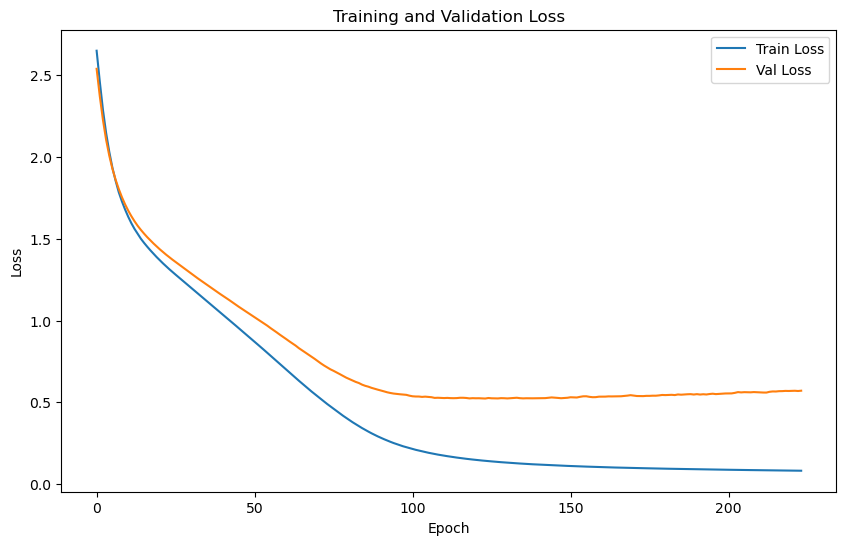

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.8307 | Test Accuracy: 77.09%


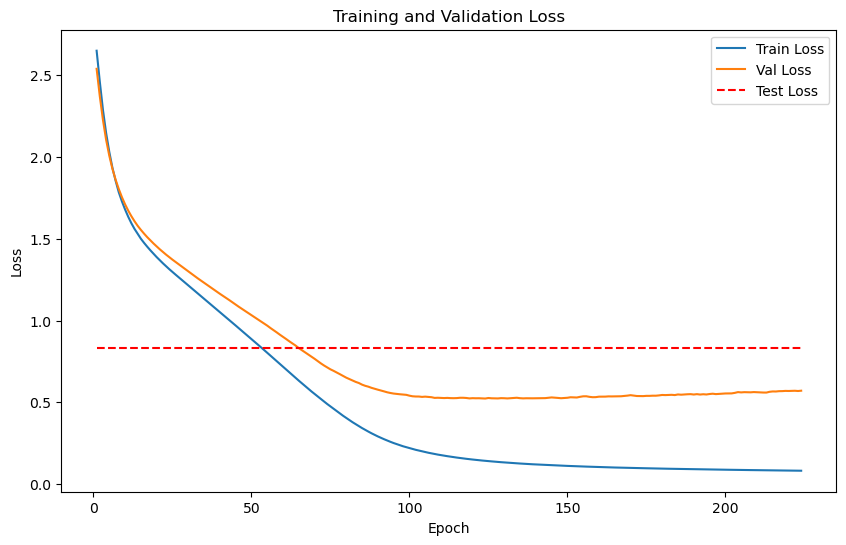

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


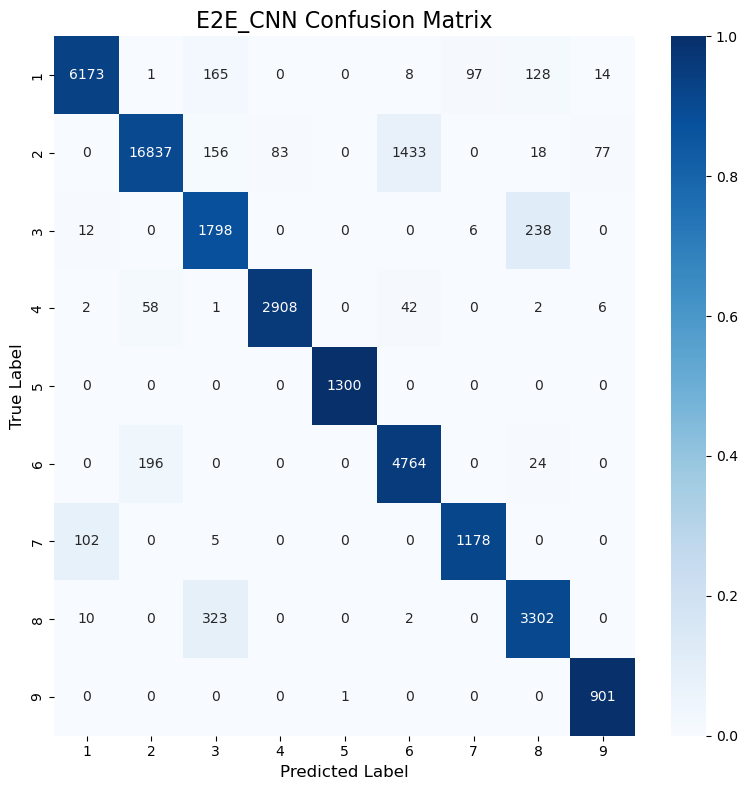

Classification Accuracy: 92.42%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


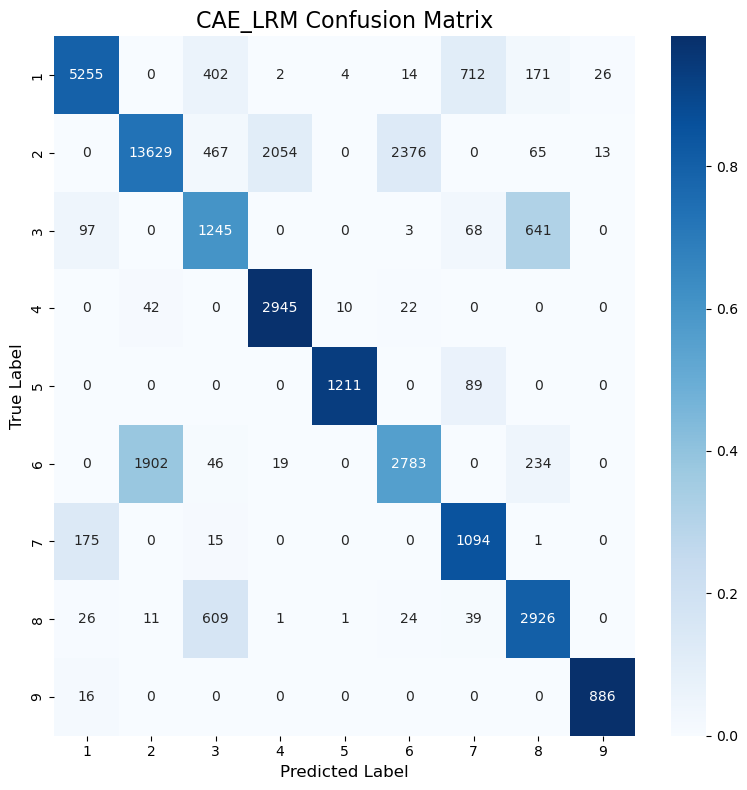

Classification Accuracy: 75.46%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


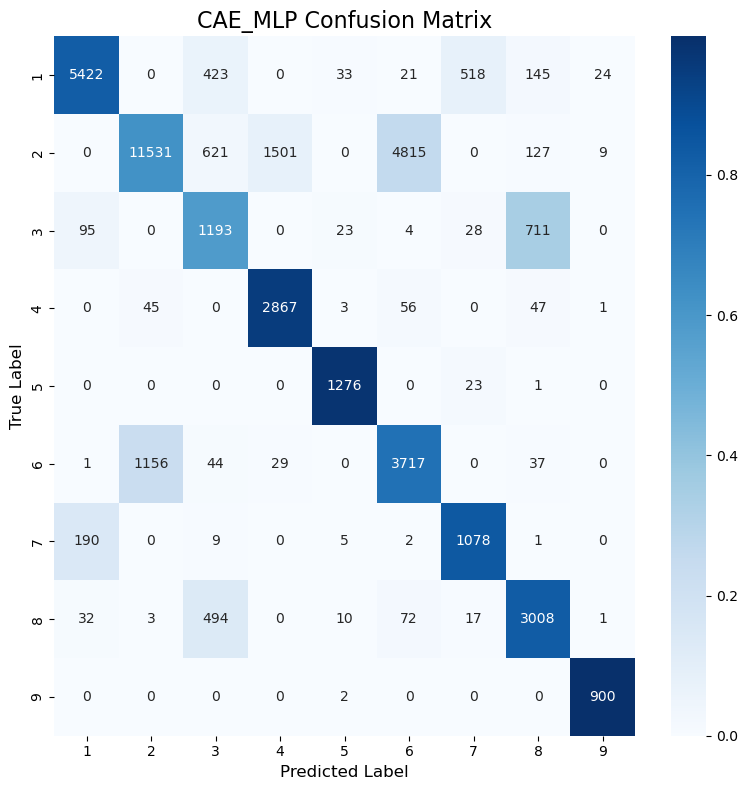

Classification Accuracy: 73.14%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


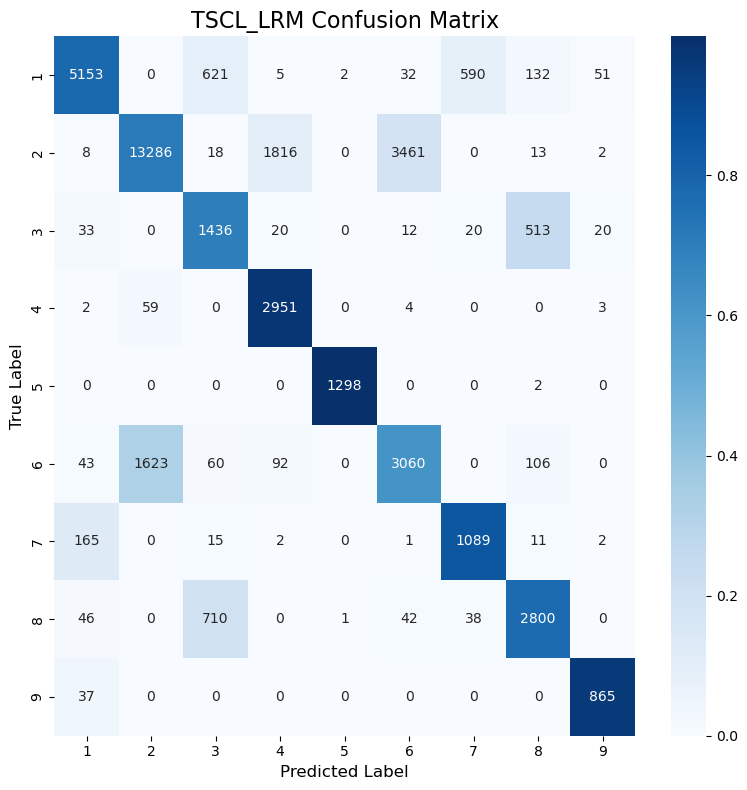

Classification Accuracy: 75.38%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


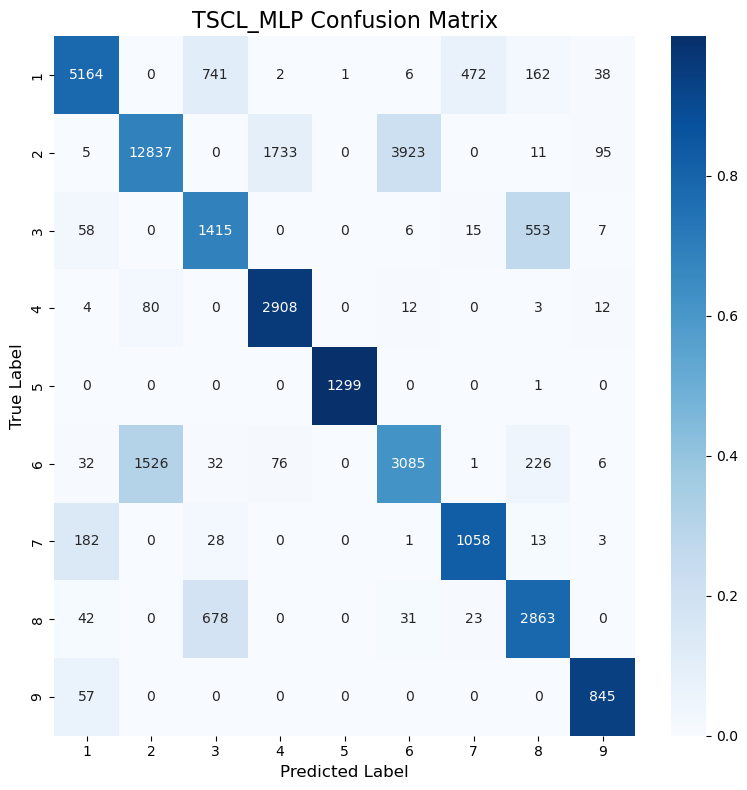

Classification Accuracy: 74.28%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


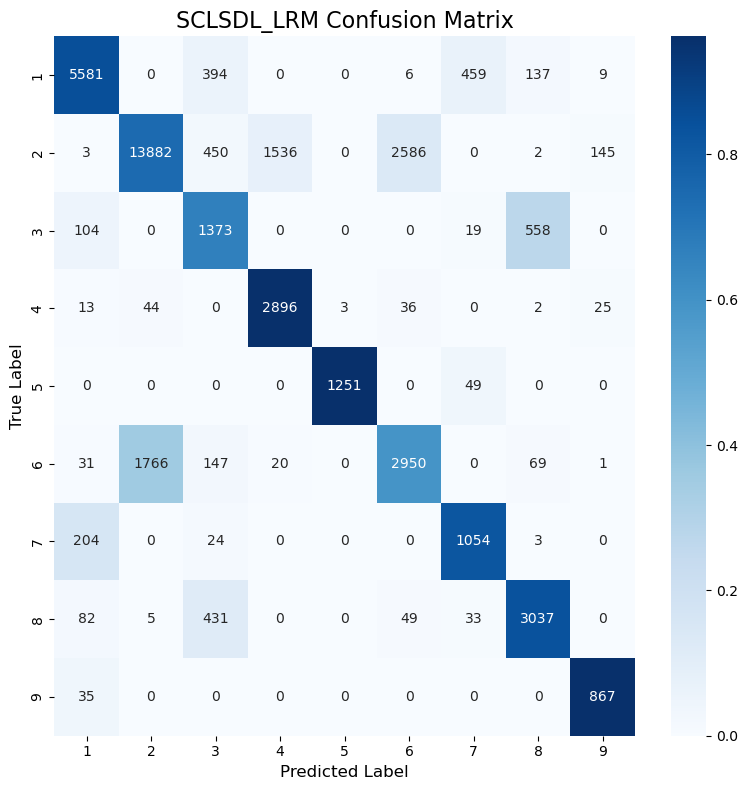

Classification Accuracy: 77.63%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


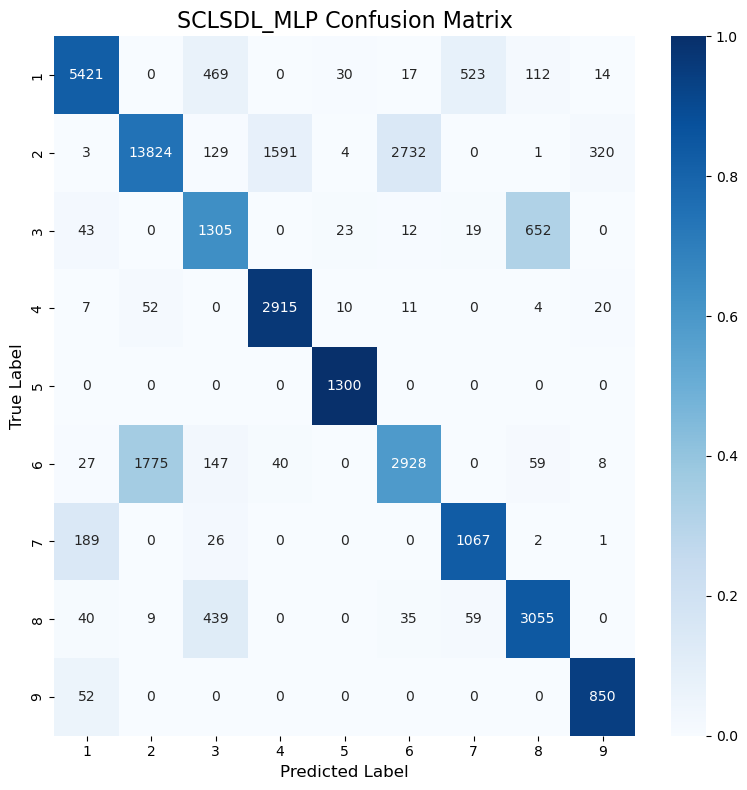

Classification Accuracy: 77.09%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          92.42
1    LRM (CAE)          75.46
2    MLP (CAE)          73.14
3     TSCL LRM          75.38
4     TSCL MLP          74.28
5  SCL_SDL LRM          77.63
6  SCL_SDL MLP          77.09

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          92.42
5  SCL_SDL LRM          77.63
6  SCL_SDL MLP          77.09
1    LRM (CAE)          75.46
3     TSCL LRM          75.38
4     TSCL MLP          74.28
2    MLP (CAE)          73.14
